# Undersampling

In [1]:
%run preprocessing_ccfd.ipynb

Zbog neravnoteže među klasama (sjetimo se da skup podataka sadrži 99.83% valjanih transakcija te 0.17% prevara) koristimo tehniku zvanu undersampling. Undersampling znači da od mnogobrojnije klase (valjane transakcije) uzimamo podskup podataka. U našem slučaju izdvajamo od svih valjanih transakcija u trening skupu njih 394 (jednako koliko je i prevara u trening skupu). <br> <b>Napomena</b>: Primjetimo da vršimo undersampling samo na trening skupu, testni skup i dalje ostaje isti <br>
To možemo postići na više načina, ovdje konkretno koristimo <i>RandomUnderSampler</i> (koji će nam automatski ujednačiti klase). Problem undersamplinga? <b>Gubitak informacija</b> (učimo na ~800 podataka, a bez undersamplinga bi učili na cijelom trening skupu koji ima ~220 000 podataka). Prednost undersamplinga? <b>Prepoznavanje prevara</b> (pošto su klase jednakobrojne model će lakše prepoznavati prevare).

In [2]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority')
X_usample_train, y_usample_train = undersample.fit_resample(X_data_train, y_data_train)
y_usample_non_fraud_num = y_usample_train.value_counts()[0]
y_usample_fraud_num = y_usample_train.value_counts()[1]

print('Broj valjanih transakcija u trening skupu nakon undersamplinga: ' + str(y_usample_non_fraud_num))
print('Broj prevarantskih transakcija u trening skupu nakon undersamplinga: ' + str(y_usample_fraud_num))
print('Ukupan broj transakcija u trening skupu nakon undersamplinga: ' + str(y_usample_fraud_num + y_usample_non_fraud_num))

Broj valjanih transakcija u trening skupu nakon undersamplinga: 394
Broj prevarantskih transakcija u trening skupu nakon undersamplinga: 394
Ukupan broj transakcija u trening skupu nakon undersamplinga: 788


In [3]:
%run functions.ipynb

## Logistička regresija

In [34]:
from sklearn.model_selection import cross_val_score
usample_log_reg = LogisticRegression(solver='liblinear')
usample_log_reg.fit(X_usample_train, y_usample_train)

usample_log_reg_training_score = cross_val_score(usample_log_reg, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim datasetom: ' 
     + str(round(usample_log_reg_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za logističku regresiju nad undersampliranim datasetom: 93.4%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.6000000000000005%
	Recall score: 91.84%
	F1 score: 10.56%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


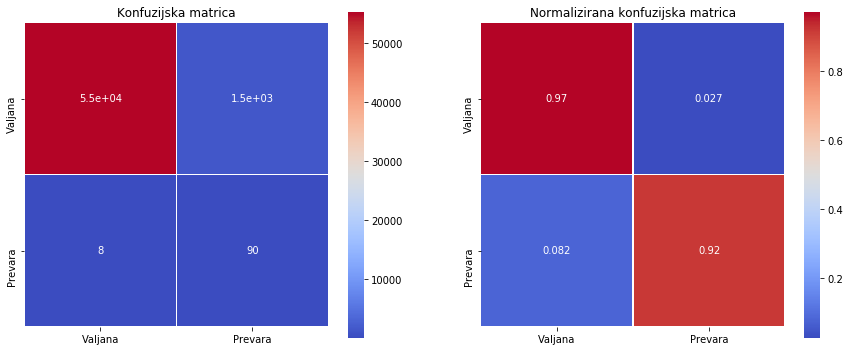

----------------------------------------------------------------------------------------------------


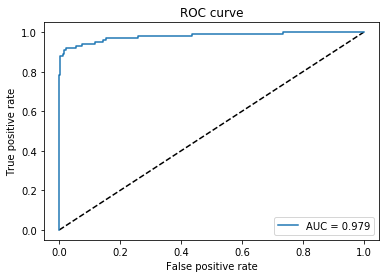

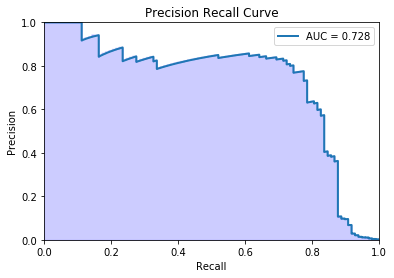

In [35]:
full_pred_log_reg = usample_log_reg.predict(X_data_test)
full_pred_score_log_reg = usample_log_reg.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg, True)

Vidimo da smo s logističkom regresijom kao klasifikatorom dobili sljedeće rezultate. Preciznost (5.60%) i f1-mjera(10.56%) nisu najbolji rezultati. No cilj nam je točno klasificirati što više prevara, a ovaj model ih je točno klasificirao 90 prevara (od ukupno 98). Stoga je i osjetljivost dosta visoka (91.84%). Iz konfuzijske matrice možemo očitati i koji je razlog toga što su preciznost i f1-mjera dosta slabi, a to jest ~1500 transakcija koje su valjane, a model ih je klasificirao kao prevare. Također vidimo da je i površina ispod PR-krivulje 0.728. <br> Sada ćemo pokušati podesiti parametre i vidjeti kako će to utjecati na rezultate.

Parametri koje podešavamo kod linearne regresije su:
<ul>
    <li><em>C</em> - regularizacijski parametar, inverzno proporcionalan $\lambda$ regulatoru. </li>
    <li><em>penalty</em> - određuje koju regularizacijsku tehniku koristimo
        <ul>
            <li><i>ridge (l2)</i> - kazna je "kvadratna veličina" koeficjenata
                \[
                rCost = \sum_{i = 1}^{n}\bigg(y_i - \sum_{j=1}^{p}x_{ij}\beta_j \bigg)^2  + \lambda \sum_{j=1}^{p} \beta_j^2
                \]</li>
            <li><i>lasso (l1)</i> - kazna je "apsolutna vrijednost veličine" koeficjenata 
            \[
            lCost = \sum_{i = 1}^{n}\bigg(y_i - \sum_{j=1}^{p}x_{ij}\beta_j \bigg)^2  + \lambda \sum_{j=1}^{p} \mid\beta_j\mid
            \]</li>
        </ul>
    </li>
</ul>

In [39]:
from sklearn.model_selection import GridSearchCV
log_reg_c_params = [0.01, 0.1, 1, 10, 100]
log_reg_penalties = ['l1','l2']
log_reg_params = {"penalty": log_reg_penalties, 'C': log_reg_c_params}

In [37]:
grid_log_reg = GridSearchCV(LogisticRegression(solver='liblinear'), log_reg_params)
grid_log_reg.fit(X_usample_train, y_usample_train)
log_reg_params_usample = grid_log_reg.best_estimator_
log_reg_params = grid_log_reg.best_params_
print('Najbolji parametri: ' + str(log_reg_params))

log_reg_training_score_params_usample = cross_val_score(log_reg_params_usample, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(log_reg_training_score_params_usample.mean(), 4) * 100) + '%')

Najbolji parametri: {'C': 0.1, 'penalty': 'l2'}
Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (sa parametrima): 93.49%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 6.0600000000000005%
	Recall score: 90.82000000000001%
	F1 score: 11.37%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.91      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


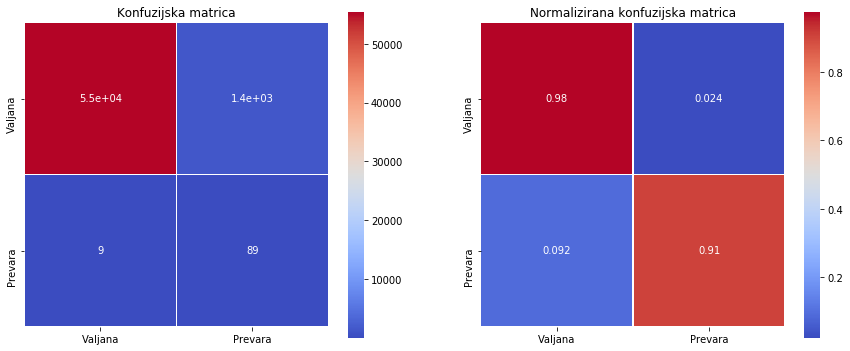

----------------------------------------------------------------------------------------------------


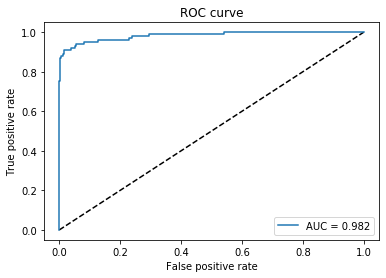

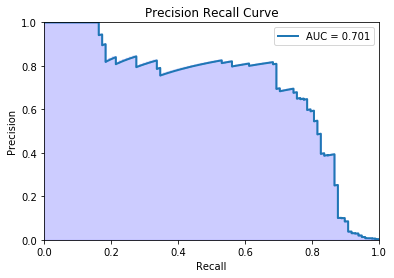

In [38]:
full_pred_log_reg_params = log_reg_params_usample.predict(X_data_test)
full_pred_score_log_reg_params = log_reg_params_usample.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg_params, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg_params, True)

Vidimo da smo podešavanjem parametara dobili dosta bolje rezultate. I preciznost (6.06%) i f1-mjera (11.37%) su porasle, dok je osjetljivost pala na 90.82%. Kada usporedimo konfuzijsku matricu s prošlom vidjet ćemo i zašto. Novi model je pogrešno klasificirao ~1400 valjanih transakcija (prošli je imao ~1500). To znači da će ljudima koji će 'ručno' provjeravati te transakcije uštedjeti dosta posla (oko 100 transakcija), ali je zato i ispravno klasificirao 89 prevara (bilo je 90). Površina ispod PR-krivulje je nešto manja nego kod prošlog modela, ali to nije značajna razlika. <br> Još ćemo pokušati u klasifikator ubaciti težine klasa. Težinama omogućavamo klasifikatoru da bude pristraniji prema nekoj klasi.

****************************************************************************************************
Tezina klase 1 (prevare) je 0.1 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 37.269999999999996%
	Recall score: 83.67%
	F1 score: 51.57000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.37      0.84      0.52        98

    accuracy                           1.00     56962
   macro avg       0.69      0.92      0.76     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


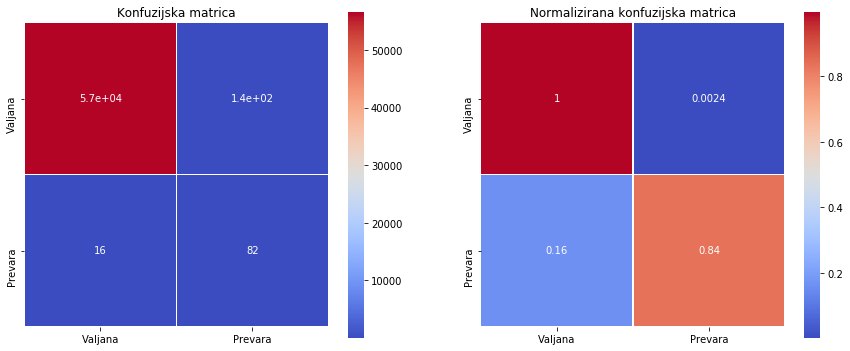

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 0.2 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 25.22%
	Recall score: 86.72999999999999%
	F1 score: 39.08%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.25      0.87      0.39        98

    accuracy                           1.00     56962
   macro avg       0.63      0.93      0.69     56962
weighted avg       1.00      1.00      1.00     56962


------------------------------------------------------------------------------------------------

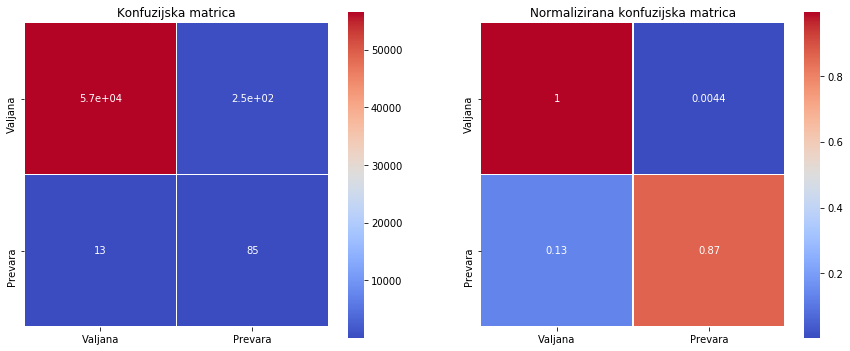

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 0.5 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 9.81%
	Recall score: 87.76%
	F1 score: 17.64%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.88      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.93      0.58     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


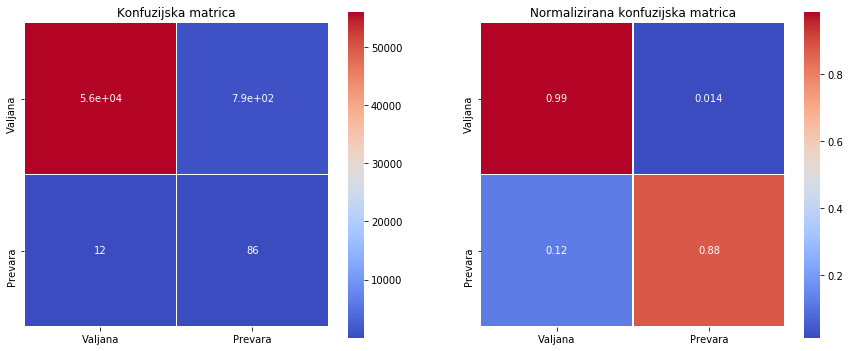

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 0.7 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.27%
	Recall score: 89.8%
	F1 score: 15.15%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.90      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


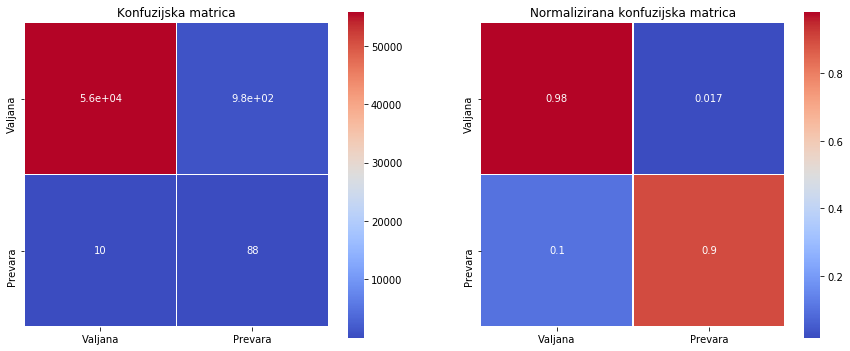

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 1 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 6.0600000000000005%
	Recall score: 90.82000000000001%
	F1 score: 11.37%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.91      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.98      0.99     56962


-------------------------------------------------------------------------------------

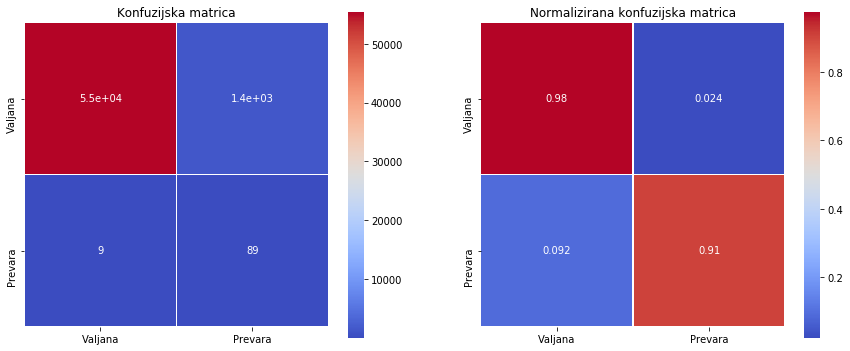

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 2 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 3.1399999999999997%
	Recall score: 91.84%
	F1 score: 6.069999999999999%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.92      0.06        98

    accuracy                           0.95     56962
   macro avg       0.52      0.93      0.52     56962
weighted avg       1.00      0.95      0.97     56962


-------------------------------------------------------------------------------------

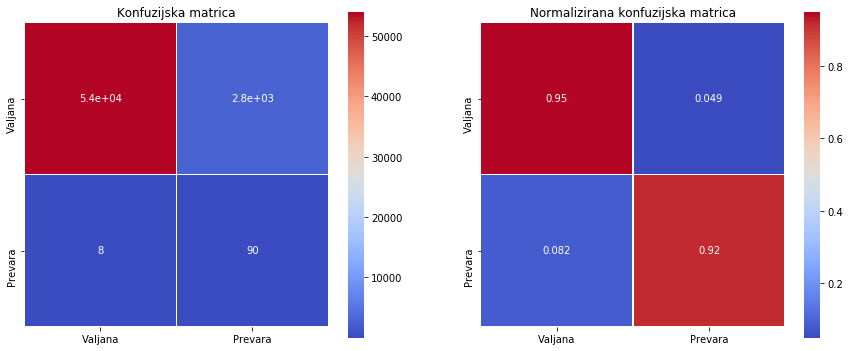

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 5 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 1.3299999999999998%
	Recall score: 95.92%
	F1 score: 2.6100000000000003%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.88      0.93     56864
           1       0.01      0.96      0.03        98

    accuracy                           0.88     56962
   macro avg       0.51      0.92      0.48     56962
weighted avg       1.00      0.88      0.93     56962


------------------------------------------------------------------------------------

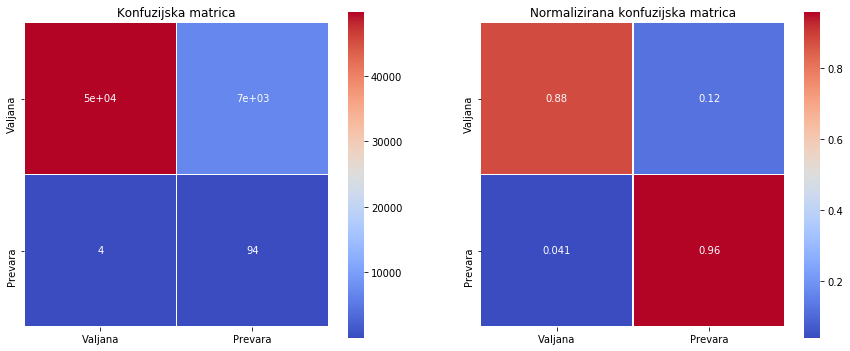

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 10 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.77%
	Recall score: 95.92%
	F1 score: 1.53%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.79      0.88     56864
           1       0.01      0.96      0.02        98

    accuracy                           0.79     56962
   macro avg       0.50      0.87      0.45     56962
weighted avg       1.00      0.79      0.88     56962


----------------------------------------------------------------------------------------------------


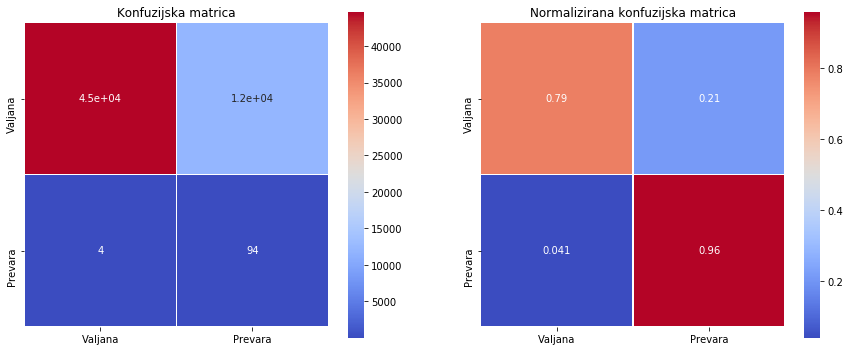

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 50 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.36%
	Recall score: 96.94%
	F1 score: 0.7100000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.53      0.70     56864
           1       0.00      0.97      0.01        98

    accuracy                           0.53     56962
   macro avg       0.50      0.75      0.35     56962
weighted avg       1.00      0.53      0.69     56962


-------------------------------------------------------------------------------------------------

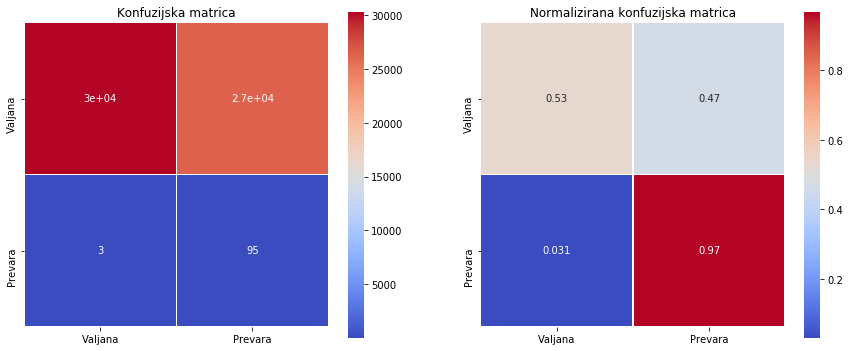

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 100 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.31%
	Recall score: 97.96000000000001%
	F1 score: 0.62%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.46      0.63     56864
           1       0.00      0.98      0.01        98

    accuracy                           0.46     56962
   macro avg       0.50      0.72      0.32     56962
weighted avg       1.00      0.46      0.63     56962


--------------------------------------------------------------------------------------------------

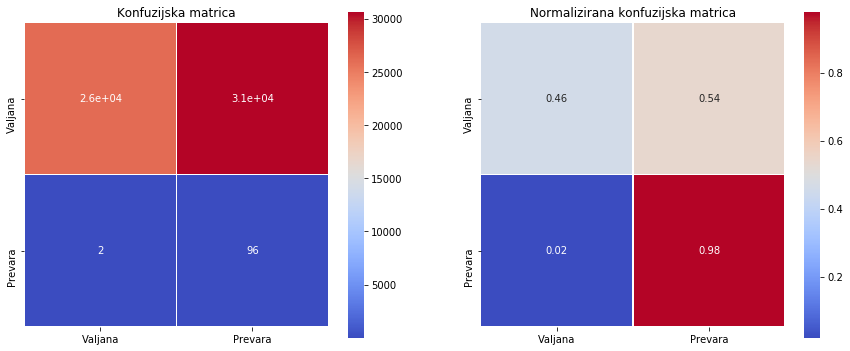

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 1000 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.26%
	Recall score: 98.98%
	F1 score: 0.51%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.34      0.51     56864
           1       0.00      0.99      0.01        98

    accuracy                           0.34     56962
   macro avg       0.50      0.66      0.26     56962
weighted avg       1.00      0.34      0.50     56962


----------------------------------------------------------------------------------------------------


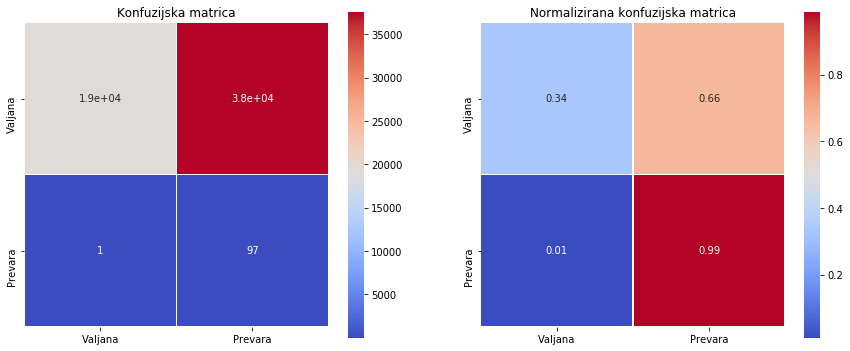

----------------------------------------------------------------------------------------------------
****************************************************************************************************
Tezina klase 1 (prevare) je 10000 puta veća od klase 0 (valjane).
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.19%
	Recall score: 100.0%
	F1 score: 0.38999999999999996%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.12      0.21     56864
           1       0.00      1.00      0.00        98

    accuracy                           0.12     56962
   macro avg       0.50      0.56      0.11     56962
weighted avg       1.00      0.12      0.21     56962


---------------------------------------------------------------------------------------------

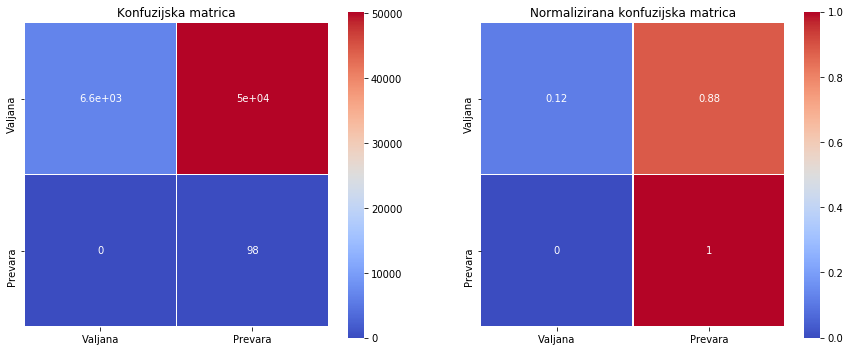

----------------------------------------------------------------------------------------------------


In [39]:

class_weights = [0.1, 0.2, 0.5, 0.7, 1, 2, 5, 10, 50, 100, 1000, 10000]
colors = ['blue', 'yellow', 'green', 'red', 'purple', 'orange', 'pink', 'cyan', 'gold', 'lime', 'grey', 'black']
i = 0
precisions = []
recalls = []
fprs = []
tprs = []
aucs = []
aprcs = []


for weight in class_weights: 
    log_reg_weighted = LogisticRegression(C=log_reg_params['C'], 
                                          penalty=log_reg_params['penalty'],
                                          solver='liblinear', class_weight={0:1, 1:weight}
                                         )
    
    log_reg_weighted.fit(X_usample_train, y_usample_train)

    full_pred_w = log_reg_weighted.predict(X_data_test)
    full_score_w = log_reg_weighted.decision_function(X_data_test)
    print('*'*100)
    print('Tezina klase 1 (prevare) je ' + str(weight) + ' puta veća od klase 0 (valjane).' )
    print_everything(y_data_test, full_pred_w, y_data_test_non_fraud_num, y_data_test_fraud_num, full_score_w, False)
    
    precision, recall, threshold = precision_recall_curve(y_data_test, full_score_w)
    fpr, tpr, thold = roc_curve(y_data_test, full_score_w)
    area_under_curve = auc(fpr,tpr)
    au_pr_curve = auc(recall,precision)
    
    precisions.append(precision)
    recalls.append(recall)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(area_under_curve)
    aprcs.append(au_pr_curve)

Vidimo da kada podesimo težine dobijemo dosta drugačije rezultate (dosta veća preciznost i f1-mjera). Kada stavimo da je težina valjane klase vidimo da se kod modela drastično smanji broj pogrešno klasificiranih valjanih transakcija. Primjerice, kada je težine valjane klase 10 puta veća od klase prevara dobijemo svega 140 pogrešno klasificirane valjane transakcije (bez težina je bilo ~1400), što je značajan napredak. No, time smo i izgubili na broju ispravno klasificiranih prevara (sada ih je samo 82). Odnosno, 8 ljudi više nego prije će se 'izvuć' bez posljedica iako su nekom ukrali novac. <br> Isto tako kada je težina klase prevara 10 puta veća od klase valjana tada imamo jako nisku preciznost i f1-mjeru, ali je osjetljivost jako visoka (95.92%). Odnosno, sa takvim težinama model ispravno klasificira ispravno čak 94 prevar3. Doduše, isti model klasificira ~12000 valjanih transakcija kao prevare. <br> Od svih tih modela možemo odbrati onaj koji nam najviše odgovara (moežemo i detaljnije podesiti težine).

C:\Users\stvar\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


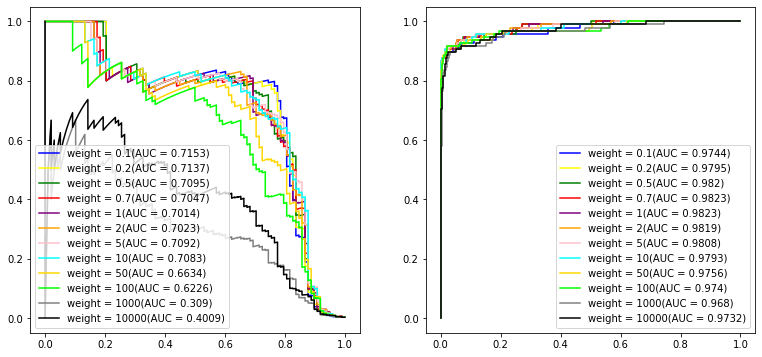

In [40]:
fig_w, ax_w = plt.subplots(1,2,figsize=(13,6))

for i in range(len(colors)):
    ax_w[0].plot(recalls[i], precisions[i], color=colors[i], label='weight = ' + str(class_weights[i]) + '(AUC = ' + str(round(aprcs[i], 4)) + ')')
    ax_w[1].plot(fprs[i], tprs[i], color=colors[i], label='weight = ' + str(class_weights[i]) + '(AUC = ' + str(round(aucs[i], 4)) + ')' )
ax_w[0].legend()
ax_w[1].legend()
plt.show()


Na slikama iznad vidimo i kako težine utječu na PR-krivulju (lijevo) i ROC-krivulju (desno).

## Stabla odluke

In [41]:
dt_usample = DecisionTreeClassifier()
dt_usample.fit(X_usample_train, y_usample_train)
dt_training_score_usample = cross_val_score(dt_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za stabla odluke nad undersampliranim datasetom: " + 
      str(round(dt_training_score_usample.mean(), 4) * 100) + '%')

Rezultat treniranja za stabla odluke nad undersampliranim datasetom: 88.11%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 2.02%
	Recall score: 91.84%
	F1 score: 3.9600000000000004%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     56864
           1       0.02      0.92      0.04        98

    accuracy                           0.92     56962
   macro avg       0.51      0.92      0.50     56962
weighted avg       1.00      0.92      0.96     56962


----------------------------------------------------------------------------------------------------


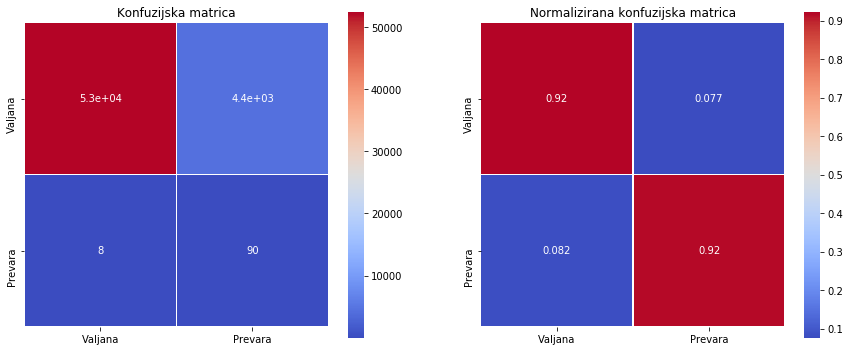

----------------------------------------------------------------------------------------------------


In [42]:
full_pred_dt = dt_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_dt, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Prvo što primjećujemo kod ovog modela je da su rezultati dosta slabiji. Vidimo da su preciznost (2.02%) i f1-mjera (3.96%) dosta manji nego kod logističke regresije. Ono što ovaj model čini dosta lošijim je što je uz to i osjetljivost slabija (91.84%). Kod matrice konfuzije prvo uočavamo da je pogrešno klasificirano čak ~4400 valjanih transakcija. Što je i više nego dvostruko koliko je model temeljen na logističkoj regresiji (bez parametara je bilo ~1500). Primjetimo i da ovaj model ima 90 ispravno klasificiranih prevara (kod logističke regresije je također bilo 90). <br> Pokušat ćemo i za ovaj model podesiti parametre pa vidjeti hoćemo li tako dobiti bolji model. 

Parametri koje podešavamo kod stabala odluke:
<ul>
    <li><em>kriterij</em> - funkcija kvalitete podjele
        <ul>
            <li><i>gini</i> - kriterij koji koristimo da smanjimo vjerojatnost pogrešne klasifikacije
            \[
            Gini = 1 - \sum_j p_j^2
            \]</li>
            <li><i>entropy</i> - kriterij koji koristimo da smanjimo nečistoću podjele
            \[
            Entropy = - \sum_j p_j log_2p_j
            \]</li>
        </ul>
    </li>
</ul>

In [43]:
criterion_params = ['gini', 'entropy']
splitter_params = ['best', 'random']
max_depth_params = [1, 2, 3, 4, 5, 6, 7]
min_samples_leaf_params = [1, 3, 5, 7]
dt_params = {'criterion': criterion_params, 'splitter': splitter_params, 'max_depth': max_depth_params, 'min_samples_leaf': min_samples_leaf_params}

In [43]:

grid_dt = GridSearchCV(DecisionTreeClassifier(), dt_params)
grid_dt.fit(X_usample_train, y_usample_train)
dt_params_usample = grid_dt.best_estimator_
dt_params_best = grid_dt.best_params_
print('Najbolji parametri: ' + str(dt_params_best))

dt_training_score_params_usample = cross_val_score(dt_params_usample, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za stabla odluke nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(dt_training_score_params_usample.mean(), 4) * 100) + '%')

Najbolji parametri: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 7, 'splitter': 'random'}
Rezultat treniranja za stabla odluke nad undersampliranim datasetom (sa parametrima): 91.2%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 1.83%
	Recall score: 90.82000000000001%
	F1 score: 3.58%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     56864
           1       0.02      0.91      0.04        98

    accuracy                           0.92     56962
   macro avg       0.51      0.91      0.50     56962
weighted avg       1.00      0.92      0.95     56962


----------------------------------------------------------------------------------------------------


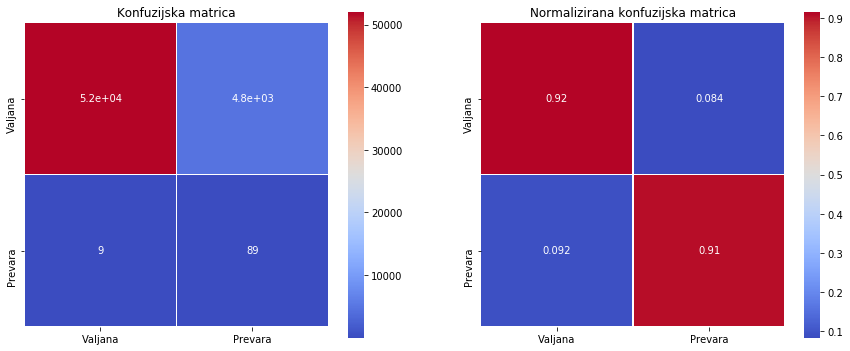

----------------------------------------------------------------------------------------------------


In [44]:
full_pred_dt_params = dt_params_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_dt_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Vidimo da smo ovdje dobili slabiji model. Preciznije, smanjili smo preciznost (1.83%) i f1-mjeru (3.58%), ali i osjetljivost (90.82%). Pomoću konfuzijske matrice vidimo da smo dobili ~4800 pogrešno klasificiranih transakcija (imali smo ~4400). 

## Bagging

In [45]:
bag_usample = BaggingClassifier()
bag_usample.fit(X_usample_train, y_usample_train)
bag_training_score_usample = cross_val_score(bag_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za bagging nad undersampliranim datasetom: " + 
      str(round(bag_training_score_usample.mean(), 4) * 100) + '%')


Rezultat treniranja za bagging nad undersampliranim datasetom: 92.25999999999999%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.55%
	Recall score: 91.84%
	F1 score: 10.47%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


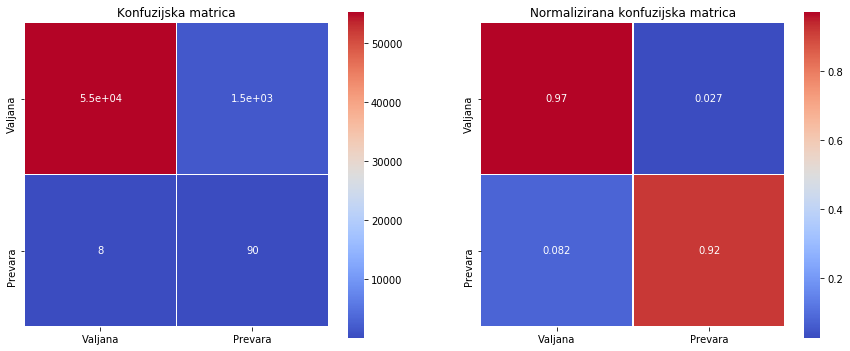

----------------------------------------------------------------------------------------------------


In [46]:
full_pred_bag = bag_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_bag, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Korištenjem bagginga (na stablima odluke) dobijamo dosta bolji rezultat nego korištenjem običnih stabala odluke. Vidimo da je ovaj model bolji u sve tri metrike. Odnosno, preciznost ovog modela je 5.55%, f1-mjera 10.47%, a osjetljivost 91.84%. Pomoću konfuzijske matrice vidimo da imamo 90 ispravno klasificiranih prevara (jednako kao i stabla odluke), odnosno jednu više nego na stablima odluke. Također ovaj model pogrešno klasificira ~ 1500 prevara (isto kao i model  logističe regresije ), dok je model na stablima odluke pogrešno klasificirao čak ~4400 (prije podešavanja parametara).

Parametri koje podešavamo na bagging klasifikatoru na stablima odluke:
<ul>
    <li><em>broj procjenitelja</em> - određuje broj stabala odluke u ansamblu </li>
    <li><em>maksimalan udio podataka</em> - određuje udio koji 'vadimo' iz trening skupa kod treniranja svakog procjenitelja</li>
    <li><em>maksimalan udio značajki</em> - određuje udio značajki koje koristimo prilikom treniranja </li>
</ul>

In [47]:
num_estimators_params = [5, 7, 10, 12, 20, 50, 100]
max_samples_params = [0.5, 0.7, 0.9, 1.0]
max_features_params = [0.3, 0.5, 0.7, 0.9, 1.0]
bag_params = {'n_estimators': num_estimators_params, 'max_samples': max_samples_params,
              'max_features': max_features_params}

In [47]:
grid_bag = GridSearchCV(BaggingClassifier(), bag_params)
grid_bag.fit(X_usample_train, y_usample_train)
bag_params_usample = grid_bag.best_estimator_
bag_params_best = grid_bag.best_params_
print('Najbolji parametri: ' + str(bag_params_best))

bag_training_score_params_usample = cross_val_score(bag_params_usample, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za bagging klasifikator nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(bag_training_score_params_usample.mean(), 4) * 100) + '%')

Najbolji parametri: {'max_features': 0.5, 'max_samples': 0.9, 'n_estimators': 50}
Rezultat treniranja za bagging klasifikator nad undersampliranim datasetom (sa parametrima): 93.06%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 7.340000000000001%
	Recall score: 90.82000000000001%
	F1 score: 13.59%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.91      0.14        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


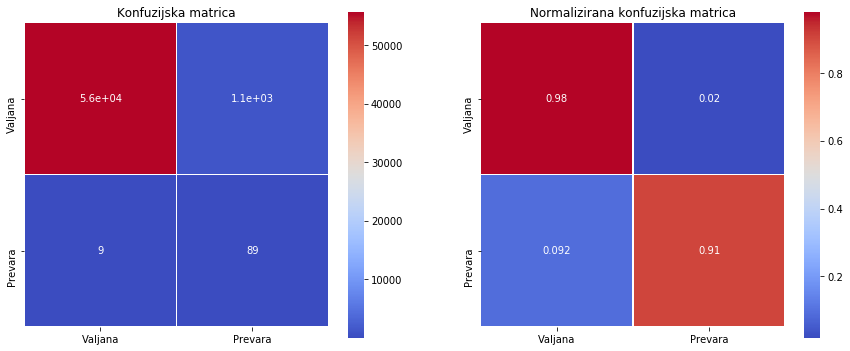

----------------------------------------------------------------------------------------------------


In [48]:
full_pred_bag_params = bag_params_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_bag_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Kao i u prijašnjim primjerima, podešavanje parametara je poboljšalo preciznost (7.34%) te f1-mjeru (13.59%), ali i smanjilo osjetljivost (90.82%). Preko konfuzijske matrice vidimo da je razlog tome pad u broj pogrešno klasificiranih valjanih transakcija (bilo je ~1500, sad je ~1100).

## Slučajne šume

In [49]:
rf_usample = RandomForestClassifier()
rf_usample.fit(X_usample_train, y_usample_train)
rf_training_score_usample = cross_val_score(rf_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za slučajne šume nad undersampliranim datasetom: " + 
      str(round(rf_training_score_usample.mean(), 4) * 100) + '%')


Rezultat treniranja za slučajne šume nad undersampliranim datasetom: 93.53%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.04%
	Recall score: 90.82000000000001%
	F1 score: 14.77%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.91      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


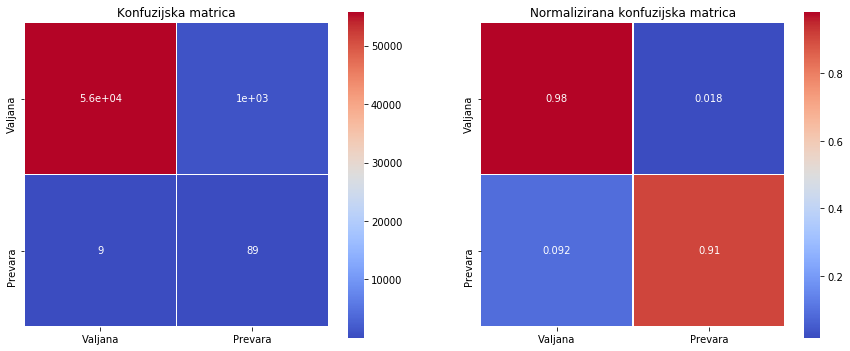

----------------------------------------------------------------------------------------------------


In [50]:
full_pred_rf = rf_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_rf, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Ovaj model je dosad najbolji (bez parametara). Vidimo da ima dosad najvišu preciznost (8.04%) i f1-mjeru (14.77%), te jednaku osjetljivost (90.82%) kao i mnogi modeli prije. Preciznije, ovaj model kao i neki prethodni ima 89 ispravno klasificiranih prevara, dok ima i najmanje pogrešno klasificiranih valjanih transakcija (~1000).

Parametri koje promatramo kod slučajnih šuma:
<ul>
    <li><em>kriterij</em> - poprima vrijednosti <i>gini</i> ili <i>entropy</i> koji su isto definirani kao i kod stabala odluke</li>
    <li><em>broj procjenitelja</em> - određuje broj stabala u slučajnoj šumi</li>
    <li><em>maksimalna dubina</em> - određuje maksimalnu dubinu svakog stabla u šumi</li>
    <li><em>minimalan broj list</em> - određuje koliko primjeraka najmanje smije bit u listu stabla</li>
    <li><em>težina klasa</em> - određuje težine koje dodjeljujemo klasama prilikom klasifikacije (valjana, prevara)
        <ul>
            <li><i>balanced</i> - određuje težine tako da uzima broj pojavljivanja klasa u ulaznim podacima</li>
            <li><i>balanced_subsample</i> - isto kao i <i>balanced</i>, ali su u ovom slučaju težine bazirane na bootstrap primjerku svakog stabla koje se gradi</li>
        </ul>
    </li>
</ul>

In [50]:
criterion_params = ['gini', 'entropy']
num_estimators_params = [5, 10, 50, 100]
max_depth_params = [1, 2, 3, 4, 5, 7, 9]
min_samples_leaf_params = [1, 3, 5, 7]
class_weight_params = ['balanced', 'balanced_subsample']
rf_params = {'criterion': criterion_params, 'n_estimators': num_estimators_params, 'max_depth': max_depth_params,
             'min_samples_leaf': min_samples_leaf_params, 'class_weight': class_weight_params}

In [51]:

grid_rf = GridSearchCV(RandomForestClassifier(), rf_params)
grid_rf.fit(X_usample_train, y_usample_train)
rf_params_usample = grid_rf.best_estimator_
rf_params_best = grid_rf.best_params_
print('Najbolji parametri: ' + str(rf_params_best))

rf_training_score_params_usample = cross_val_score(rf_params_usample, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za slučajne šume nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(rf_training_score_params_usample.mean(), 4) * 100) + '%')

Najbolji parametri: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 50}
Rezultat treniranja za slučajne šume nad undersampliranim datasetom (sa parametrima): 93.36%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.04%
	Recall score: 90.82000000000001%
	F1 score: 14.77%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.91      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


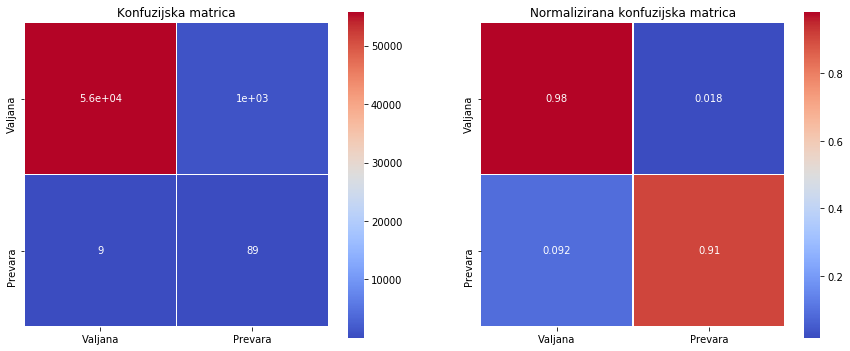

----------------------------------------------------------------------------------------------------


In [52]:
full_pred_rf = rf_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_rf, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Za razliku od prethodnih modela podešavanjem parametara kod slučajnih šuma nije poboljšalo rezultate testiranja ni u jednom aspektu (niti je pogoršalo).

## Metoda najbližih susjeda

In [53]:
knn_usample = KNeighborsClassifier()
knn_usample.fit(X_usample_train, y_usample_train)
knn_training_score_usample = cross_val_score(knn_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za k (5) najbližih susjeda nad undersampliranim datasetom: " + 
      str(round(knn_training_score_usample.mean(), 4) * 100) + '%')

Rezultat treniranja za k (5) najbližih susjeda nad undersampliranim datasetom: 93.15%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 7.02%
	Recall score: 89.8%
	F1 score: 13.020000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.90      0.13        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


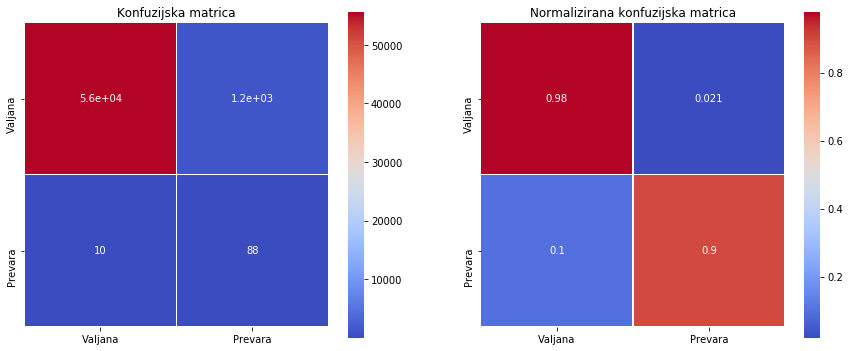

----------------------------------------------------------------------------------------------------


In [54]:
full_pred_knn = knn_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_knn, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Koristeći metodu najbližih susjeda dobili smo bolju preciznost (7.02%) i f1-mjeru (13.02%) u odnosu na većinu prethodnih klasifikatora, no također smo dobili i nešto lošiju osjetljivost (89.8%). Iz matrice konfuzije vidimo da osjetljivost nešto lošija nego kod prijašnjih klasifikatora zbog toga što je u ovom slučaju ispravno klasificirano 'samo' 88 prevara (dosad je bilo ili 89 ili 90). Doduše broj pogrešno klasificiranih valjanih transakcija je oko 1200, što je bolje od svih prethodnih klasifikatora osim slučajnih šuma. <br>
Sada ćemo podesiti parametre i vidjeti hoće li to imati ikakvog utjecaja na rezultate testiranja.

Parametri koje podešavamo kod metode najbližih susjeda:
<ul>
    <li><em>broj susjeda</em> - određuje koliko najbližih susjeda sudjeluje u 'glasanju' prilikom klasifikacije nekog primjerka</li>
    <li><em>algoritam</em> - određuje algoritam koji koristimo da bi pronašli najbliže susjede 
        <ul>
            <li><i>ball tree</i> - dijeli primjerke podataka u ugniježđene skupove hipersfera koje nazivamo loptama (balls)</li>
            <li><i>KD tree</i> - dijeli primjerke podataka u k-dimenzionalne kocke</li>
            <li><i>brute</i> - koristi dobro poznati pristup grubom silom</li>
            <li><i>auto</i> - automatski pokušava utvrditi koji je najprikladniji algoritam na temelju podataka koje prima <i>fit</i> metoda
        </ul>
    </li>
    <li><em>p (power)</em> - biramo koji algoritam koristimo da bi mjerili udaljenost
        <ul>
            <li><i>manhattan udaljenost (1)</i> - $d_1(p,q) = \sum_{i=1}^n \mid p_i - q_i \mid$</li>
            <li><i>euklidska udaljenost (2)</i> - $d_2(p,q) = \sqrt{\sum_{i=1}^n  (p_i - q_i)^2 }$</li>
        </ul>
    </li>
</ul>

In [53]:
num_neighbors_params = [1, 2, 3, 4, 5, 7, 9]
alg_params = ['auto', 'brute', 'ball_tree', 'kd_tree']
p_params = [1, 2]

knn_params = {'n_neighbors': num_neighbors_params, 'algorithm': alg_params, 'p': p_params, 'metric': ['minkowski']}

In [55]:

grid_knn = GridSearchCV(KNeighborsClassifier(), knn_params)
grid_knn.fit(X_usample_train, y_usample_train)
knn_params_usample = grid_knn.best_estimator_
knn_params_best = grid_knn.best_params_
print('Najbolji parametri: ' + str(knn_params_best))

knn_training_score_params_usample = cross_val_score(knn_params_usample, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za k (' +  str(knn_params_best['n_neighbors']) + 
      ')  najbližih susjeda nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(knn_training_score_params_usample.mean(), 4) * 100) + '%')

Najbolji parametri: {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 2, 'p': 2}
Rezultat treniranja za k (2)  najbližih susjeda nad undersampliranim datasetom (sa parametrima): 93.49%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 10.549999999999999%
	Recall score: 88.78%
	F1 score: 18.85%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.89      0.19        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.59     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


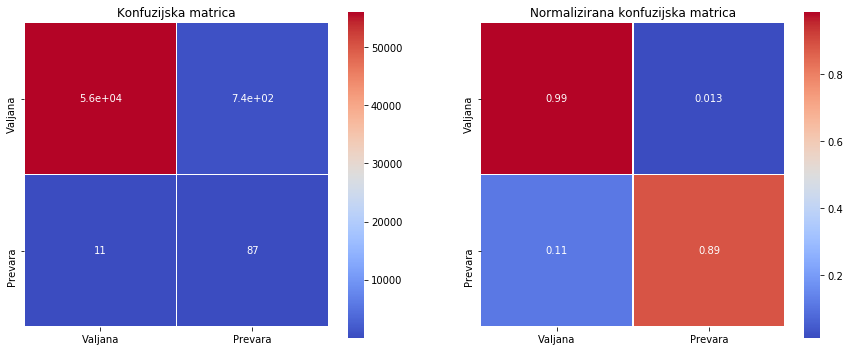

----------------------------------------------------------------------------------------------------


In [56]:
full_pred_knn_params = knn_params_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_knn_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Nakon podešavanja parametara dobili smo zanimljive rezultate. Odnosno, preciznost (10.55%) i f1-mjera su jako porasle (18.85%), a osjetljivost se malo smanjila (88.78%) u odnosu na model treniran bez parametara. Kada pogledamo matricu konfuzije vidimo da je broj pogrešno klasificiranih valjanih transakcija pao sa ~1200 na ~740 (najmanje dosad), ali se i smanjio broj ispravno klasificiranih prevara (bilo je 88, sad je 87).

## Metoda potpornih vektora

In [57]:
svc_usample = SVC()
svc_usample.fit(X_usample_train, y_usample_train)
svc_training_score_usample = cross_val_score(svc_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom: " + 
      str(round(svc_training_score_usample.mean(), 4) * 100) + '%')

Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom: 93.19%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 9.67%
	Recall score: 88.78%
	F1 score: 17.43%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.89      0.17        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.58     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


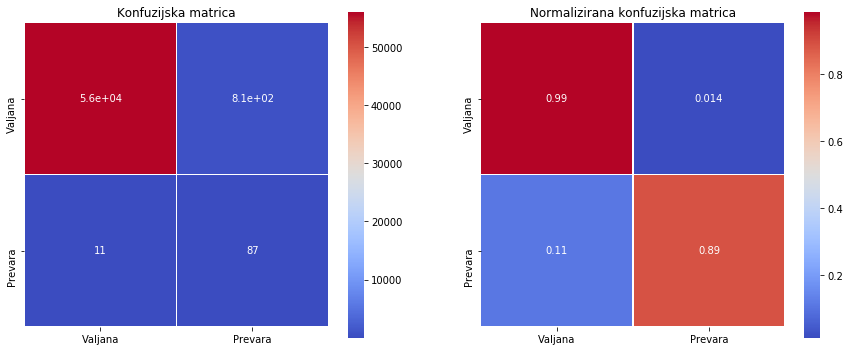

----------------------------------------------------------------------------------------------------


In [58]:
full_pred_svc = svc_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_svc, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Testiranjem na ovom modelu vidimo da smo dobili dosad najbolju (ako gledamo modele bez podešenih parametara) preciznost (9.67%) i f1-mjeru (17.43%), dok je osjetljivost 88.78%. Iz konfuzijske matrice vidimo da je model ispravno klasificirao 87 prevara (što je najmanje dosad), ali je također pogrešno klasificirao svega oko 810 valjanih transakcija (prvi koji ima manje od 1000).
<br> Pokušat ćemo pažljivo podesiti parametre pa vidjeti hoće li to dodatno popraviti rezultate.

Parametri koje podešavamo za metodu potpornih vektora:
<ul>
    <li><em>C</em> - regularizacijski parametar, ima istu ulogu kao i u logističkoj regresiji</li>
    <li><em>kernel</em> - određuje funkciju koja omogućava rad u više-dimenzionalnom prostoru bez da ikad izračuna koordinate u tom višedimenzionalnom prostoru, već koristi unutarnje produkte slika svih parova podataka u prostoru značajki
        <ul>
            <li><i>linear</i> - koristi linearnu plohu da podijeli podatke, formula: $K(X,Y) = X^TY$</li>
            <li><i>poly</i> - koristi polinom da podijeli podatke, formula: $K(X,Y) = (\gamma \cdot X^TY + r)^d$</li>
            <li><i>sigmoid</i> - koristi sigmoidalnu funkciju da podijeli podatke, formula: $K(X,Y) = \tanh(\gamma \cdot X^TY + r)$</li>
            <li><i>rbf</i> -  koristi krivulje koje okružuju podatke i sumira ih tako da granica podjele bude definirana topološkim uvjetom, formula: $K(X,Y) = \exp \bigg( \frac{\mid \mid X - Y\mid \mid^2}{2\sigma^2} \bigg)$</li>
        </ul>
    <li><em>stupanj</em> (u formuli za <i>poly</i> označen s d) - određuje stupanj polinoma</li>
    <li><em>gamma</em> (u formulama za <i>poly</i> i <i>sigmoid</i> označen s $\gamma$) - određuje koeficijent</li>
</ul>

In [59]:
svc_c_params = [0.001, 0.01, 0.1, 1, 10, 1]
kernel_params = ['linear', 'poly', 'sigmoid', 'rbf']
degree_params = [1, 2, 3, 4, 5]
gamma_params = ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10]
svc_params = {'C': svc_c_params, 'kernel': kernel_params, 'degree': degree_params, 'gamma': gamma_params }

In [59]:

grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_usample_train, y_usample_train)
svc_params_usample = grid_svc.best_estimator_
svc_params_best = grid_svc.best_params_
print('Najbolji parametri: ' + str(svc_params_best))

svc_training_score_params_usample = cross_val_score(svc_params_usample, X_usample_train, y_usample_train, cv=rskf)
print('Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(svc_training_score_params_usample.mean(), 4) * 100) + '%')

Najbolji parametri: {'C': 0.001, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}
Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom (sa parametrima): 94.04%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 9.85%
	Recall score: 89.8%
	F1 score: 17.76%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.90      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.59     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


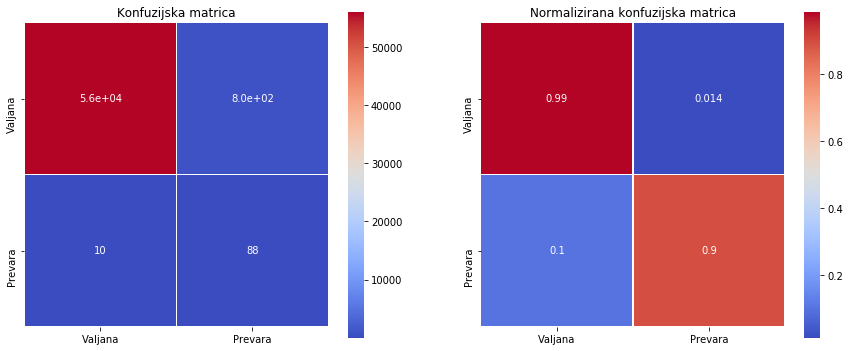

----------------------------------------------------------------------------------------------------


In [60]:
full_pred_svc_params = svc_params_usample.predict(X_data_test)
print_everything(y_data_test, full_pred_svc_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Podešavanje parametara je napravilo dosta za ovaj model. I preciznost (9.85%), i f1-mjera (17.76%), i osjetljivost (89.8%) su porasli. Nijedan od tih skokova nije velik, ali je ipak u sve tri kateogrije. Iz matrice konfuzije vidimo da imamo 88 ispravno klasificiranih prevara (bilo je 87), te ~800 pogrešno klasificiranih valjanih transakcija (bilo je ~800). 

## Boosting

Za boosting ćemo koristiti 4 različita algoritma te usporediti njihove rezultate. Algoritmi koje koristimo su:
<ol>
    <li>XGB (eXtreme Gradient Boosting)</li>
    <li>LGBM (Light Gradient Boosting Method)</li>
    <li>CatBoost (CATegorical Boosting)</li>
    <li>AdaBoost (ADAptive Boosting)</li>
</ol>

In [65]:
print("XGB (eXtreme Gradient Boosting)")
xgb_usample = XGBClassifier()
xgb_usample.fit(X_usample_train, y_usample_train)
xgb_usample_training_score = cross_val_score(xgb_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za XGB (extreme gradient boosting) nad undersampliranim datasetom: " + 
       str(round(xgb_usample_training_score.mean(), 4) * 100) + '%')

print('-'*100)
print("LGBM (Light Gradient Boosting Method)")
lgbm_usample = LGBMClassifier()
lgbm_usample.fit(X_usample_train, y_usample_train)
lgbm_usample_training_score = cross_val_score(lgbm_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za LGBM (light gradient boosting) nad undersampliranim datasetom: " + 
       str(round(lgbm_usample_training_score.mean(), 4) * 100) + '%')

print('-'*100)
print("CatBoost (CATegorical Boosting)")
cat_usample = CatBoostClassifier(silent=True)
cat_usample.fit(X_usample_train, y_usample_train)
cat_usample_training_score = cross_val_score(cat_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za CatBoost (categorical boosting) nad undersampliranim datasetom: " + 
       str(round(cat_usample_training_score.mean(), 4) * 100) + '%')

print('-'*100)
print("AdaBoost (ADAptive Boosting)")
ada_usample = AdaBoostClassifier()
ada_usample.fit(X_usample_train, y_usample_train)
ada_usample_training_score = cross_val_score(ada_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za AdaBoost (adaptive boosting) nad undersampliranim datasetom: " + 
       str(round(ada_usample_training_score.mean(), 4) * 100) + '%')

XGB (eXtreme Gradient Boosting)
Rezultat treniranja za XGB (extreme gradient boosting) nad undersampliranim datasetom: 92.94%
----------------------------------------------------------------------------------------------------
LGBM (Light Gradient Boosting Method)
Rezultat treniranja za LGBM (light gradient boosting) nad undersampliranim datasetom: 93.28%
----------------------------------------------------------------------------------------------------
CatBoost (CATegorical Boosting)
Rezultat treniranja za CatBoost (categorical boosting) nad undersampliranim datasetom: 93.65%
----------------------------------------------------------------------------------------------------
AdaBoost (ADAptive Boosting)
Rezultat treniranja za AdaBoost (adaptive boosting) nad undersampliranim datasetom: 92.01%


****************************************************************************************************
XGB (eXtreme Gradient Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.54%
	Recall score: 92.86%
	F1 score: 10.45%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.93      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


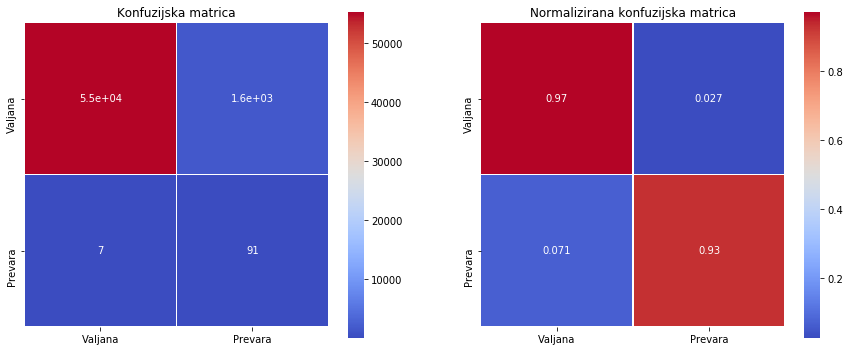

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
LGBM (Light Gradient Boosting Method)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.7%
	Recall score: 91.84%
	F1 score: 10.73%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962


----------------------------------------------------------------------------------------------------


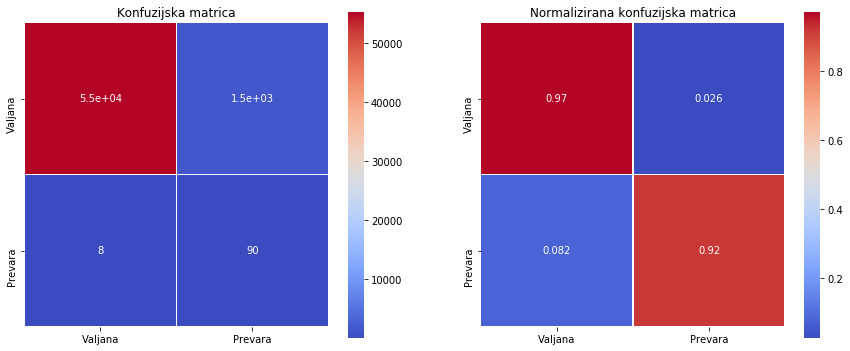

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
CatBoost (Categorical Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.290000000000001%
	Recall score: 91.84%
	F1 score: 15.22%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.92      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


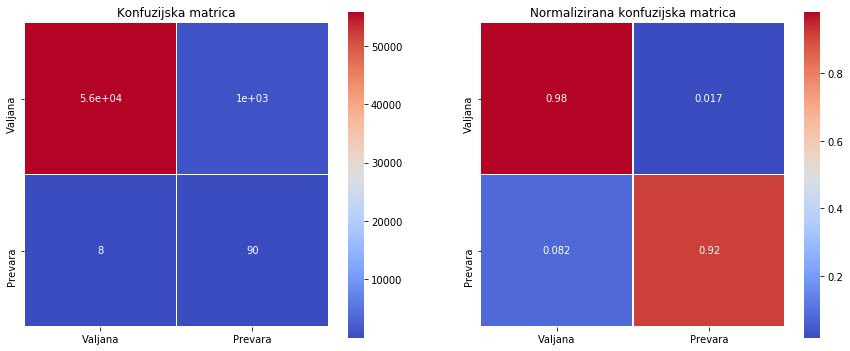

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
AdaBoost (Adaptive Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 2.86%
	Recall score: 91.84%
	F1 score: 5.55%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.92      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.93      0.51     56962
weighted avg       1.00      0.95      0.97     56962


----------------------------------------------------------------------------------------------------


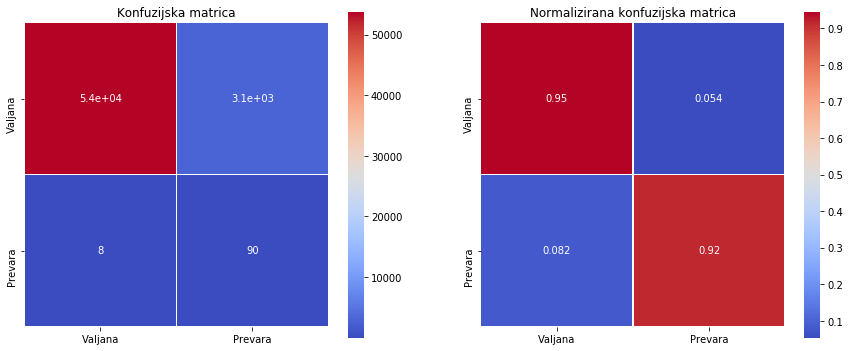

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [66]:
full_pred_xgb = xgb_usample.predict(X_data_test)
full_pred_lgbm = lgbm_usample.predict(X_data_test)
full_pred_cat = cat_usample.predict(X_data_test)
full_pred_ada = ada_usample.predict(X_data_test)

print('*'*100)
print("XGB (eXtreme Gradient Boosting)")
print_everything(y_data_test, full_pred_xgb, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("LGBM (Light Gradient Boosting Method)")
print_everything(y_data_test, full_pred_lgbm, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("CatBoost (Categorical Boosting)")
print_everything(y_data_test, full_pred_cat, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("AdaBoost (Adaptive Boosting)")
print_everything(y_data_test, full_pred_ada, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('*'*100)

Prokomentirajmo sada rezultate. <br>
<ol>
    <li><em>XGB</em>
        <p>Koristeći XGB dobili smo jako dobre rezultate testiranja. Preciznost je 5.54%, f1-mjera 10.45%, a osjetljivost je vrlo visokih 92.86%. Iz matrice konfuzije vidimo da je pogrešno klasificirano oko 1600 valjanih transakcija (što je bolje od većine algoritama dosad), dok je ispravno klasificirano čak 91 prevara (što je najviše dosad).</p>
    </li><br><hr>
    <li><em>LGBM</em>
        <p>Korištenjem LGBM-a smo također dobili jako dobre rezultate. Preciznost (5.7%) i f1-mjera(10.73%) su malo viši nego kod XGB-a, dok je osjetljivost (91.84%) malo niža. Iz matrice konfuzije vidimo da je pogrešno klasificirano oko 1500 valjanih transakcija (stotinjak manje nego kod XGB-a), dok je ispravno klasificirano 90 prevara (jedna manje nego kod XGB-a).</p>
    </li><br><hr>
    <li><em>CatBoost</em>
        <p>Sljedeći algoritam boostinga je CatBoost. Njime smo dobili još bolje rezultate nego LGBM-om. Tako je u ovom slučaju preciznost čak 8.29%, a f1-mjera 15.22%, dok je osjetljivost 91.84% (isto kao i kod LGBM-a). Iz matrice konfuzije vidimo da je pogrešno klasificirano oko 1000 valjanih transakcija (petstotinjak manje nego kod LGBM-a, odnosno trećina manje), dok je ispravno klasificirano 90 prevara (isto kao i kod LGBM-a). </p>
    </li><br><hr>
    <li><em>AdaBoost</em>
        <p>Posljednji algoritam boostinga koji koristimo je AdaBoost. On se pokazao kao najslabiji od boosting algoritama. U ovom slučaju preciznost samo 2.86%, a f1-mjera 5.55%, dok je osjetljivost 91.84% (isto kao i kod LGBM-a, te CatBoosta). Iz matrice konfuzije vidimo da je pogrešno klasificirano oko 3100 valjanih transakcija (triput više nego kod CatBoosta), dok je ispravno klasificirano 90 prevara (isto kao i kod CatBoosta). </p>
    </li>
    
    
</ol>
<br> <hr>
Sada ćemo za sva 4 boosting algoritma podesiti parametre te vidjeti kako će to utjecati na rezultate.


Parametri koje podešavamo kod XGB-a:
<ul>
    <li><em>gamma</em> - regularizacijski parametar 'kroz sva stabla'</li>
    <li><em>maksimalna dubina</em> - maksimalna dubina svakog stabla</li>
    <li><em>udio stupaca po stablu</em> - udio značajki koje upotrebljavamo za konstrukciju svakog novog stabla</li>
    <li><em>stopa učenja</em> - određuje koliko koraka treba napraviti (što je stopa manja, imamo više koraka, odnosno sporije učenje, ali možda i precizniji model)</li>
    <li><em>broj procjenitelja</em> - broj stabala koji koristimo prilikom treniranja</li>
</ul>

In [5]:
xgb_gamma = [0, 1, 5, 10]
xgb_max_depth = [1, 2, 3, 4, 5, 7]
xgb_colsample_bytree = [0.3, 0.5, 0.8]
xgb_learning_rate = [0.3, 0.1, 0.05, 0.01]
xgb_n_estimators = [10, 20, 50, 100]
xgb_params = {'gamma': xgb_gamma, 'max_depth': xgb_max_depth, 'colsample_bytree': xgb_colsample_bytree, 
              'learning_rate': xgb_learning_rate, 'n_estimators': xgb_n_estimators}

In [67]:
grid_xgb = GridSearchCV(XGBClassifier(), xgb_params)
grid_xgb.fit(X_usample_train, y_usample_train)
xgb_params_usample = grid_xgb.best_estimator_
xgb_params_best = grid_xgb.best_params_

Parametri koje podešavamo kod LGBM-a:
<ul>
    <li><em>tip boostinga</em> - određuje koji od sljedećih algoritama koristimo za boosting
        <ul>
            <li><i>gdbt (Gradient Boosting Decision Tree)</i> - tradicionalna stabla odluke trenirana u nekom određenom  redoslijedu (u svakom koraku model pokušava naučiti razliku između stvarnog izlaza i težinske sume predikcija prethodne iteracije)</li>
            <li><i>goss (Gradient-based One Sided Sampling)</i> -  metoda koja se zasniva na odbacivanju instanci s malim gradijentom (jer su te već dobro trenirane), te se fokusira samo na one s većim gradijentom</li>
            <li><i>rf (Random Forest)</i> - klasičan pristup korištenjem slučajnih šuma</li>
            <li><i>dart (Dropouts meets multiple Additive Regression Trees)</i> - novija metoda u koju je dropout tehnika korištena najviše kod dubokih neuronskih mreža</li>
        </ul>
    </li>
    <li><em>maksimalna dubina</em> - ima isto značenje kao i kod XGB-a</li>
    <li><em>udio stupaca po stablu</em> - ima isto značenje kao i kod XGB-a</li>
    <li><em>stopa učenja</em> - ima isto značenje kao i kod XGB-a</li>
    <li><em>broj procjenitelja</em> - ima isto značenje kao i kod XGB-a</li>
</ul>

In [6]:
lgbm_boosting_type = ['gbdt', 'goss', 'rf', 'dart']
lgbm_max_depth = xgb_max_depth
lgbm_learning_rate = xgb_learning_rate
lgbm_colsample_bytree = xgb_colsample_bytree
lgbm_n_estimators = xgb_n_estimators
lgbm_params = {'boosting_type': lgbm_boosting_type, 'max_depth': lgbm_max_depth, 'colsample_bytree': lgbm_colsample_bytree, 
               'learning_rate': lgbm_learning_rate, 'n_estimators': lgbm_n_estimators}


In [68]:

grid_lgbm = GridSearchCV(LGBMClassifier(), lgbm_params)
grid_lgbm.fit(X_usample_train, y_usample_train)
lgbm_params_usample = grid_lgbm.best_estimator_
lgbm_params_best = grid_lgbm.best_params_

C:\Users\stvar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\stvar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 805, in fit
    callbacks=callbacks)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 600, in fit
    callbacks=callbacks)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\basic.py", line 1716, in __init__
    ctypes.byref(self.handle)))
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\basic.py", li

Parametri koje podešavamo kod CatBoosta:
<ul>
    <li><em>dubina</em> - isto značenje kao i kod XGB-a</li>
    <li><em>stopa učenja</em> - isto značenje kao i kod XGB-a</li>
    <li><em>broj procjenitelja</em> - isto značenje kao i kod XGB-a</li>
</ul>

In [7]:
cat_depth = xgb_max_depth
cat_learning_rate = xgb_learning_rate
cat_n_estimators = xgb_n_estimators
cat_params = {'depth': cat_depth, 'learning_rate': cat_learning_rate, 'n_estimators': cat_n_estimators }

In [69]:

grid_cat = GridSearchCV(CatBoostClassifier(silent=True), cat_params)
grid_cat.fit(X_usample_train, y_usample_train)
cat_params_usample = grid_cat.best_estimator_
cat_params_best = grid_cat.best_params_


Parametri koje podešavamo kod AdaBoosta:
<ul>
    <li><em>procjenitelj</em> - procjenitelj kojeg AdaBoost koristi (u našem slučaju stablo odluke)
        <ul>
            <li><i>kriterij</i> - ima isto značenje kao i za stablo odluke</li>
            <li><i>splitter</i> - ima isto značenje kao i za stablo odluke</li>
            <li><i>maksimalna dubina</i> - ima isto značenje kao i za stablo odluke</li>
        </ul>
    </li>
    <li><em>stopa učenja</em> - ima isto značenje kao i kod XGB-a</li>
    <li><em>broj procjenitelja</em> - ima isto značenje kao i kod XGB-a</li>
</ul>

In [8]:
ada_criterion = ['gini', 'entropy']
ada_max_depth = xgb_max_depth
ada_splitter = ['best', 'random']
ada_n_estimators = xgb_n_estimators
ada_learning_rate = xgb_learning_rate
ada_params = {'n_estimators': ada_n_estimators, 'learning_rate': ada_learning_rate}

ada_params = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "base_estimator__max_depth": xgb_max_depth,
              "n_estimators": xgb_n_estimators,
              "learning_rate": xgb_learning_rate
             }

In [70]:
grid_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier()), ada_params)
grid_ada.fit(X_usample_train, y_usample_train)
ada_params_usample = grid_ada.best_estimator_
ada_params_best = grid_ada.best_params_

In [71]:
xgb_training_score_params_usample = cross_val_score(xgb_params_usample, X_usample_train, y_usample_train, cv=rskf)
lgbm_training_score_params_usample = cross_val_score(lgbm_params_usample, X_usample_train, y_usample_train, cv=rskf)
cat_training_score_params_usample = cross_val_score(cat_params_usample, X_usample_train, y_usample_train, cv=rskf)
ada_training_score_params_usample = cross_val_score(ada_params_usample, X_usample_train, y_usample_train, cv=rskf)

print('Treniranje (sa parametrima)')
print('-'*100)
print('XGB')
print('Najbolji parametri: ' + str(xgb_params_best))
print('Rezultat treniranja: ' + str(round(xgb_training_score_params_usample.mean(), 4) * 100) + '%')
print('-'*100)
print('LGBM')
print('Najbolji parametri: ' + str(lgbm_params_best))
print('Rezultat treniranja: ' + str(round(lgbm_training_score_params_usample.mean(), 4) * 100) + '%')
print('-'*100)
print('CatBoost')
print('Najbolji parametri: ' + str(cat_params_best))
print('Rezultat treniranja: ' + str(round(cat_training_score_params_usample.mean(), 4) * 100) + '%')
print('-'*100)
print('AdaBoost')
print('Najbolji parametri: ' + str(ada_params_best))
print('Rezultat treniranja: ' + str(round(ada_training_score_params_usample.mean(), 4) * 100) + '%')


Treniranje (sa parametrima)
----------------------------------------------------------------------------------------------------
XGB
Najbolji parametri: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 100}
Rezultat treniranja: 93.32000000000001%
----------------------------------------------------------------------------------------------------
LGBM
Najbolji parametri: {'boosting_type': 'goss', 'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100}
Rezultat treniranja: 93.66%
----------------------------------------------------------------------------------------------------
CatBoost
Najbolji parametri: {'depth': 5, 'learning_rate': 0.05, 'n_estimators': 100}
Rezultat treniranja: 93.74%
----------------------------------------------------------------------------------------------------
AdaBoost
Najbolji parametri: {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 4, 'base_estimator__splitter':

****************************************************************************************************
XGB (eXtreme Gradient Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.2299999999999995%
	Recall score: 93.88%
	F1 score: 9.91%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.94      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


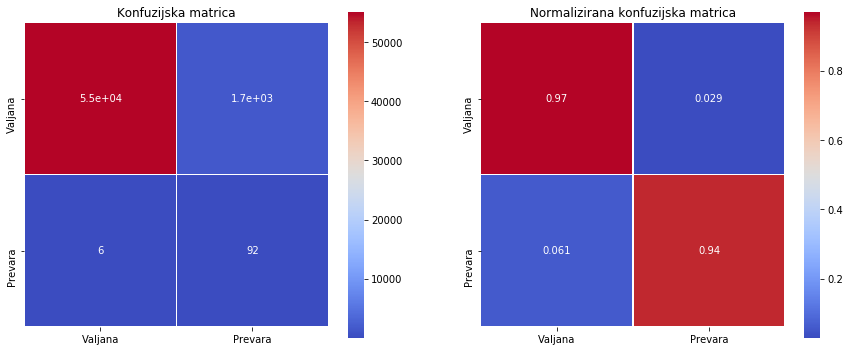

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
LGBM (Light Gradient Boosting Method)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 7.9399999999999995%
	Recall score: 92.86%
	F1 score: 14.63%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.93      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.96      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


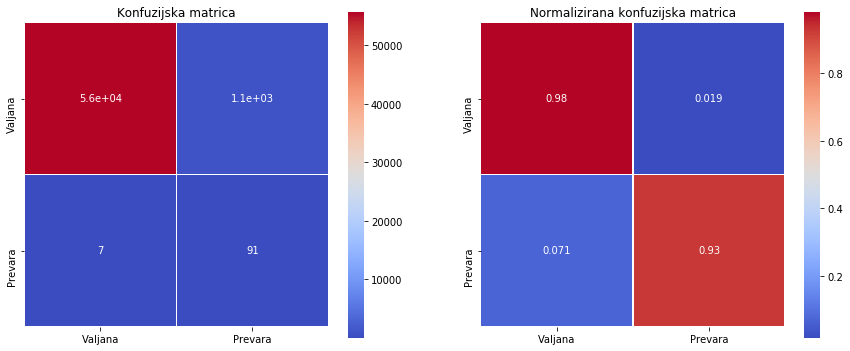

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
CatBoost (Categorical Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 9.13%
	Recall score: 90.82000000000001%
	F1 score: 16.59%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.91      0.17        98

    accuracy                           0.98     56962
   macro avg       0.55      0.95      0.58     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


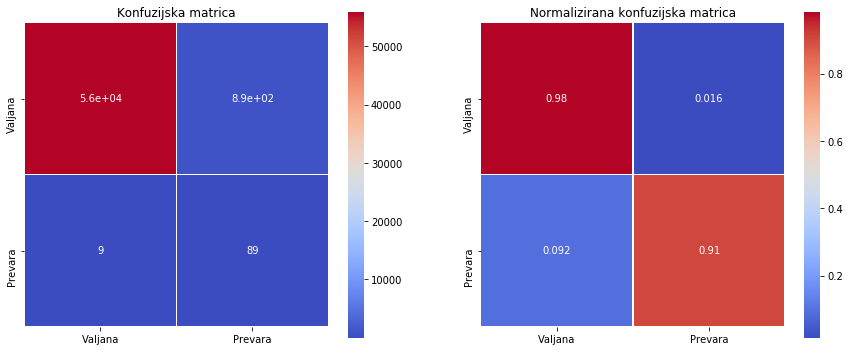

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
AdaBoost (Adaptive Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.790000000000001%
	Recall score: 90.82000000000001%
	F1 score: 16.02%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.91      0.16        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.58     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


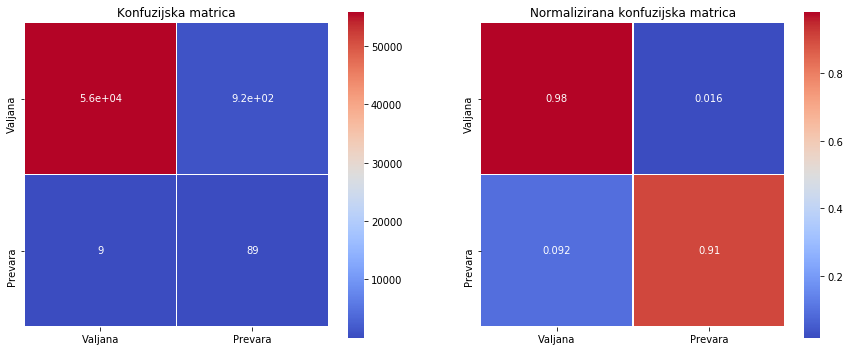

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [72]:
full_pred_xgb_params = xgb_params_usample.predict(X_data_test)
full_pred_lgbm_params = lgbm_params_usample.predict(X_data_test)
full_pred_cat_params = cat_params_usample.predict(X_data_test)
full_pred_ada_params = ada_params_usample.predict(X_data_test)

print('*'*100)
print("XGB (eXtreme Gradient Boosting)")
print_everything(y_data_test, full_pred_xgb_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("LGBM (Light Gradient Boosting Method)")
print_everything(y_data_test, full_pred_lgbm_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("CatBoost (Categorical Boosting)")
print_everything(y_data_test, full_pred_cat_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("AdaBoost (Adaptive Boosting)")
print_everything(y_data_test, full_pred_ada_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('*'*100)

Prokomentirajmo sada rezultate. <br>
<ol>
    <li><em>XGB</em>
        <p>Nakon podešavanja parametara XGB je ponovno imao dobre rezultate. Preciznost (5.23%) i f1-mjera (9.91%) su se malo smanjile u odnosu na model bez parametara, no zato je osjetljivost porasla (sada je 93.88%). Iz matrice konfuzije vidimo da je ovaj model ispravno klasificirao čak 92 prevare, dok je pogrešno klasificirao oko 1700 valjanih transakcija. U odnosu na model bez parametara sada imamo 1 ispravno klasificiranu prevaru više, te stotinjak pogrešno klasificiranih valjanih transakcija više. </p>
    </li><br><hr>
    <li><em>LGBM</em>
        <p>Podešavanjem parametara kod LGBM-a smo dobili vidljivo bolje rezultate. I preciznost (7.94%) i f1-mjera (14.63%) su se poboljšale, no zanimljivo je da je i osjetljivost (92.86%) porasla. Iz matrice konfuzije vidimo da sada imamo 91 ispravno klasificiranu prevaru (bez parametara je bilo 90) te svega oko 1100 pogrešno klasificiranih valjanih transakcija (bez parametara je bilo oko 1500). Znači model je bolji od onog bez parametara u svim kategorijama.</p>
    </li><br><hr>
    <li><em>CatBoost</em>
        <p> Kod CatBoosta smo dobili solidne rezultate. I ovdje su i preciznost (9.13%) i f1-mjera (16.59%) porasle, no osjetljivost (90.82%) je malo pala. Iz matrice konfuzije vidimo da je ovaj model ispravno klasificirao 89 prevara (jednu manje u odnosu na model bez parametara), ali je pogrešno klasificirao samo ~890 valjanih transakcija (oko 110 manje nego bez parametara). </p>
    </li><br><hr>
    <li><em>AdaBoost</em>
        <p>Adaboost je algoritam koji se podeašavanjem parametara najznačajnije popravio. I preciznost (8.79%) i f1-mjera (16.02%) su jako skočile (preciznost je bila 2.86%, a f1-mjera 5.55%). Osjetljivost je doduše blago pala i sad je 90.82%. Iz matrice konfuzije vidimo da je model ispravno klasificirao 89 prevara (samo jednu manje nego model bez parametara), dok je pogrešno klasificirao svega ~920 valjanih transakcija (bilo je čak ~3100). </p>
    </li> 
</ol>



## Metoda klasifikcije glasanjem

Zadnji klasifikator koji ćemo koristiti je klasifikacija glasanjem. Promatrat ćemo 11 različitih klasifikatora.
<ol>
    <li><em>Prvi glasački klasifikator (1)</em> - glasači: 
        <ul>
            <li>Logistička regresija</li>
            <li>XGB</li>
            <li>Slučajne šume</li>
        </ul>
    </li> <hr>
    <li><em>Drugi glasački klasifikator (2)</em> - glasači: 
        <ul>
            <li>Logistička regresija</li>
            <li>XGB</li>
            <li>Slučajne šume</li>
            <li>Metoda potpornih vektora</li>
        </ul>
    </li> <hr>
    <li><em>Treći glasački klasifikator (3)</em> - glasači: 
        <ul>
            <li>Logistička regresija</li>
            <li>XGB</li>
            <li>Slučajne šume</li>
            <li>Metoda potpornih vektora</li>
            <li>Metoda najbližih susjeda
        </ul>
    </li> <hr>
    <li><em>Četvrti glasački klasifikator (4)</em> - glasači: 
        <ul>
            <li>Logistička regresija</li>
            <li>LGBM</li>
            <li>Slučajne šume</li>
        </ul>
    </li> <hr>
    <li><em>Peti glasački klasifikator (5)</em> - glasači: 
        <ul>
            <li>LGBM</li>
            <li>Slučajne šume</li>
        </ul>
    </li> <hr>
    <li><em>Šesti glasački klasifikator (6)</em> - glasači: 
        <ul>
            <li>Bagging</li>
            <li>Stabla odluke</li>
        </ul>
    </li> <hr>
    <li><em>Sedmi glasački klasifikator (7)</em> - glasači: 
        <ul>
            <li>Bagging</li>
            <li>Metoda najbližih susjeda</li>
        </ul>
    </li> <hr>
    <li><em>Osmi glasački klasifikator (8)</em> - glasači: 
        <ul>
            <li>Slučajne šume</li>
            <li>Metoda najbližih susjeda</li>
        </ul>
    </li> <hr>
    <li><em>Deveti glasački klasifikator (9)</em> - glasači: 
        <ul>
            <li>Slučajne šume</li>
            <li>Metoda najbližih susjeda</li>
            <li>CatBoost</li>
        </ul>
    </li> <hr>
    <li><em>Deseti glasački klasifikator (10)</em> - glasači: 
        <ul>
            <li>Slučajne šume</li>
            <li>Metoda potpornih vektora</li>
            <li>AdaBoost</li>
        </ul>
    </li> <hr>
    <li><em>Jedanaesti glasački klasifikator (11)</em> - glasači: 
        <ul>
            <li>XGB</li>
            <li>LGBM</li>
            <li>CatBoost</li>
            <li>AdaBoost</li>
        </ul>
    </li>
</ol>

In [73]:
print('(1) = logistička regresija, xgb, random forest')
print('(2) = logistička regresija, xgb, random forest, metoda potpornih vektora')
print('(3) = logistička regresija, xgb, random forest, metoda potpornih vektora, k (' + str(knn_params_best['n_neighbors']) + ') najbližih susjeda')
print('(4) = logistička regresija, lgbm, random forest')
print('(5) = lgbm, random forest')
print('(6) = bagging, decision trees')
print('(7) = bagging, k (' + str(knn_params_best['n_neighbors']) + ') najbližih susjeda')
print('(8) = random forest, k (' + str(knn_params_best['n_neighbors']) + ') najbližih susjeda')
print('(9) = random forest, k (' + str(knn_params_best['n_neighbors']) + ') najbližih susjeda, catboost')
print('(10) = random forest, metoda potpornih vektora, adaboost')
print('(11) = xgb, lgbm, catboost, adaboost')
print('-'*100)

voting1_usample = VotingClassifier(estimators=[
    ('log_reg', log_reg_params_usample), ('xgb', xgb_params_usample), 
    ('rf', rf_params_usample)
])
voting1_usample.fit(X_usample_train, y_usample_train)
voting1_usample_training_score = cross_val_score(voting1_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (1) nad undersampliranim datasetom: " + 
      str(round(voting1_usample_training_score.mean(), 4) * 100) + '%')


voting2_usample = VotingClassifier(estimators=[
    ('log_reg', log_reg_params_usample), ('xgb', xgb_params_usample), 
    ('rf', rf_params_usample), ('svc', svc_params_usample)
])
voting2_usample.fit(X_usample_train, y_usample_train)
voting2_usample_training_score = cross_val_score(voting2_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (2) nad undersampliranim datasetom: " + 
      str(round(voting2_usample_training_score.mean(), 4) * 100) + '%')

voting3_usample = VotingClassifier(estimators=[
    ('log_reg', log_reg_params_usample), ('xgb', xgb_params_usample), 
    ('rf', rf_params_usample), ('svc', svc_params_usample), ('knn', knn_params_usample)
])
voting3_usample.fit(X_usample_train, y_usample_train)
voting3_usample_training_score = cross_val_score(voting3_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (3) nad undersampliranim datasetom: " + 
      str(round(voting3_usample_training_score.mean(), 4) * 100) + '%')

voting4_usample = VotingClassifier(estimators=[
    ('log_reg', log_reg_params_usample), ('lgbm', lgbm_params_usample), 
    ('rf', rf_params_usample)
])
voting4_usample.fit(X_usample_train, y_usample_train)
voting4_usample_training_score = cross_val_score(voting4_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (4) nad undersampliranim datasetom: " + 
      str(round(voting4_usample_training_score.mean(), 4) * 100) + '%')

voting5_usample = VotingClassifier(estimators=[ ('lgbm', lgbm_params_usample), 
    ('rf', rf_params_usample)
])
voting5_usample.fit(X_usample_train, y_usample_train)
voting5_usample_training_score = cross_val_score(voting5_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (5) nad undersampliranim datasetom: " + 
      str(round(voting5_usample_training_score.mean(), 4) * 100) + '%')


voting6_usample = VotingClassifier(estimators=[
    ('bag', bag_params_usample), ('dt', dt_params_usample)
])
voting6_usample.fit(X_usample_train, y_usample_train)
voting6_usample_training_score = cross_val_score(voting6_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (6) nad undersampliranim datasetom: " + 
      str(round(voting6_usample_training_score.mean(), 4) * 100) + '%')

voting7_usample = VotingClassifier(estimators=[
    ('bag', bag_params_usample), ('knn', knn_params_usample), 
])
voting7_usample.fit(X_usample_train, y_usample_train)
voting7_usample_training_score = cross_val_score(voting7_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (7) nad undersampliranim datasetom: " + 
      str(round(voting7_usample_training_score.mean(), 4) * 100) + '%')

voting8_usample = VotingClassifier(estimators=[
    ('rf', rf_params_usample), ('knn', knn_params_usample), 
])
voting8_usample.fit(X_usample_train, y_usample_train)
voting8_usample_training_score = cross_val_score(voting8_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (8) nad undersampliranim datasetom: " + 
      str(round(voting8_usample_training_score.mean(), 4) * 100) + '%')

voting9_usample = VotingClassifier(estimators=[
    ('rf', rf_params_usample), ('knn', knn_params_usample), ('cat', cat_params_usample) 
])
voting9_usample.fit(X_usample_train, y_usample_train)
voting9_usample_training_score = cross_val_score(voting9_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (9) nad undersampliranim datasetom: " + 
      str(round(voting9_usample_training_score.mean(), 4) * 100) + '%')

voting10_usample = VotingClassifier(estimators=[
    ('rf', rf_params_usample), ('svc', knn_params_usample), ('ada', ada_params_usample) 
])
voting10_usample.fit(X_usample_train, y_usample_train)
voting10_usample_training_score = cross_val_score(voting10_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (10) nad undersampliranim datasetom: " + 
      str(round(voting10_usample_training_score.mean(), 4) * 100) + '%')

voting11_usample = VotingClassifier(estimators=[
    ('xgb', xgb_params_usample), ('lgbm', lgbm_params_usample), ('cat', cat_params_usample),
    ('ada', ada_params_usample)
])
voting11_usample.fit(X_usample_train, y_usample_train)
voting11_usample_training_score = cross_val_score(voting11_usample, X_usample_train, y_usample_train, cv=rskf)
print("Rezultat treniranja za metodu glasanja (11) nad undersampliranim datasetom: " + 
      str(round(voting11_usample_training_score.mean(), 4) * 100) + '%')

(1) = logistička regresija, xgb, random forest
(2) = logistička regresija, xgb, random forest, metoda potpornih vektora
(3) = logistička regresija, xgb, random forest, metoda potpornih vektora, k (2) najbližih susjeda
(4) = logistička regresija, lgbm, random forest
(5) = lgbm, random forest
(6) = bagging, decision trees
(7) = bagging, k (2) najbližih susjeda
(8) = random forest, k (2) najbližih susjeda
(9) = random forest, k (2) najbližih susjeda, catboost
(10) = random forest, metoda potpornih vektora, adaboost
(11) = xgb, lgbm, catboost, adaboost
----------------------------------------------------------------------------------------------------
Rezultat treniranja za metodu glasanja (1) nad undersampliranim datasetom: 93.91000000000001%
Rezultat treniranja za metodu glasanja (2) nad undersampliranim datasetom: 93.99%
Rezultat treniranja za metodu glasanja (3) nad undersampliranim datasetom: 94.28999999999999%
Rezultat treniranja za metodu glasanja (4) nad undersampliranim datasetom:

****************************************************************************************************
Glasački klasifikator (1)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.58%
	Recall score: 90.82000000000001%
	F1 score: 15.68%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.91      0.16        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


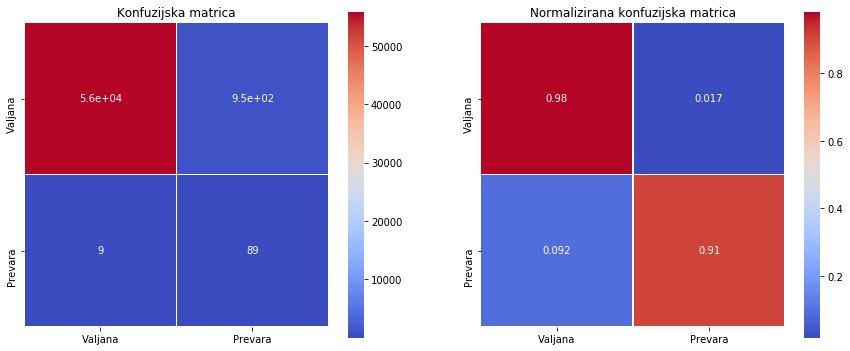

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Glasački klasifikator (2)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 12.809999999999999%
	Recall score: 90.82000000000001%
	F1 score: 22.45%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.91      0.22        98

    accuracy                           0.99     56962
   macro avg       0.56      0.95      0.61     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


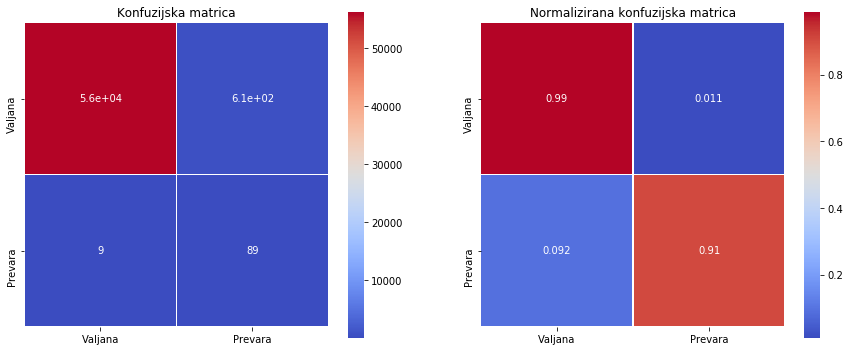

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Glasački klasifikator (3)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 10.6%
	Recall score: 89.8%
	F1 score: 18.970000000000002%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.90      0.19        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.59     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


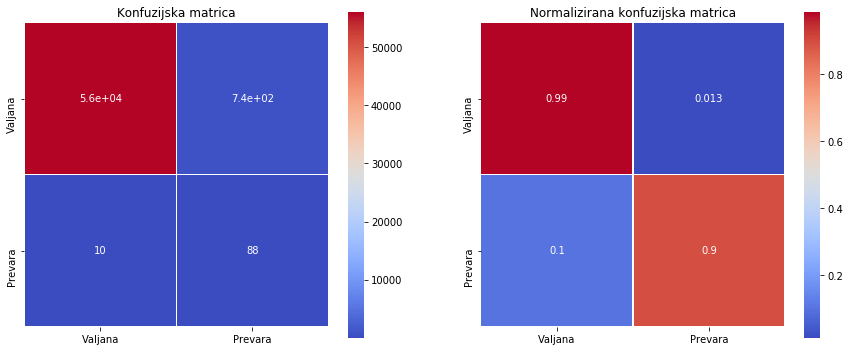

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Glasački klasifikator (4)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.709999999999999%
	Recall score: 90.82000000000001%
	F1 score: 15.89%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.91      0.16        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.58     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


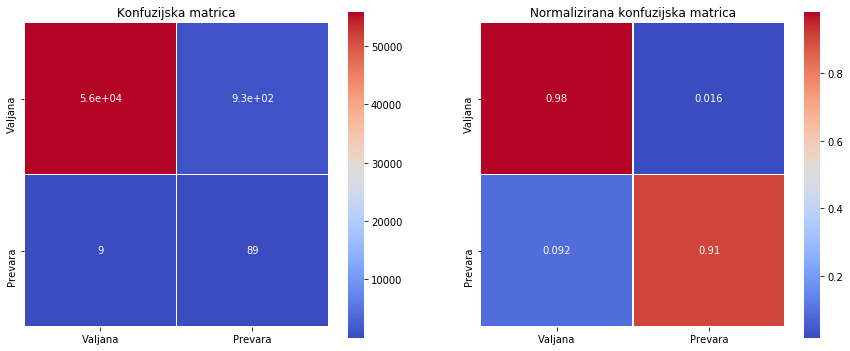

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [74]:
full_pred_voting1_params = voting1_usample.predict(X_data_test)
full_pred_voting2_params = voting2_usample.predict(X_data_test)
full_pred_voting3_params = voting3_usample.predict(X_data_test)
full_pred_voting4_params = voting4_usample.predict(X_data_test)

print('*'*100)
print('Glasački klasifikator (1)')
print_everything(y_data_test, full_pred_voting1_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("Glasački klasifikator (2)")
print_everything(y_data_test, full_pred_voting2_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("Glasački klasifikator (3)")
print_everything(y_data_test, full_pred_voting3_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("Glasački klasifikator (4)")
print_everything(y_data_test, full_pred_voting4_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('*'*100)

Komentari za prva 4 glasačka klasifikatora: <br>
<ul>
    <li><em>Prvi glasački klasifikator (1)</em> - solidan klasifikator sa sljedećim rezultatima:
        <ul>
            <li><i>preciznost</i>: 8.58%</li>
            <li><i>osjetljivost</i>: 90.82%</li>
            <li><i>f1-mjera</i>: 15.68%</li>
            <li><i>ispravno klasificirane prevare</i>: 89</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~950</li>
        </ul>
    </li>
    <li><em>Drugi glasački klasifikator (2)</em> - dosta bolji od prvog klasifikatora sa sljedećim rezultatima:
        <ul>
            <li><i>preciznost</i>: 12.81%</li>
            <li><i>osjetljivost</i>: 90.82%</li>
            <li><i>f1-mjera</i>: 22.45%</li>
            <li><i>ispravno klasificirane prevare</i>: 89 (jednako kao i prvi)</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~610 (~340 manje od prvog)</li>
        </ul>
    </li>
    <li><em>Treći glasački klasifikator (3)</em> - klasifikator u rangu prvog (očito lošiji od drugog) sa sljedećim rezultatima:
        <ul>
            <li><i>preciznost</i>: 10.6%</li>
            <li><i>osjetljivost</i>: 89.8%</li>
            <li><i>f1-mjera</i>: 18.97%</li>
            <li><i>ispravno klasificirane prevare</i>: 88 (jedna manje nego prethodna 2)</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~740 (za ~210 bolje od prvog)</li>
        </ul>
    </li>
    <li><em>Četvrti glasački klasifikator (4)</em> - dosad drugi najbolji klasifikator (bolji od (1) i (3)) sa sljedećim rezultatima:
        <ul>
            <li><i>preciznost</i>: 8.71%</li>
            <li><i>osjetljivost</i>: 90.82%</li>
            <li><i>f1-mjera</i>: 15.89%</li>
            <li><i>ispravno klasificirane prevare</i>: 89</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~930 (~20 manje od prvog)</li>
        </ul>
    </li>
</ul>

****************************************************************************************************
Glasački klasifikator (5)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 13.170000000000002%
	Recall score: 89.8%
	F1 score: 22.98%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.90      0.23        98

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


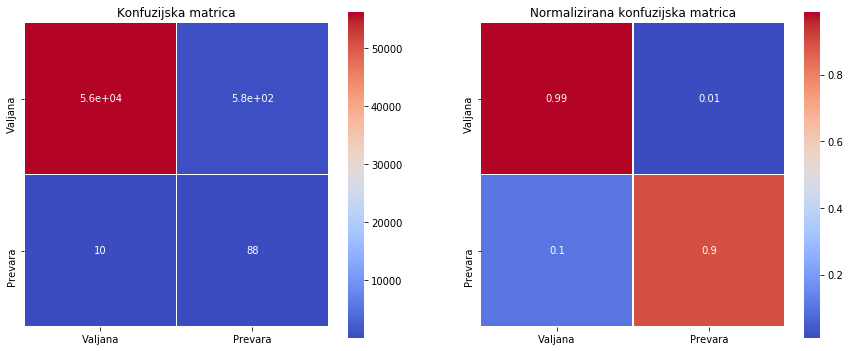

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Glasački klasifikator (6)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 14.499999999999998%
	Recall score: 88.78%
	F1 score: 24.93%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.14      0.89      0.25        98

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.62     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


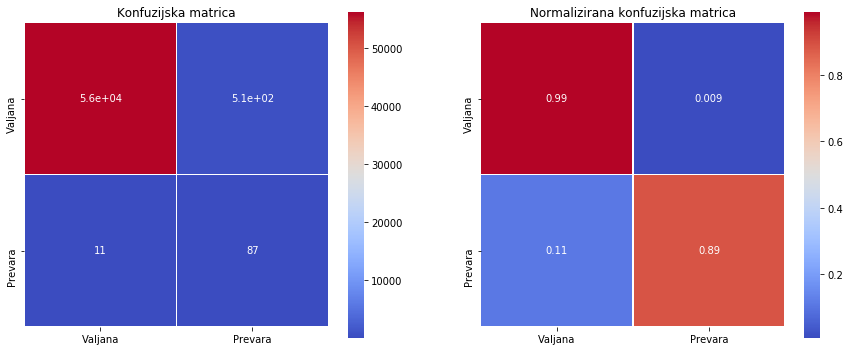

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Glasački klasifikator (7)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 22.189999999999998%
	Recall score: 88.78%
	F1 score: 35.510000000000005%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.22      0.89      0.36        98

    accuracy                           0.99     56962
   macro avg       0.61      0.94      0.68     56962
weighted avg       1.00      0.99      1.00     56962


----------------------------------------------------------------------------------------------------


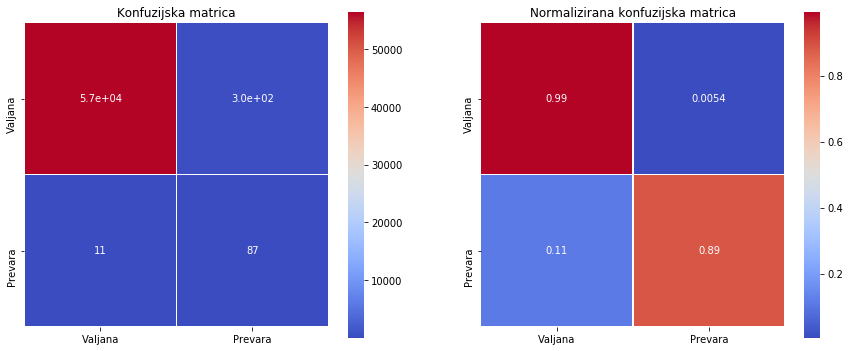

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Glasački klasifikator (8)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 22.48%
	Recall score: 88.78%
	F1 score: 35.88%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.22      0.89      0.36        98

    accuracy                           0.99     56962
   macro avg       0.61      0.94      0.68     56962
weighted avg       1.00      0.99      1.00     56962


----------------------------------------------------------------------------------------------------


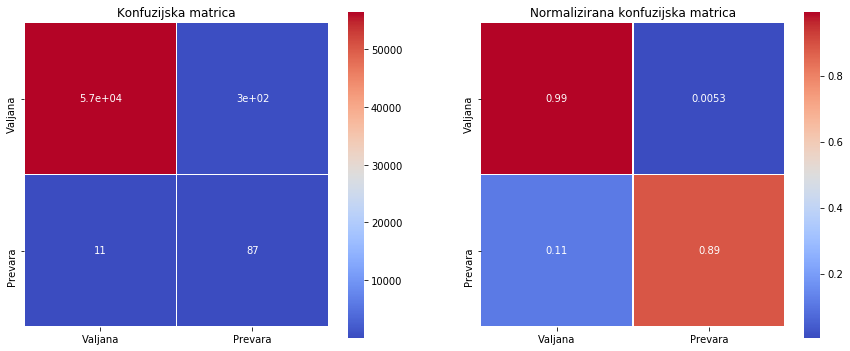

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [75]:
full_pred_voting5_params = voting5_usample.predict(X_data_test)
full_pred_voting6_params = voting6_usample.predict(X_data_test)
full_pred_voting7_params = voting7_usample.predict(X_data_test)
full_pred_voting8_params = voting8_usample.predict(X_data_test)

print('*'*100)
print('Glasački klasifikator (5)')
print_everything(y_data_test, full_pred_voting5_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("Glasački klasifikator (6)")
print_everything(y_data_test, full_pred_voting6_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("Glasački klasifikator (7)")
print_everything(y_data_test, full_pred_voting7_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("Glasački klasifikator (8)")
print_everything(y_data_test, full_pred_voting8_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('*'*100)

Komentari za druga 4 glasačka klasifikatora: <br>
<ul>
    <li><em>Peti glasački klasifikator (5)</em> - vrlo dobar klasifikator (malo lošiji od (2), ali bolji od ostalih):
        <ul>
            <li><i>preciznost</i>: 13.17%</li>
            <li><i>osjetljivost</i>: 89.8%</li>
            <li><i>f1-mjera</i>: 22.98%</li>
            <li><i>ispravno klasificirane prevare</i>: 88</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~580</li>
        </ul>
    </li>
    <li><em>Šesti glasački klasifikator (6)</em> - također vrlo dobar klasifikator (u rangu s prethodnim):
        <ul>
            <li><i>preciznost</i>: 14.45%</li>
            <li><i>osjetljivost</i>: 88.78%</li>
            <li><i>f1-mjera</i>: 24.93%</li>
            <li><i>ispravno klasificirane prevare</i>: 87 (najmanje od svih dosad)</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~510 (također najmanje dosad)</li>
        </ul>
    </li>
    <li><em>Sedmi glasački klasifikator (7)</em> - ovo je već fantastičan klasifikator sa značajnije boljim rezultatima od prethodnog:
        <ul>
            <li><i>preciznost</i>: 22.19%</li>
            <li><i>osjetljivost</i>: 88.78%</li>
            <li><i>f1-mjera</i>: 35.51%</li>
            <li><i>ispravno klasificirane prevare</i>: 87 (jednako kao i prethodni)</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~300 (za ~210 bolje od prethodnog)</li>
        </ul>
    </li>
    <li><em>Osmi glasački klasifikator (8)</em> - ovaj klasifikator je čak i malo bolji od prethodnog
        <ul>
            <li><i>preciznost</i>: 22.48% (0.29% bolje od prethodnog)</li>
            <li><i>osjetljivost</i>: 88.78%</li>
            <li><i>f1-mjera</i>: 35.88% (0.37% bolje od prethodnog)</li>
            <li><i>ispravno klasificirane prevare</i>: 87 (jednako kao i prethodni)</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~300 </li>
        </ul>
    </li>
</ul>

****************************************************************************************************
Glasački klasifikator (9)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 12.139999999999999%
	Recall score: 89.8%
	F1 score: 21.39%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.12      0.90      0.21        98

    accuracy                           0.99     56962
   macro avg       0.56      0.94      0.60     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


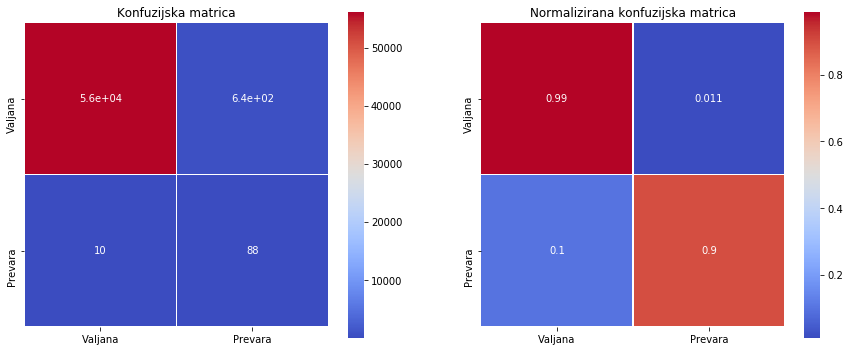

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Glasački klasifikator (10)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 12.629999999999999%
	Recall score: 88.78%
	F1 score: 22.11%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.89      0.22        98

    accuracy                           0.99     56962
   macro avg       0.56      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


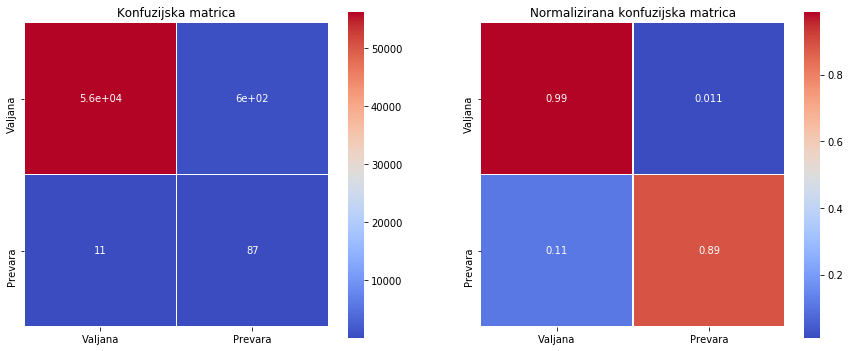

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Glasački klasifikator (11)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 11.37%
	Recall score: 90.82000000000001%
	F1 score: 20.200000000000003%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.91      0.20        98

    accuracy                           0.99     56962
   macro avg       0.56      0.95      0.60     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


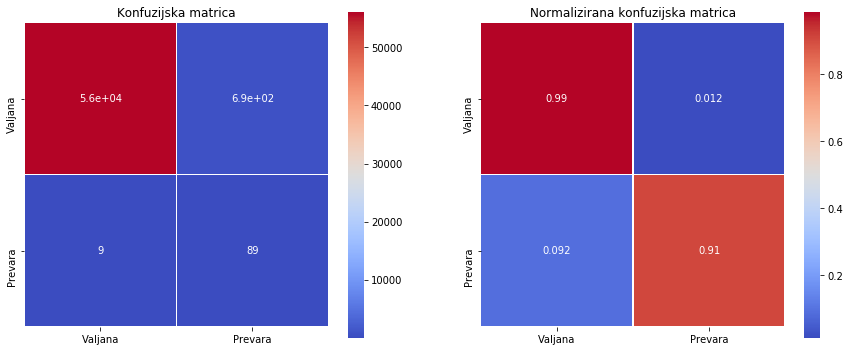

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [76]:
full_pred_voting9_params = voting9_usample.predict(X_data_test)
full_pred_voting10_params = voting10_usample.predict(X_data_test)
full_pred_voting11_params = voting11_usample.predict(X_data_test)

print('*'*100)
print('Glasački klasifikator (9)')
print_everything(y_data_test, full_pred_voting9_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("Glasački klasifikator (10)")
print_everything(y_data_test, full_pred_voting10_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("Glasački klasifikator (11)")
print_everything(y_data_test, full_pred_voting11_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('*'*100)

Komentari za prva 4 glasačka klasifikatora: <br>
<ul>
    <li><em>Deveti glasački klasifikator (9)</em> - poprilično dobar klasifikator sa sljedećim rezultatima:
        <ul>
            <li><i>preciznost</i>: 12.14%</li>
            <li><i>osjetljivost</i>: 89.8%</li>
            <li><i>f1-mjera</i>: 21.39%</li>
            <li><i>ispravno klasificirane prevare</i>: 88</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~640</li>
        </ul>
    </li>
    <li><em>Deseti glasački klasifikator (10)</em> - jedan od slabijih klasifikatora (u usporedbi sa ostalim glasačkim, i dalje nije loš):
        <ul>
            <li><i>preciznost</i>: 12.63%</li>
            <li><i>osjetljivost</i>: 88.78%</li>
            <li><i>f1-mjera</i>: 22.11%</li>
            <li><i>ispravno klasificirane prevare</i>: 87 </li>
            <li><i>pogrešno klasificiryne valjane</i>: ~600 </li>
        </ul>
    </li>
    <li><em>Jedanaesti glasački klasifikator (11)</em> - klasifikator sa boljim prepoznavanjem prevara (najbolji od zadnja 3):
        <ul>
            <li><i>preciznost</i>: 11.37%</li>
            <li><i>osjetljivost</i>: 90.82%</li>
            <li><i>f1-mjera</i>: 20.2%</li>
            <li><i>ispravno klasificirane prevare</i>: 89 (jedan od boljih glasačkih)</li>
            <li><i>pogrešno klasificiryne valjane</i>: ~690 </li>
        </ul>
    </li>

</ul>

## Near miss

In [ ]:
#opis nearmissa

In [6]:
from imblearn.under_sampling import NearMiss

In [7]:
nearmiss1 = NearMiss(version=1)
nearmiss2 = NearMiss(version=2)
nearmiss3 = NearMiss(version=3)

X_nm1_train, y_nm1_train = nearmiss1.fit_resample(X_data_train, y_data_train)
y_nm1_non_fraud_num = y_nm1_train.value_counts()[0]
y_nm1_fraud_num = y_nm1_train.value_counts()[1]

X_nm2_train, y_nm2_train = nearmiss2.fit_resample(X_data_train, y_data_train)
y_nm2_non_fraud_num = y_nm2_train.value_counts()[0]
y_nm2_fraud_num = y_nm2_train.value_counts()[1]

X_nm3_train, y_nm3_train = nearmiss3.fit_resample(X_data_train, y_data_train)
y_nm3_non_fraud_num = y_nm3_train.value_counts()[0]
y_nm3_fraud_num = y_nm3_train.value_counts()[1]

print('Broj valjanih transakcija u trening skupu nakon undersamplinga (NearMiss1): ' + str(y_nm1_non_fraud_num))
print('Broj prevarantskih transakcija u trening skupu nakon undersamplinga (NearMiss1): ' + str(y_nm1_fraud_num))
print('Ukupan broj transakcija u trening skupu nakon undersamplinga (NearMiss1): ' + str(y_nm1_fraud_num + y_nm1_non_fraud_num))
print('-'*100)

print('Broj valjanih transakcija u trening skupu nakon undersamplinga (NearMiss2): ' + str(y_nm2_non_fraud_num))
print('Broj prevarantskih transakcija u trening skupu nakon undersamplinga (NearMiss2): ' + str(y_nm2_fraud_num))
print('Ukupan broj transakcija u trening skupu nakon undersamplinga (NearMiss2): ' + str(y_nm2_fraud_num + y_nm2_non_fraud_num))
print('-'*100)

print('Broj valjanih transakcija u trening skupu nakon undersamplinga (NearMiss3): ' + str(y_nm3_non_fraud_num))
print('Broj prevarantskih transakcija u trening skupu nakon undersamplinga (NearMiss3): ' + str(y_nm3_fraud_num))
print('Ukupan broj transakcija u trening skupu nakon undersamplinga (NearMiss3): ' + str(y_nm3_fraud_num + y_nm3_non_fraud_num))
print('-'*100)

Broj valjanih transakcija u trening skupu nakon undersamplinga (NearMiss1): 394
Broj prevarantskih transakcija u trening skupu nakon undersamplinga (NearMiss1): 394
Ukupan broj transakcija u trening skupu nakon undersamplinga (NearMiss1): 788
----------------------------------------------------------------------------------------------------
Broj valjanih transakcija u trening skupu nakon undersamplinga (NearMiss2): 394
Broj prevarantskih transakcija u trening skupu nakon undersamplinga (NearMiss2): 394
Ukupan broj transakcija u trening skupu nakon undersamplinga (NearMiss2): 788
----------------------------------------------------------------------------------------------------
Broj valjanih transakcija u trening skupu nakon undersamplinga (NearMiss3): 327
Broj prevarantskih transakcija u trening skupu nakon undersamplinga (NearMiss3): 394
Ukupan broj transakcija u trening skupu nakon undersamplinga (NearMiss3): 721
---------------------------------------------------------------------

C:\Users\stvar\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:178: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


### Logistička regresija

In [8]:
nm1_log_reg = LogisticRegression(solver='liblinear')
nm1_log_reg.fit(X_nm1_train, y_nm1_train)

nm1_log_reg_training_score = cross_val_score(nm1_log_reg, X_nm1_train, y_nm1_train, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (NearMiss1): ' 
     + str(round(nm1_log_reg_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (NearMiss1): 95.00999999999999%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.44999999999999996%
	Recall score: 92.86%
	F1 score: 0.89%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.64      0.78     56864
           1       0.00      0.93      0.01        98

    accuracy                           0.65     56962
   macro avg       0.50      0.79      0.40     56962
weighted avg       1.00      0.65      0.78     56962


----------------------------------------------------------------------------------------------------


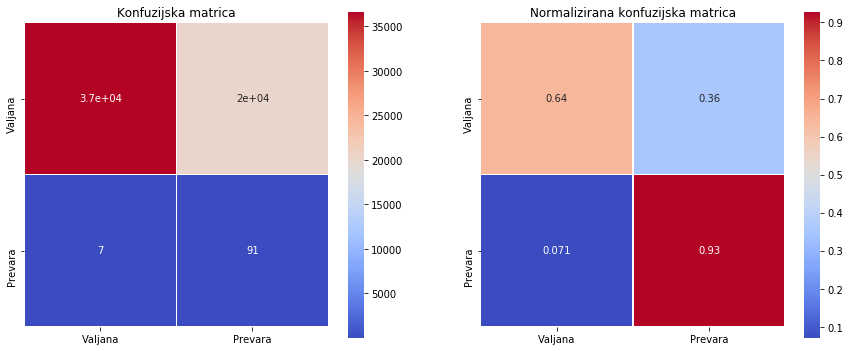

----------------------------------------------------------------------------------------------------


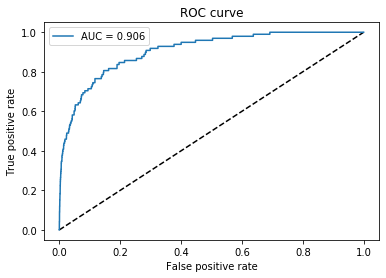

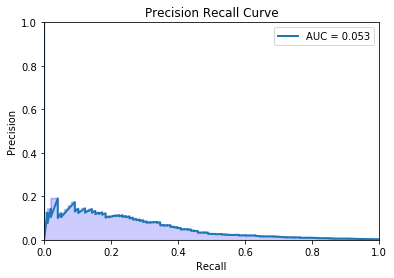

In [9]:
full_pred_log_reg_nm1 = nm1_log_reg.predict(X_data_test)
full_pred_score_log_reg_nm1 = nm1_log_reg.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg_nm1, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg_nm1, True)

In [10]:
nm2_log_reg = LogisticRegression(solver='liblinear')
nm2_log_reg.fit(X_nm2_train, y_nm2_train)

nm2_log_reg_training_score = cross_val_score(nm2_log_reg, X_nm2_train, y_nm2_train, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (NearMiss2): ' 
     + str(round(nm2_log_reg_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (NearMiss2): 90.06%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.29%
	Recall score: 87.76%
	F1 score: 0.58%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.48      0.65     56864
           1       0.00      0.88      0.01        98

    accuracy                           0.48     56962
   macro avg       0.50      0.68      0.33     56962
weighted avg       1.00      0.48      0.65     56962


----------------------------------------------------------------------------------------------------


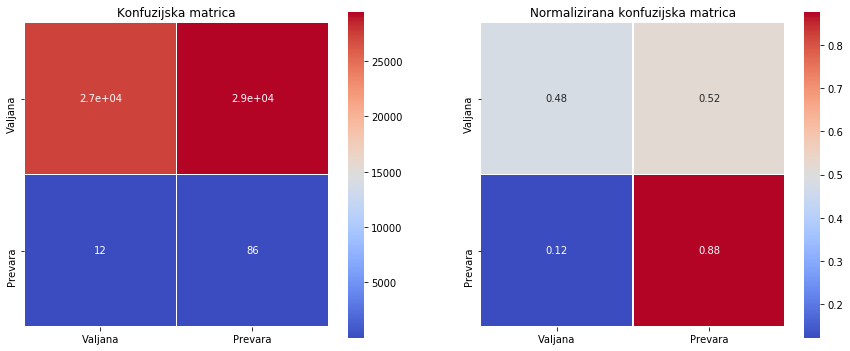

----------------------------------------------------------------------------------------------------


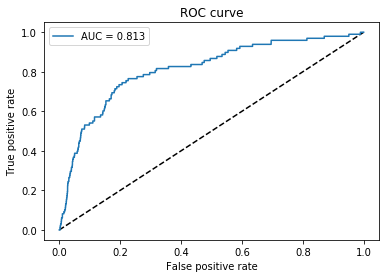

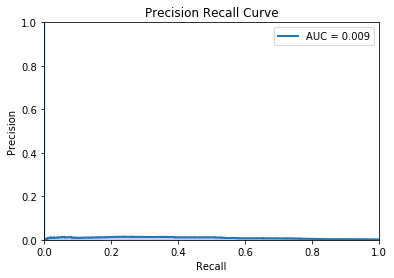

In [11]:
full_pred_log_reg_nm2 = nm2_log_reg.predict(X_data_test)
full_pred_score_log_reg_nm2 = nm2_log_reg.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg_nm2, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg_nm2, True)

In [12]:
nm3_log_reg = LogisticRegression(solver='liblinear')
nm3_log_reg.fit(X_nm3_train, y_nm3_train)

nm3_log_reg_training_score = cross_val_score(nm3_log_reg, X_nm3_train, y_nm3_train, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (NearMiss3): ' 
     + str(round(nm3_log_reg_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (NearMiss3): 77.48%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 1.05%
	Recall score: 74.49%
	F1 score: 2.06%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     56864
           1       0.01      0.74      0.02        98

    accuracy                           0.88     56962
   macro avg       0.50      0.81      0.48     56962
weighted avg       1.00      0.88      0.93     56962


----------------------------------------------------------------------------------------------------


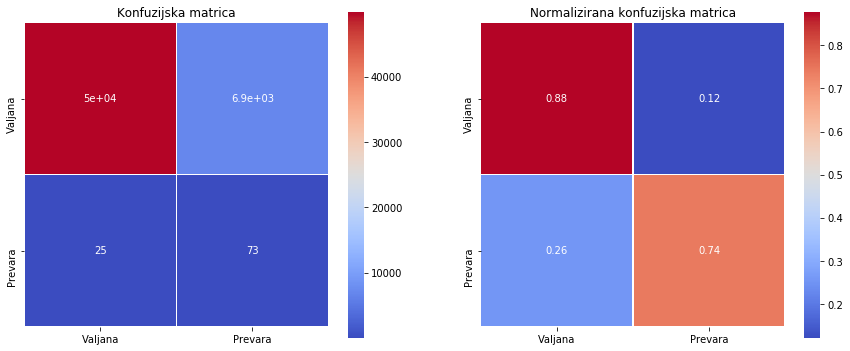

----------------------------------------------------------------------------------------------------


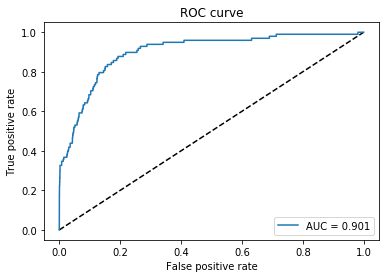

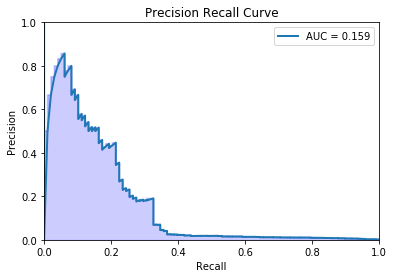

In [13]:
full_pred_log_reg_nm3 = nm3_log_reg.predict(X_data_test)
full_pred_score_log_reg_nm3 = nm3_log_reg.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg_nm3, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg_nm3, True)

Rezultati koje smo dobili bilo kojom od 3 NearMiss verzija su poprilično loši.<br>
Za verziju 1 model je dobro klasificirao čak 91 prevaru, ali također je i pogrešno klasificirao čak ~20 000 valjanih transakcija. Osjetljivost je zavidnih 92.86%, dok su i preciznost i f1-mjera manje od 1%. <br>
Verzija 2 je još gora jer su i preciznost i f1-mjera i osjetljivost manje nego kod prve verzije. Ovaj model je ispravno klasificirao 86 prevara dok je pogrešno klasificirano čak ~29 000 valjanih transakcija (više je pogrešno klasificiranih valjanih transakcija nego ispravno klasificiranih !!!). <br>
Treća verzija NearMiss algoritma je također sramotna. Preciznost je ~1%, f1-mjera 2%, dok je osjetljivost mizernih 74.49%. Odnosno, taj model je ispravno klasificirao svega 73 prevare, dok je pogrešno klasificirao ~6900 valjanih transkcija. <br>
Pokušat ćemo podesiti parametre u nadi da će se ti rezultati popraviti.

C:\Users\stvar\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


NearMiss1:
Najbolji parametri: {'C': 10, 'penalty': 'l1'}
Rezultat treniranja za logističku regresiju nad undersampliranim (NearMiss1) datasetom (sa parametrima): 94.8%
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.4%
	Recall score: 91.84%
	F1 score: 0.8%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.61      0.76     56864
           1       0.00      0.92      0.01        98

    accuracy                           0.61     56962
   macro avg       0.50      0.76      0.38     56962
weighted avg       1.00      0.61      0.75     56962


----------------------------------------------------------------------------------------------------


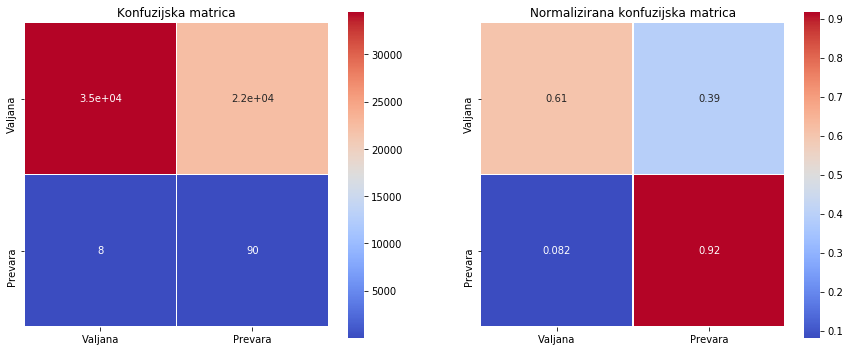

----------------------------------------------------------------------------------------------------


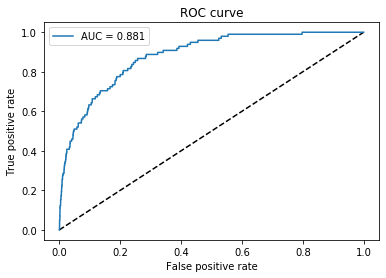

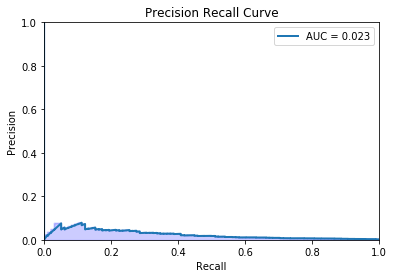

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
NearMiss2:
Najbolji parametri: {'C': 0.01, 'penalty': 'l2'}
Rezultat treniranja za logističku regresiju nad undersampliranim (NearMiss2) datasetom (sa parametrima): 92.34%
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.31%
	Recall score: 91.84%
	F1 score: 0.62%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.49      0.66     56864
           1       0.00      0.92      0.01        98

    accuracy                           0.49     56962
   macro avg       0.50      0.70      0.33     56962
weighted avg       1.00      0.49      0.66     56962


--

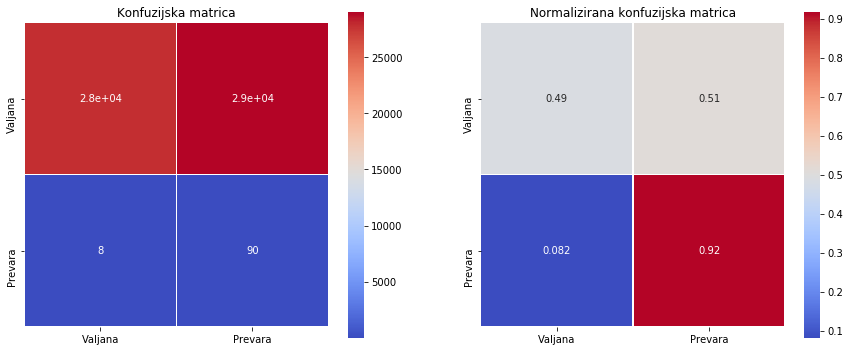

----------------------------------------------------------------------------------------------------


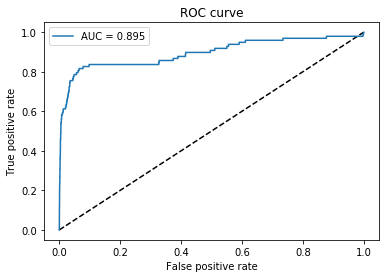

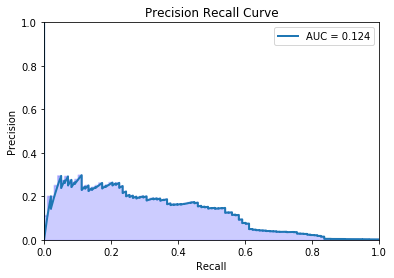

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
NearMiss3:
Najbolji parametri: {'C': 0.1, 'penalty': 'l1'}
Rezultat treniranja za logističku regresiju nad undersampliranim (NearMiss3) datasetom (sa parametrima): 79.84%
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 2.39%
	Recall score: 80.61%
	F1 score: 4.65%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.02      0.81      0.05        98

    accuracy                           0.94     56962
   macro avg       0.51      0.87      0.51     56962
weighted avg       1.00      0.94      0.97     56962


---

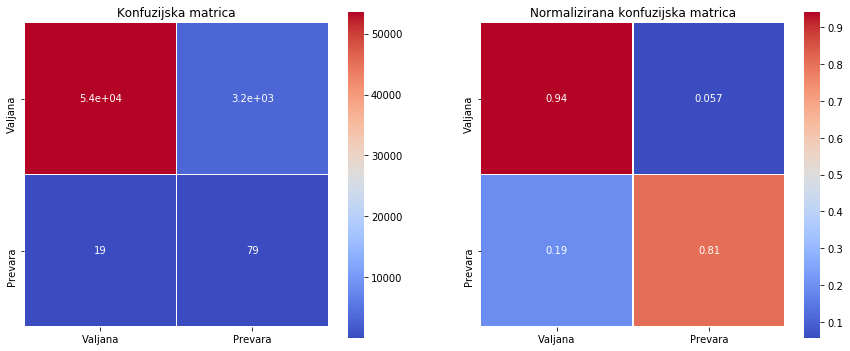

----------------------------------------------------------------------------------------------------


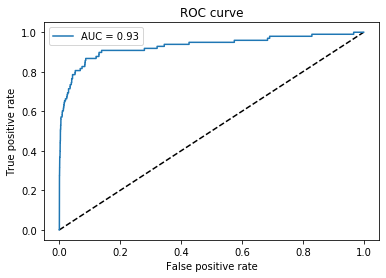

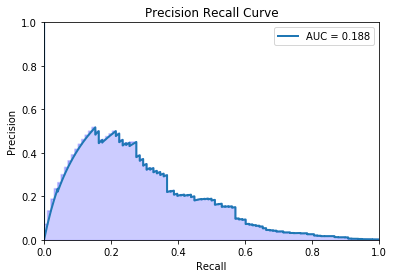

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [16]:
grid_log_reg_nm1 = GridSearchCV(LogisticRegression(solver='liblinear'), log_reg_params)
grid_log_reg_nm1.fit(X_nm1_train, y_nm1_train)
log_reg_est_nm1 = grid_log_reg_nm1.best_estimator_
log_reg_params_nm1 = grid_log_reg_nm1.best_params_

print('NearMiss1:')
print('Najbolji parametri: ' + str(log_reg_params_nm1))

log_reg_training_score_params_nm1 = cross_val_score(log_reg_est_nm1, X_nm1_train, y_nm1_train, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim (NearMiss1) datasetom (sa parametrima): ' 
     + str(round(log_reg_training_score_params_nm1.mean(), 4) * 100) + '%')

full_pred_log_reg_params_nm1 = log_reg_est_nm1.predict(X_data_test)
full_pred_score_log_reg_params_nm1 = log_reg_est_nm1.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg_params_nm1, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg_params_nm1, True)
print('+'*100)
print('+'*100)

grid_log_reg_nm2 = GridSearchCV(LogisticRegression(solver='liblinear'), log_reg_params)
grid_log_reg_nm2.fit(X_nm2_train, y_nm2_train)
log_reg_est_nm2 = grid_log_reg_nm2.best_estimator_
log_reg_params_nm2 = grid_log_reg_nm2.best_params_

print('NearMiss2:')
print('Najbolji parametri: ' + str(log_reg_params_nm2))

log_reg_training_score_params_nm2 = cross_val_score(log_reg_est_nm2, X_nm1_train, y_nm1_train, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim (NearMiss2) datasetom (sa parametrima): ' 
     + str(round(log_reg_training_score_params_nm2.mean(), 4) * 100) + '%')

full_pred_log_reg_params_nm2 = log_reg_est_nm2.predict(X_data_test)
full_pred_score_log_reg_params_nm2 = log_reg_est_nm2.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg_params_nm2, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg_params_nm2, True)
print('+'*100)
print('+'*100)

grid_log_reg_nm3 = GridSearchCV(LogisticRegression(solver='liblinear'), log_reg_params)
grid_log_reg_nm3.fit(X_nm3_train, y_nm3_train)
log_reg_est_nm3 = grid_log_reg_nm3.best_estimator_
log_reg_params_nm3 = grid_log_reg_nm3.best_params_

print('NearMiss3:')
print('Najbolji parametri: ' + str(log_reg_params_nm3))

log_reg_training_score_params_nm3 = cross_val_score(log_reg_est_nm3, X_nm3_train, y_nm3_train, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim (NearMiss3) datasetom (sa parametrima): ' 
     + str(round(log_reg_training_score_params_nm3.mean(), 4) * 100) + '%')

full_pred_log_reg_params_nm3 = log_reg_est_nm3.predict(X_data_test)
full_pred_score_log_reg_params_nm3 = log_reg_est_nm3.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg_params_nm3, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg_params_nm3, True)
print('+'*100)
print('+'*100)

Rezultati su se blago poboljšali za drugu i treću verziju NearMissa, ali su i dalje katastrofalni. Moguće je da NearMiss ne funkcionira dobro sa Logističkom regresijom pa ćemo probati na još metodi najbližih susjeda. 

### Metoda najbližih susjeda

In [18]:
nm1_knn = KNeighborsClassifier()
nm1_knn.fit(X_nm1_train, y_nm1_train)

nm1_knn_training_score = cross_val_score(nm1_knn, X_nm1_train, y_nm1_train, cv=rskf)
print('Rezultat treniranja za metodu najbližih susjeda nad undersampliranim datasetom (NearMiss1): ' 
     + str(round(nm1_knn_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za metodu najbližih susjeda nad undersampliranim datasetom (NearMiss1): 94.21000000000001%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.73%
	Recall score: 90.82000000000001%
	F1 score: 1.44%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.79      0.88     56864
           1       0.01      0.91      0.01        98

    accuracy                           0.79     56962
   macro avg       0.50      0.85      0.45     56962
weighted avg       1.00      0.79      0.88     56962


----------------------------------------------------------------------------------------------------


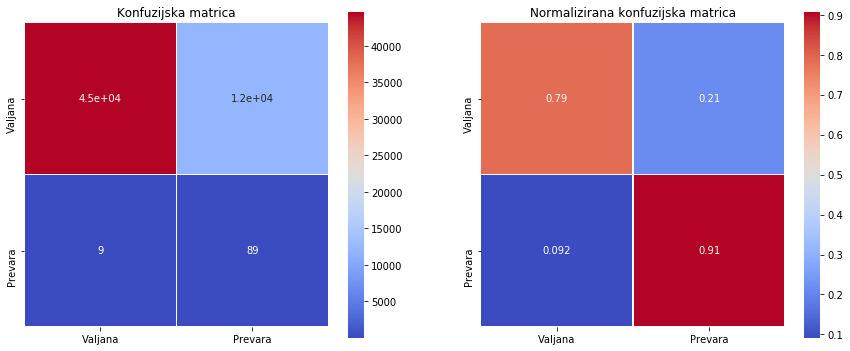

----------------------------------------------------------------------------------------------------


In [20]:
full_pred_knn_nm1= nm1_knn.predict(X_data_test)
print_everything(y_data_test, full_pred_knn_nm1, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Rezultati za metodu najbližih susjeda su nešto bolji, no i dalje je broj pogrešno klasificiranih valjanih transakcija prevelik (~12 000). Koristili smo samo prvu verziju NearMissa jer je kod logističke regresije pokazala najbolje rezultate.

In [21]:
num_neighbors_params = [1, 2, 3, 4, 5, 7, 9]
alg_params = ['auto', 'brute', 'ball_tree', 'kd_tree']
p_params = [1, 2]

knn_params = {'n_neighbors': num_neighbors_params, 'algorithm': alg_params, 'p': p_params, 'metric': ['minkowski']}

In [23]:
grid_knn_nm1 = GridSearchCV(KNeighborsClassifier(), knn_params)
grid_knn_nm1.fit(X_nm1_train, y_nm1_train)
knn_nm1_est = grid_knn_nm1.best_estimator_
knn_params_nm1 = grid_knn_nm1.best_params_
print('Najbolji parametri: ' + str(knn_params_nm1))

knn_training_score_params_nm1 = cross_val_score(knn_nm1_est, X_nm1_train, y_nm1_train, cv=rskf)
print('Rezultat treniranja za k (' +  str(knn_params_nm1['n_neighbors']) + 
      ')  najbližih susjeda nad undersampliranim (NearMiss1) datasetom (sa parametrima): ' 
     + str(round(knn_training_score_params_nm1.mean(), 4) * 100) + '%')

Najbolji parametri: {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 3, 'p': 2}
Rezultat treniranja za k (3)  najbližih susjeda nad undersampliranim (NearMiss1) datasetom (sa parametrima): 94.5%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.51%
	Recall score: 92.86%
	F1 score: 1.01%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.69      0.81     56864
           1       0.01      0.93      0.01        98

    accuracy                           0.69     56962
   macro avg       0.50      0.81      0.41     56962
weighted avg       1.00      0.69      0.81     56962


----------------------------------------------------------------------------------------------------


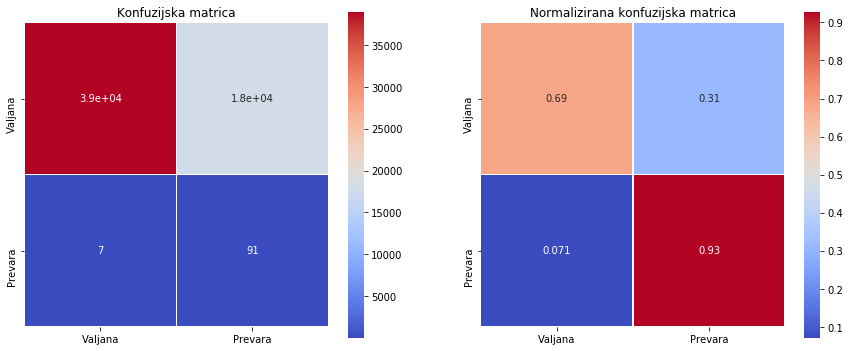

----------------------------------------------------------------------------------------------------


In [24]:
full_pred_knn_nm1_params = knn_nm1_est.predict(X_data_test)
print_everything(y_data_test, full_pred_knn_nm1_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Nakon podešavanja parametara broj pogrešno valjanih transakcija je još porastao (~18 000), dobro je jedino što smo bar dobili veći broj ispravno klasificiranih prevara.

### XGB

Još ćemo pokušati iskoristiti XGB kao klasifikator (obzirom da je bio jako dobar na nasumičnom undersamplingu).

In [25]:
nm1_xgb = XGBClassifier()
nm1_xgb.fit(X_nm1_train, y_nm1_train)

nm1_xgb_training_score = cross_val_score(nm1_xgb, X_nm1_train, y_nm1_train, cv=rskf)
print('Rezultat treniranja za XGB nad undersampliranim datasetom (NearMiss1): ' 
     + str(round(nm1_xgb_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za XGB nad undersampliranim datasetom (NearMiss1): 96.07%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.22999999999999998%
	Recall score: 97.96000000000001%
	F1 score: 0.44999999999999996%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.26      0.41     56864
           1       0.00      0.98      0.00        98

    accuracy                           0.26     56962
   macro avg       0.50      0.62      0.21     56962
weighted avg       1.00      0.26      0.41     56962


----------------------------------------------------------------------------------------------------


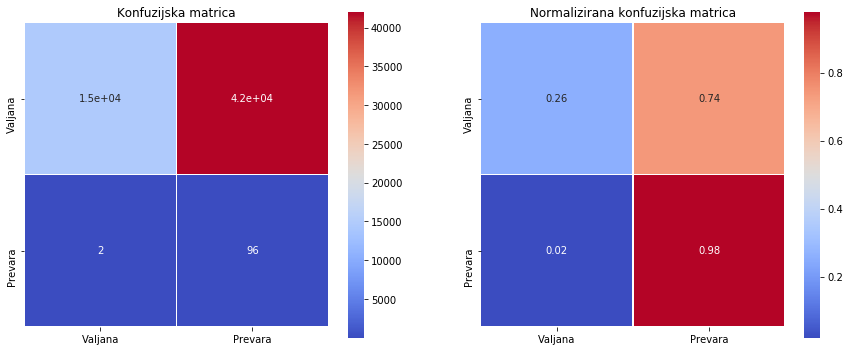

----------------------------------------------------------------------------------------------------


In [26]:
full_pred_xgb_nm1 = nm1_xgb.predict(X_data_test)
print_everything(y_data_test, full_pred_xgb_nm1, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Korištenjem NearMissa kao undersampling metode i XGB-a kao klasifikatora rezultati su također vrlo loši. Iako imamo rekordnih 96 ispravno klasificiranih prevara, imamo i rekord u broj pogrešno klasificiranih valjanih transakcija (~42 000 ili 74%). 

In [27]:
xgb_gamma = [0, 1, 5, 10]
xgb_max_depth = [1, 2, 3, 4, 5, 7]
xgb_colsample_bytree = [0.3, 0.5, 0.8]
xgb_learning_rate = [0.3, 0.1, 0.05, 0.01]
xgb_n_estimators = [10, 20, 50, 100]
xgb_params = {'gamma': xgb_gamma, 'max_depth': xgb_max_depth, 'colsample_bytree': xgb_colsample_bytree, 
              'learning_rate': xgb_learning_rate, 'n_estimators': xgb_n_estimators}

In [28]:
grid_xgb_nm1 = GridSearchCV(XGBClassifier(), xgb_params)
grid_xgb_nm1.fit(X_nm1_train, y_nm1_train)
xgb_nm1_est = grid_xgb_nm1.best_estimator_
xgb_params_nm1 = grid_xgb_nm1.best_params_
print('Najbolji parametri: ' + str(xgb_params_nm1))

xgb_training_score_params_nm1 = cross_val_score(xgb_nm1_est, X_nm1_train, y_nm1_train, cv=rskf)
print('Rezultat treniranja za XGB nad undersampliranim (NearMiss1) datasetom (sa parametrima): ' 
     + str(round(xgb_training_score_params_nm1.mean(), 4) * 100) + '%')

Najbolji parametri: {'colsample_bytree': 0.3, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 20}
Rezultat treniranja za XGB nad undersampliranim (NearMiss1) datasetom (sa parametrima): 96.36%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 0.22%
	Recall score: 96.94%
	F1 score: 0.44%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.24      0.39     56864
           1       0.00      0.97      0.00        98

    accuracy                           0.24     56962
   macro avg       0.50      0.60      0.20     56962
weighted avg       1.00      0.24      0.39     56962


----------------------------------------------------------------------------------------------------


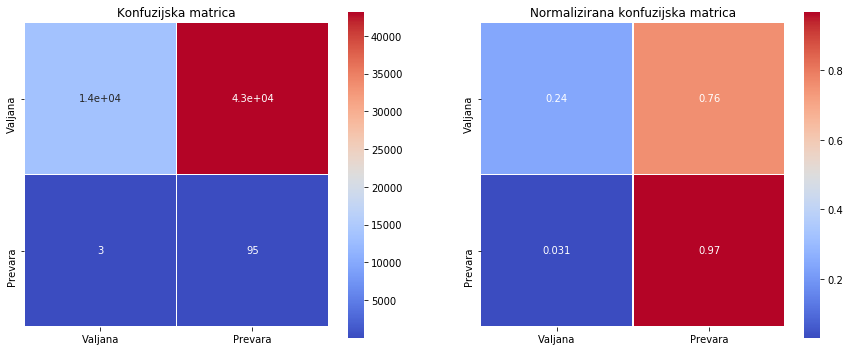

----------------------------------------------------------------------------------------------------


In [29]:
full_pred_xgb_nm1_params = xgb_nm1_est.predict(X_data_test)
print_everything(y_data_test, full_pred_xgb_nm1_params, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Podešavanjem parametara smo ustvari dobili još lošije rezultate.

## Stisnuti najbliži susjedi

In [ ]:
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour()

X_cnn_train, y_cnn_train = cnn.fit_resample(X_data_train, y_data_train)
y_cnn_non_fraud_num = y_cnn_train.value_counts()[0]
y_cnn_fraud_num = y_cnn_train.value_counts()[1]


print('Broj valjanih transakcija u trening skupu nakon undersamplinga (CondensedNearestNeighbour): ' + str(y_cnn_non_fraud_num))
print('Broj prevarantskih transakcija u trening skupu nakon undersamplinga (CondensedNearestNeighbour): ' + str(y_cnn_fraud_num))
print('Ukupan broj transakcija u trening skupu nakon undersamplinga (CondensedNearestNeighbour): ' + str(y_cnn_fraud_num + y_cnn_non_fraud_num))

### Logistička regresija

In [ ]:
cnn_log_reg = LogisticRegression(solver='liblinear')
cnn_log_reg.fit(X_cnn_train, y_cnn_train)

cnn_log_reg_training_score = cross_val_score(cnn_log_reg, X_cnn_train, y_cnn_train, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (CondensedNearestNeighbour): ' 
     + str(round(cnn_log_reg_training_score.mean(), 4) * 100) + '%')

In [ ]:
full_pred_log_reg_cnn = cnn_log_reg.predict(X_data_test)
full_pred_score_log_reg_cnn = cnn_log_reg.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg_cnn, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg_cnn, True)

In [ ]:
#komentari

### Slučajne šume

In [ ]:
cnn_rf = RandomForestClassifier()
cnn_rf.fit(X_cnn_train, y_cnn_train)

cnn_rf_training_score = cross_val_score(cnn_rf, X_cnn_train, y_cnn_train, cv=rskf)
print('Rezultat treniranja za slučajne šume nad undersampliranim datasetom (CondensedNearestNeighbour): ' 
     + str(round(cnn_rf_training_score.mean(), 4) * 100) + '%')

In [ ]:
full_pred_rf_cnn = cnn_rf.predict(X_data_test)
print_everything(y_data_test, full_pred_rf_cnn, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

In [ ]:
#komentari

## Jednostrana selekcija

In [4]:
from imblearn.under_sampling import OneSidedSelection

oss = OneSidedSelection()

X_oss_train, y_oss_train = oss.fit_resample(X_data_train, y_data_train)
y_oss_non_fraud_num = y_oss_train.value_counts()[0]
y_oss_fraud_num = y_oss_train.value_counts()[1]


print('Broj valjanih transakcija u trening skupu nakon undersamplinga (OneSidedSelection): ' + str(y_oss_non_fraud_num))
print('Broj prevarantskih transakcija u trening skupu nakon undersamplinga (OneSidedSelection): ' + str(y_oss_fraud_num))
print('Ukupan broj transakcija u trening skupu nakon undersamplinga (OneSidedSelection): ' + str(y_oss_fraud_num + y_oss_non_fraud_num))

Broj valjanih transakcija u trening skupu nakon undersamplinga (OneSidedSelection): 214873
Broj prevarantskih transakcija u trening skupu nakon undersamplinga (OneSidedSelection): 394
Ukupan broj transakcija u trening skupu nakon undersamplinga (OneSidedSelection): 215267


### Bagging Classifier

In [23]:
oss_bag = BaggingClassifier()
oss_bag.fit(X_oss_train, y_oss_train)

oss_bag_training_score = cross_val_score(oss_bag, X_oss_train, y_oss_train, cv=rskf)
print('Rezultat treniranja za bagging klasifikator nad undersampliranim datasetom (OneSidedSelection): ' 
     + str(round(oss_bag_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za bagging klasifikator nad undersampliranim datasetom (OneSidedSelection): 99.94%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 97.39999999999999%
	Recall score: 76.53%
	F1 score: 85.71%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.77      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


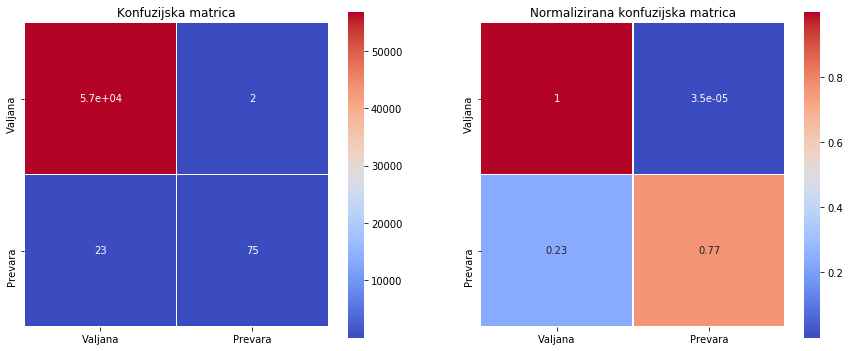

----------------------------------------------------------------------------------------------------


In [24]:
full_pred_bag_oss = oss_bag.predict(X_data_test)
print_everything(y_data_test, full_pred_bag_oss, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Vidimo da sa bagging klasifikatorom dobijamo jako visoku preciznost (97.4%) i f1-mjeru (85.71%), dok je osjetljivost dosta niža nego što bismo željeli (76.53%). Iz konfuzijske matrice vidimo da su samo 2 (ukupno ih je oko 57 000) valjane transakcije klasificirane kao prevare, dok je čak 23 prevare klasificirano kao valjane transakcije (od ukupno 98 prevara). 

### Metoda potpornih vektora

In [5]:
oss_svc = SVC()
oss_svc.fit(X_oss_train, y_oss_train)

oss_svc_training_score = cross_val_score(oss_svc, X_oss_train, y_oss_train, cv=rskf)
print('Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom (OneSidedSelection): ' 
     + str(round(oss_svc_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom (OneSidedSelection): 99.92999999999999%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 96.83%
	Recall score: 62.239999999999995%
	F1 score: 75.78%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.62      0.76        98

    accuracy                           1.00     56962
   macro avg       0.98      0.81      0.88     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


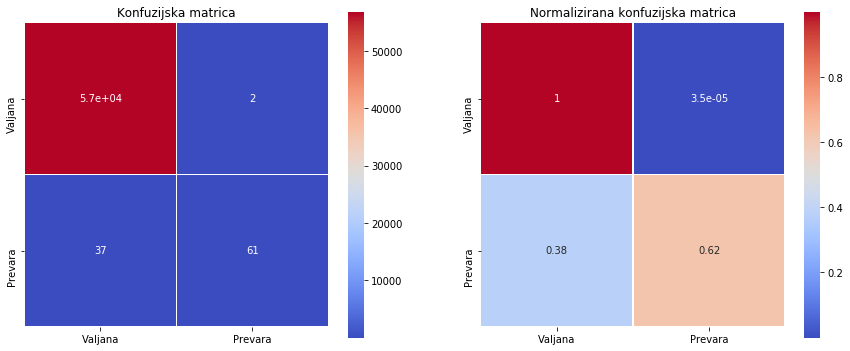

----------------------------------------------------------------------------------------------------


In [6]:
full_pred_svc_oss = oss_svc.predict(X_data_test)
print_everything(y_data_test, full_pred_svc_oss, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Korištenjem metode potpornih vektora dobili smo prilično loše rezultate. Iako je preciznost visoka (96.83%), osjetljivost (62.24%) i f1-mjera (75.78%) su slabije. Odnosno, gledajući matricu konfuzije vidimo da su samo 2 valjane transakcije klasificirane kao prevare, dok je čak 37 prevara (od ukupno 98) klasificirano kao valjane transakcije. Valjalo bi napomenuti da nismo podešavali nikakve parametre. Također ako promotrimo malo bolje možemo vidjeti da klasifikator postiže jednake rezultate kao i klasifikator treniran na originalnom trening skupu podataka.

### XGB

In [7]:
oss_xgb = XGBClassifier()
oss_xgb.fit(X_oss_train, y_oss_train)

oss_xgb_training_score = cross_val_score(oss_xgb, X_oss_train, y_oss_train, cv=rskf)
print('Rezultat treniranja za XGB nad undersampliranim datasetom (OneSidedSelection): ' 
     + str(round(oss_xgb_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za XGB nad undersampliranim datasetom (OneSidedSelection): 99.95%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 93.02%
	Recall score: 81.63%
	F1 score: 86.96000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.96      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


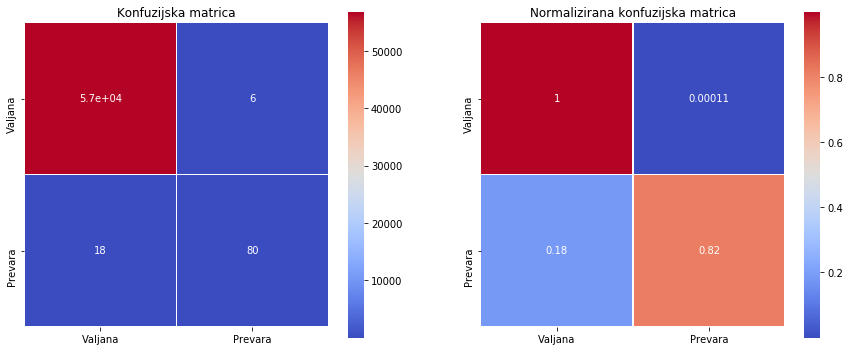

----------------------------------------------------------------------------------------------------


In [9]:
full_pred_xgb_oss = oss_xgb.predict(X_data_test)
print_everything(y_data_test, full_pred_xgb_oss, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

I u ovom slučaju undersampling nije omogućio bolje rezultate, ali jest vjerojatno ubrzao postupak treniranja.

## Odbacivanje outliera

Sljedeće ćemo pronaći ekstremne outliere i izbrisati ih. Time se nadamo da ćemo maknuti pristranost koju ti outlieri nose. Zato trebamo naći koje značajke najviše pridonose klasi koja će biti pridjeljena nekoj transakciji, odnosno trebamo naći značajke kod kojih je najveća pozitivna ili negativna korelacija. Koristimo podatke dobivene nasumičnim undersamplingom (jer je to bila najbolja undersampling metoda).

In [4]:
usample_train = X_usample_train
usample_train['Class'] = y_usample_train

In [5]:
print('Negativne korelacije: ' + str(np.where(usample_train.corr()['Class'] < -0.6))) 
print('Pozitivne korelacije: ' + str(np.where(usample_train.corr()['Class'] > 0.6)))    

Negativne korelacije: (array([10, 12, 14], dtype=int64),)
Pozitivne korelacije: (array([ 4, 11, 29], dtype=int64),)


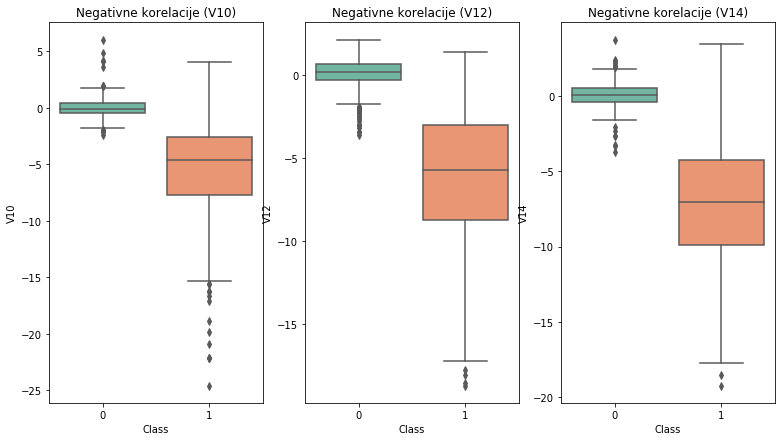

In [6]:
fig_neg, ax_neg = plt.subplots(1, 3, figsize=(13,7))
ax_neg[0].set_title('Negativne korelacije (V10)')
ax_neg[1].set_title('Negativne korelacije (V12)')
ax_neg[2].set_title('Negativne korelacije (V14)')
sns.boxplot(x='Class', y='V10', data=usample_train, ax=ax_neg[0], palette='Set2')
sns.boxplot(x='Class', y='V12', data=usample_train, ax=ax_neg[1], palette='Set2')
sns.boxplot(x='Class', y='V14', data=usample_train, ax=ax_neg[2], palette='Set2')
plt.show()


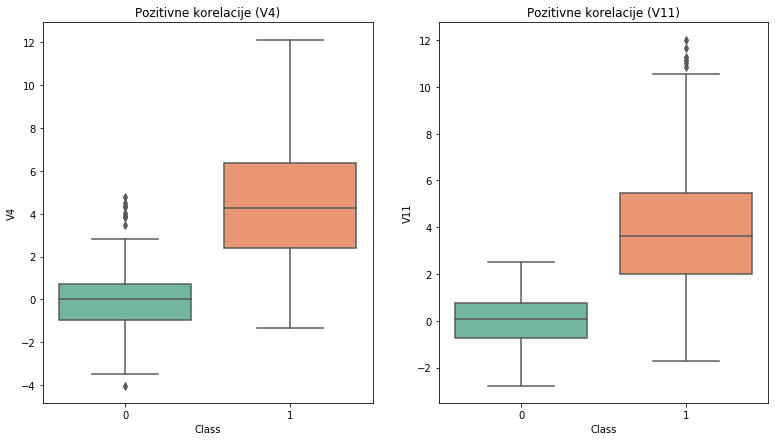

In [7]:
fig_pos, ax_pos = plt.subplots(1, 2, figsize=(13,7))
ax_pos[0].set_title('Pozitivne korelacije (V4)')
ax_pos[1].set_title('Pozitivne korelacije (V11)')
sns.boxplot(x='Class', y='V4', data=usample_train, ax=ax_pos[0], palette='Set2')
sns.boxplot(x='Class', y='V11', data=usample_train, ax=ax_pos[1], palette='Set2')
plt.show()

<b>Napomena</b>: Primjetimo da je posljednja pozitivna značajka (29) ustvari značajka 'Class' koja je sigurno korelirana sama sa sobom pa nju ne koristimo za izbacivanje outliera.

In [8]:
#uklanjanje outliera (za negativnu korelaciju)
v10_q1 = usample_train['V10'].quantile(0.25)
v10_q3 = usample_train['V10'].quantile(0.75)
v10_q2 = v10_q3 - v10_q1
v10_cut_off = v10_q2 * 1.5
v10_lower, v10_upper = v10_q1 - v10_cut_off, v10_q3 + v10_cut_off
v10_outliers = [out for out in usample_train['V10'] if out < v10_lower or out > v10_upper]
print('-' * 50)
print('Broj identificiranih outliera nad V10: ' + str(len(v10_outliers)))

v12_q1 = usample_train['V12'].quantile(0.25)
v12_q3 = usample_train['V12'].quantile(0.75)
v12_q2 = v12_q3 - v12_q1
v12_cut_off = v12_q2 * 1.5
v12_lower, v12_upper = v12_q1 - v12_cut_off, v12_q3 + v12_cut_off
v12_outliers = [out for out in usample_train['V12'] if out < v12_lower or out > v12_upper]
print('Broj identificiranih outliera nad V12: ' + str(len(v12_outliers)))

v14_q1 = usample_train['V14'].quantile(0.25)
v14_q3 = usample_train['V14'].quantile(0.75)
v14_q2 = v14_q3 - v14_q1
v14_cut_off = v14_q2 * 1.5
v14_lower, v14_upper = v14_q1 - v14_cut_off, v14_q3 + v14_cut_off
v14_outliers = [out for out in usample_train['V14'] if out < v14_lower or out > v14_upper]
print('Broj identificiranih outliera nad V14: ' + str(len(v14_outliers)))
print('-' * 50)

--------------------------------------------------
Broj identificiranih outliera nad V10: 57
Broj identificiranih outliera nad V12: 28
Broj identificiranih outliera nad V14: 2
--------------------------------------------------


In [9]:
#uklanjanje outliera (za pozitivne korelaciju)
v4_q1 = usample_train['V4'].quantile(0.25)
v4_q3 = usample_train['V4'].quantile(0.75)
v4_q2 = v4_q3 - v4_q1
v4_cut_off = v4_q2 * 1.5
v4_lower, v4_upper = v4_q1 - v4_cut_off, v4_q3 + v4_cut_off
v4_outliers = [out for out in usample_train['V4'] if out < v4_lower or out > v4_upper]
print('-' * 50)
print('Broj identificiranih outliera nad V4: ' + str(len(v4_outliers)))

v11_q1 = usample_train['V11'].quantile(0.25)
v11_q3 = usample_train['V11'].quantile(0.75)
v11_q2 = v11_q3 - v11_q1
v11_cut_off = v11_q2 * 1.5
v11_lower, v11_upper = v11_q1 - v11_cut_off, v11_q3 + v11_cut_off
v11_outliers = [out for out in usample_train['V11'] if out < v11_lower or out > v11_upper]
print('Broj identificiranih outliera nad V11: ' + str(len(v11_outliers)))
print('-' * 50)

--------------------------------------------------
Broj identificiranih outliera nad V4: 11
Broj identificiranih outliera nad V11: 17
--------------------------------------------------


In [10]:
usample_train_cut = usample_train.drop(
    usample_train[
        (usample_train['V10'] > v10_upper) | 
        (usample_train['V10'] < v10_lower) |
        (usample_train['V12'] > v12_upper) | 
        (usample_train['V12'] < v12_lower) |
        (usample_train['V14'] > v14_upper) | 
        (usample_train['V14'] < v14_lower) |
        (usample_train['V4'] > v4_upper) | 
        (usample_train['V4'] < v4_lower) |
        (usample_train['V11'] > v11_upper) | 
        (usample_train['V11'] < v11_lower) 
                     ].index)

In [11]:
X_usample_train_cut = usample_train_cut.drop('Class', axis=1)
y_usample_train_cut = usample_train_cut['Class']
y_cut_non_frauds = y_usample_train_cut.value_counts()[0]
y_cut_frauds = y_usample_train_cut.value_counts()[1]
print('Broj prevara u skupu za trening nakon izbacivanja outliera: ' + str(y_cut_frauds))
print('Broj valjanih transakcija u skupu za trening nakon izbacivanja outliera: ' + str(y_cut_non_frauds))
print('Ukupan broj transakcija korištenih za trening nakon izbacivanja outliera: ' + str(len(usample_train_cut)))

print('Postotak prevara u skupu za trening nakon izbacivanja outliera: ' + str(round(y_cut_frauds/len(usample_train_cut), 3) * 100) + '%')
print('Postotak valjanih transakcija u skupu za trening nakon izbacivanja outliera: ' + str(round(y_cut_non_frauds/len(usample_train_cut), 3) * 100) + '%')

Broj prevara u skupu za trening nakon izbacivanja outliera: 331
Broj valjanih transakcija u skupu za trening nakon izbacivanja outliera: 394
Ukupan broj transakcija korištenih za trening nakon izbacivanja outliera: 725
Postotak prevara u skupu za trening nakon izbacivanja outliera: 45.7%
Postotak valjanih transakcija u skupu za trening nakon izbacivanja outliera: 54.300000000000004%


Vidimo da je izbacivanjem outliera ostalo malo više valjanih transakcija nego prevara, no u originalnom skupu podataka ionako ima više valjanih transakcija. <br>
<b>Napomena</b>: Primjetimo da su ustvari jedino prevare izbačene iz trening skupa, odnosno prije izbacivanja outliera je bilo 394 prevare i 394 valjane transakcije (sve valjane su i dalje u skupu).

### Logistička regresija

In [40]:
grid_log_reg_cut = GridSearchCV(LogisticRegression(solver='liblinear'), log_reg_params)
grid_log_reg_cut.fit(X_usample_train_cut, y_usample_train_cut)
log_reg_est_cut = grid_log_reg_cut.best_estimator_
log_reg_params_cut = grid_log_reg_cut.best_params_
print('Najbolji parametri: ' + str(log_reg_params_cut))

log_reg_training_score_params_usample_cut = cross_val_score(log_reg_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)
print('Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): ' 
     + str(round(log_reg_training_score_params_usample_cut.mean(), 4) * 100) + '%')

Najbolji parametri: {'C': 1, 'penalty': 'l2'}
Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): 93.02%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 3.25%
	Recall score: 92.86%
	F1 score: 6.279999999999999%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     56864
           1       0.03      0.93      0.06        98

    accuracy                           0.95     56962
   macro avg       0.52      0.94      0.52     56962
weighted avg       1.00      0.95      0.97     56962


----------------------------------------------------------------------------------------------------


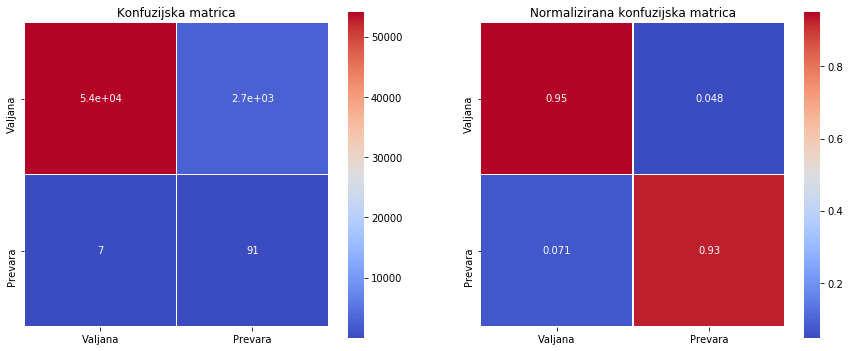

----------------------------------------------------------------------------------------------------


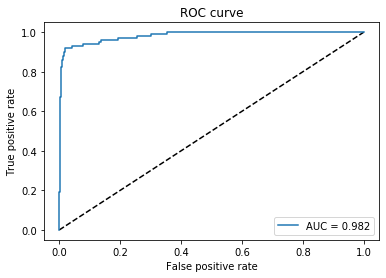

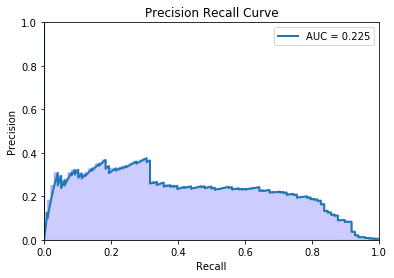

In [41]:
full_pred_log_reg_params_cut = log_reg_est_cut.predict(X_data_test)
full_pred_score_log_reg_params_cut = log_reg_est_cut.decision_function(X_data_test)
print_everything(y_data_test, full_pred_log_reg_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, full_pred_score_log_reg_params_cut, True)

Nakon odbacivanja outliera dobivamo generalno nešto lošije rezultate nego prije odbacivanja. Vidimo da je osjetljivost viša (92.86%), dok su i preciznost (3.25%) i f1-mjera (6.28%) nešto niži. Odnosno, gledajući matricu konfuzije vidimo da je ovaj klasifikator pogrešno klasificirao čak ~2700 valjanih transakcija, ali je zato ispravno klasificirao čak 91 prevaru. Također, možemo primjetiti da je površina ispod PR-krivulje dosta manja.

### Stabla odluke

In [44]:
grid_dt_cut = GridSearchCV(DecisionTreeClassifier(), dt_params)
grid_dt_cut.fit(X_usample_train_cut, y_usample_train_cut)
dt_est_cut = grid_dt_cut.best_estimator_
dt_params_best_cut = grid_dt_cut.best_params_
print('Najbolji parametri: ' + str(dt_params_best_cut))

dt_training_score_params_usample_cut = cross_val_score(dt_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)
print('Rezultat treniranja za stabla odluke nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): ' 
     + str(round(dt_training_score_params_usample_cut.mean(), 4) * 100) + '%')

Najbolji parametri: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 3, 'splitter': 'random'}
Rezultat treniranja za stabla odluke nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): 91.60000000000001%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 3.3099999999999996%
	Recall score: 90.82000000000001%
	F1 score: 6.38%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     56864
           1       0.03      0.91      0.06        98

    accuracy                           0.95     56962
   macro avg       0.52      0.93      0.52     56962
weighted avg       1.00      0.95      0.97     56962


----------------------------------------------------------------------------------------------------


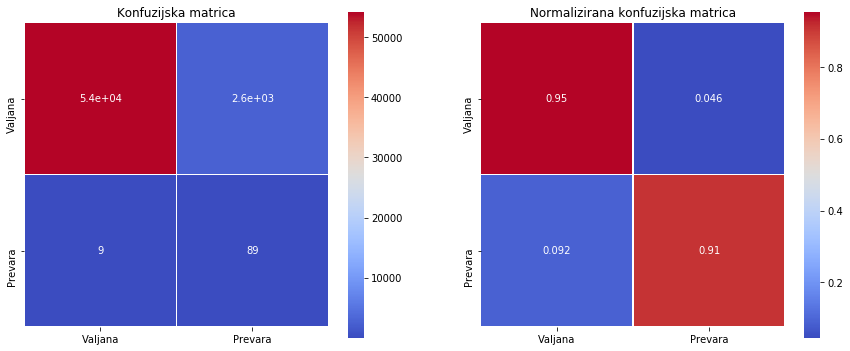

----------------------------------------------------------------------------------------------------


In [45]:
full_pred_dt_params_cut = dt_est_cut.predict(X_data_test)
print_everything(y_data_test, full_pred_dt_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Izbacivanjem outliera dobili smo nešto bolje rezultate za stabla odluke (u odnosu na prije odbacivanja). Odnosno, i preciznost (3.31%) i f1-mjera (6.38%) su više, dok je osjetljivost ostala ista (90.82%). Iz konfuzijske matrice vidimo da je sada pogrešno klasificirano ~2600 valjanih transakcija (bilo je ~4800), dok je ispravno klasificirano 89 prevara.

### Bagging 

In [48]:
grid_bag_cut = GridSearchCV(BaggingClassifier(), bag_params)
grid_bag_cut.fit(X_usample_train_cut, y_usample_train_cut)
bag_est_cut = grid_bag_cut.best_estimator_
bag_params_best_cut = grid_bag_cut.best_params_
print('Najbolji parametri: ' + str(bag_params_best_cut))

bag_training_score_params_usample_cut = cross_val_score(bag_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)
print('Rezultat treniranja za bagging klasifikator nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): ' 
     + str(round(bag_training_score_params_usample_cut.mean(), 4) * 100) + '%')

Najbolji parametri: {'max_features': 0.5, 'max_samples': 0.9, 'n_estimators': 100}
Rezultat treniranja za bagging klasifikator nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): 92.42%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.41%
	Recall score: 92.86%
	F1 score: 10.22%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.93      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


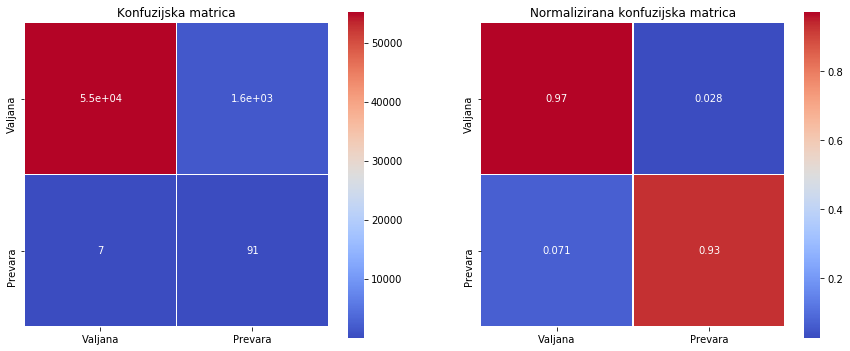

----------------------------------------------------------------------------------------------------


In [49]:
full_pred_bag_params_cut = bag_est_cut.predict(X_data_test)
print_everything(y_data_test, full_pred_bag_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Kod bagginga smo kao i kod logističke regresije dobili nešto nižu preciznost (5.41%), te f1-mjeru (10.22%), dok je osjetljivost nešto viša (92.86%). Iz konfuzijske matrice vidimo da je pogrešno klasificirano ~1600 valjanih transakcija (najmanje od svih klasifikatora nakon izbacivanja outliera dosad) te je ispravno klasificirano čak 91 prevara (najviše od svih klasifikatora nakon izbacivanja outliera dosad).

### Slučajne šume

In [51]:
grid_rf_cut = GridSearchCV(RandomForestClassifier(), rf_params)
grid_rf_cut.fit(X_usample_train_cut, y_usample_train_cut)
rf_est_cut = grid_rf_cut.best_estimator_
rf_params_best_cut = grid_rf_cut.best_params_
print('Najbolji parametri: ' + str(rf_params_best_cut))

rf_training_score_params_usample_cut = cross_val_score(rf_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)
print('Rezultat treniranja za slučajne šume nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): ' 
     + str(round(rf_training_score_params_usample_cut.mean(), 4) * 100) + '%')

Najbolji parametri: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 7, 'n_estimators': 10}
Rezultat treniranja za slučajne šume nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): 92.05%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 4.96%
	Recall score: 91.84%
	F1 score: 9.42%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.92      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


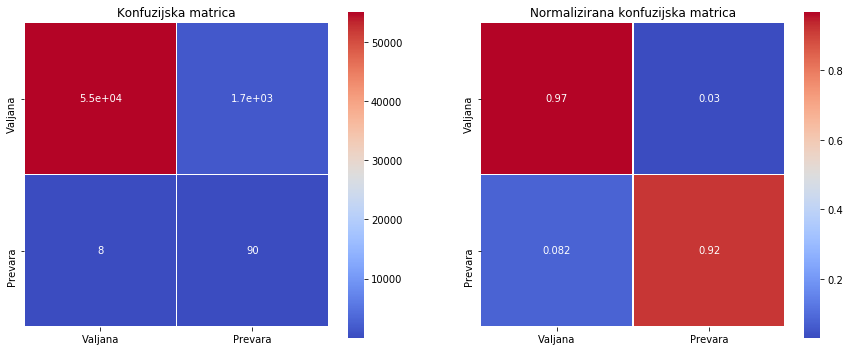

----------------------------------------------------------------------------------------------------


In [52]:
full_pred_rf_params_cut = rf_est_cut.predict(X_data_test)
print_everything(y_data_test, full_pred_rf_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Koristeći slučajne šume dobili smo slične rezultate kao i baggingom, no ipak su i preciznost (4.96%), i osjetljivost (91.84%) i f1-mjera (9.42%) niže. Iz matrice konfuzije viidmo da je ovaj klasifikator pogrešno klasificirao ~1700 valjanih transakcija (100 više od bagginga) te ispravno klasificirao 90 prevara (1 manje od bagginga).

### Metoda najbližih susjeda

In [56]:
grid_knn_cut = GridSearchCV(KNeighborsClassifier(), knn_params)
grid_knn_cut.fit(X_usample_train_cut, y_usample_train_cut)
knn_est_cut = grid_knn_cut.best_estimator_
knn_params_best_cut = grid_knn_cut.best_params_
print('Najbolji parametri: ' + str(knn_params_best_cut))

knn_training_score_params_usample_cut = cross_val_score(knn_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)
print('Rezultat treniranja za k (' +  str(knn_params_best_cut['n_neighbors']) + 
      ')  najbližih susjeda nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): ' 
     + str(round(knn_training_score_params_usample_cut.mean(), 4) * 100) + '%')

Najbolji parametri: {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 5, 'p': 2}
Rezultat treniranja za k (5)  najbližih susjeda nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): 93.07%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.57%
	Recall score: 90.82000000000001%
	F1 score: 10.5%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.91      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


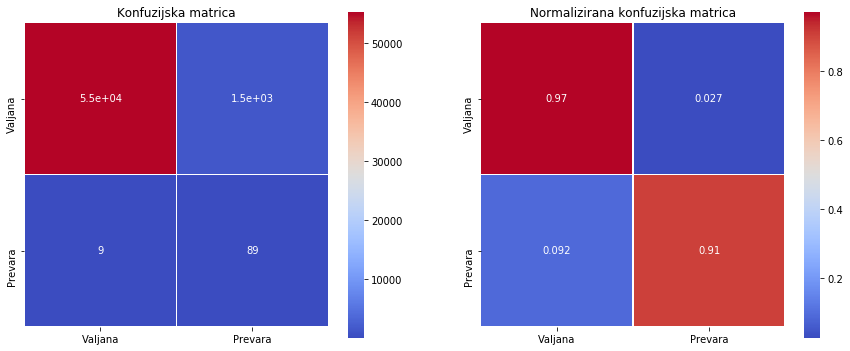

----------------------------------------------------------------------------------------------------


In [57]:
full_pred_knn_params_cut = knn_est_cut.predict(X_data_test)
print_everything(y_data_test, full_pred_knn_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

I za metodu najbližih susjeda dobijamo slične rezultate. Sada je osjetljivost (90.82%) malo niža, ali su zasad i preciznost (5.57%) i f1-mjera (10.5%) najviši dosad. Odnosno, pogrešno je klasificirano ~1500 valjanih transakcija (~100 manje nego kod slučajnih šuma), dok je ispravno klasificirano 89 prevara (1 manje od slučajnih šuma).

### Metoda potpornih vektora

In [61]:
grid_svc_cut = GridSearchCV(SVC(), svc_params)
grid_svc_cut.fit(X_usample_train_cut, y_usample_train_cut)
svc_est_cut = grid_svc_cut.best_estimator_
svc_params_best_cut = grid_svc_cut.best_params_
print('Najbolji parametri: ' + str(svc_params_best_cut))

svc_training_score_params_usample_cut = cross_val_score(svc_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)
print('Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): ' 
     + str(round(svc_training_score_params_usample_cut.mean(), 4) * 100) + '%')

Najbolji parametri: {'C': 0.001, 'degree': 1, 'gamma': 10, 'kernel': 'poly'}
Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom (sa parametrima, nakon izbacivanja outliera): 93.28999999999999%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 8.27%
	Recall score: 90.82000000000001%
	F1 score: 15.160000000000002%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.91      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


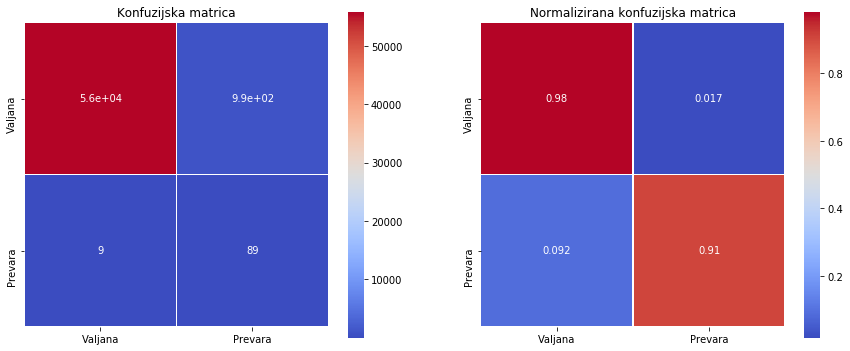

----------------------------------------------------------------------------------------------------


In [62]:
full_pred_svc_params_cut = svc_est_cut.predict(X_data_test)
print_everything(y_data_test, full_pred_svc_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)

Koristeći metodu potpornih vektora dobili smo dosta višu preciznost (8.27%) i f1-mjeru (15.16%), dok je osjetljivost kao i kod većine klasifikatora 90.82%. To znači da opet imamo 89 ispravno klasificiranih prevara (jedanko kao i najbliži susjedi), dok je pogrešno klasificirano svega ~990 valjanih transakcija (~500 manje nego najbliži susjedi).

### Boosting

In [18]:
grid_xgb_cut = GridSearchCV(XGBClassifier(), xgb_params)
grid_xgb_cut.fit(X_usample_train_cut, y_usample_train_cut)
xgb_est_cut = grid_xgb_cut.best_estimator_
xgb_params_best_cut = grid_xgb_cut.best_params_

In [21]:
grid_lgbm_cut = GridSearchCV(LGBMClassifier(), lgbm_params)
grid_lgbm_cut.fit(X_usample_train_cut, y_usample_train_cut)
lgbm_est_cut = grid_lgbm_cut.best_estimator_
lgbm_params_best_cut = grid_lgbm_cut.best_params_

C:\Users\stvar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\stvar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 805, in fit
    callbacks=callbacks)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 600, in fit
    callbacks=callbacks)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\basic.py", line 1716, in __init__
    ctypes.byref(self.handle)))
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\basic.py", li

In [22]:
grid_cat_cut = GridSearchCV(CatBoostClassifier(), cat_params)
grid_cat_cut.fit(X_usample_train_cut, y_usample_train_cut)
cat_est_cut = grid_cat_cut.best_estimator_
cat_params_best_cut = grid_cat_cut.best_params_

0:	learn: 0.4541411	total: 96.3ms	remaining: 867ms
1:	learn: 0.3321465	total: 97.7ms	remaining: 391ms
2:	learn: 0.2832727	total: 98.9ms	remaining: 231ms
3:	learn: 0.2472411	total: 100ms	remaining: 150ms
4:	learn: 0.2299699	total: 101ms	remaining: 101ms
5:	learn: 0.2135462	total: 102ms	remaining: 68.3ms
6:	learn: 0.2051868	total: 104ms	remaining: 44.4ms
7:	learn: 0.1989389	total: 105ms	remaining: 26.2ms
8:	learn: 0.1893559	total: 106ms	remaining: 11.8ms
9:	learn: 0.1859368	total: 107ms	remaining: 0us
0:	learn: 0.4440900	total: 1.32ms	remaining: 11.9ms
1:	learn: 0.3228267	total: 2.6ms	remaining: 10.4ms
2:	learn: 0.2762934	total: 3.84ms	remaining: 8.97ms
3:	learn: 0.2410516	total: 5.09ms	remaining: 7.64ms
4:	learn: 0.2225941	total: 6.35ms	remaining: 6.35ms
5:	learn: 0.2114773	total: 7.59ms	remaining: 5.06ms
6:	learn: 0.1992712	total: 8.82ms	remaining: 3.78ms
7:	learn: 0.1951370	total: 10ms	remaining: 2.51ms
8:	learn: 0.1916963	total: 11.3ms	remaining: 1.26ms
9:	learn: 0.1837009	total: 12.

20:	learn: 0.1529813	total: 32.1ms	remaining: 44.4ms
21:	learn: 0.1511149	total: 33.9ms	remaining: 43.2ms
22:	learn: 0.1503059	total: 35.5ms	remaining: 41.7ms
23:	learn: 0.1484529	total: 36.9ms	remaining: 39.9ms
24:	learn: 0.1469506	total: 38.6ms	remaining: 38.6ms
25:	learn: 0.1436380	total: 40.1ms	remaining: 37ms
26:	learn: 0.1431222	total: 41.5ms	remaining: 35.4ms
27:	learn: 0.1413918	total: 43.1ms	remaining: 33.8ms
28:	learn: 0.1398033	total: 44.5ms	remaining: 32.2ms
29:	learn: 0.1385550	total: 46.2ms	remaining: 30.8ms
30:	learn: 0.1376942	total: 47.7ms	remaining: 29.2ms
31:	learn: 0.1364551	total: 49.3ms	remaining: 27.8ms
32:	learn: 0.1344015	total: 50.9ms	remaining: 26.2ms
33:	learn: 0.1337484	total: 52.4ms	remaining: 24.6ms
34:	learn: 0.1331299	total: 53.9ms	remaining: 23.1ms
35:	learn: 0.1311729	total: 55.3ms	remaining: 21.5ms
36:	learn: 0.1290966	total: 56.7ms	remaining: 19.9ms
37:	learn: 0.1279647	total: 58.2ms	remaining: 18.4ms
38:	learn: 0.1260228	total: 59.7ms	remaining: 16

56:	learn: 0.1033565	total: 72.8ms	remaining: 54.9ms
57:	learn: 0.1026110	total: 74ms	remaining: 53.6ms
58:	learn: 0.1014721	total: 75.2ms	remaining: 52.2ms
59:	learn: 0.1010650	total: 76.5ms	remaining: 51ms
60:	learn: 0.1001341	total: 77.6ms	remaining: 49.6ms
61:	learn: 0.0998917	total: 79.9ms	remaining: 49ms
62:	learn: 0.0980876	total: 81.3ms	remaining: 47.7ms
63:	learn: 0.0974677	total: 82.6ms	remaining: 46.4ms
64:	learn: 0.0968168	total: 83.8ms	remaining: 45.1ms
65:	learn: 0.0967195	total: 85.1ms	remaining: 43.8ms
66:	learn: 0.0958717	total: 86.3ms	remaining: 42.5ms
67:	learn: 0.0950033	total: 87.5ms	remaining: 41.2ms
68:	learn: 0.0944344	total: 88.8ms	remaining: 39.9ms
69:	learn: 0.0939201	total: 89.9ms	remaining: 38.5ms
70:	learn: 0.0931062	total: 91.1ms	remaining: 37.2ms
71:	learn: 0.0923187	total: 92.3ms	remaining: 35.9ms
72:	learn: 0.0919757	total: 93.5ms	remaining: 34.6ms
73:	learn: 0.0910986	total: 94.6ms	remaining: 33.3ms
74:	learn: 0.0904631	total: 95.8ms	remaining: 31.9ms

44:	learn: 0.1128572	total: 64.5ms	remaining: 78.8ms
45:	learn: 0.1122367	total: 66.2ms	remaining: 77.7ms
46:	learn: 0.1118777	total: 67.6ms	remaining: 76.3ms
47:	learn: 0.1097632	total: 68.9ms	remaining: 74.7ms
48:	learn: 0.1095255	total: 70.2ms	remaining: 73.1ms
49:	learn: 0.1083103	total: 71.6ms	remaining: 71.6ms
50:	learn: 0.1072149	total: 72.9ms	remaining: 70.1ms
51:	learn: 0.1063251	total: 74.4ms	remaining: 68.7ms
52:	learn: 0.1050643	total: 75.8ms	remaining: 67.2ms
53:	learn: 0.1041029	total: 77.1ms	remaining: 65.7ms
54:	learn: 0.1034577	total: 78.7ms	remaining: 64.4ms
55:	learn: 0.1027098	total: 80.1ms	remaining: 62.9ms
56:	learn: 0.1023465	total: 81.4ms	remaining: 61.4ms
57:	learn: 0.1021730	total: 83ms	remaining: 60.1ms
58:	learn: 0.1007628	total: 84.4ms	remaining: 58.6ms
59:	learn: 0.1001281	total: 85.8ms	remaining: 57.2ms
60:	learn: 0.0997831	total: 87.3ms	remaining: 55.8ms
61:	learn: 0.0986295	total: 88.5ms	remaining: 54.3ms
62:	learn: 0.0980098	total: 90ms	remaining: 52.9

10:	learn: 0.1849105	total: 36.6ms	remaining: 296ms
11:	learn: 0.1795664	total: 40.2ms	remaining: 295ms
12:	learn: 0.1772420	total: 43.5ms	remaining: 291ms
13:	learn: 0.1724095	total: 46.9ms	remaining: 288ms
14:	learn: 0.1709385	total: 50.3ms	remaining: 285ms
15:	learn: 0.1689806	total: 53.6ms	remaining: 282ms
16:	learn: 0.1658483	total: 56.8ms	remaining: 277ms
17:	learn: 0.1641007	total: 60.3ms	remaining: 275ms
18:	learn: 0.1596138	total: 64.3ms	remaining: 274ms
19:	learn: 0.1587463	total: 67.8ms	remaining: 271ms
20:	learn: 0.1566269	total: 71.2ms	remaining: 268ms
21:	learn: 0.1531870	total: 74.6ms	remaining: 265ms
22:	learn: 0.1502399	total: 78.5ms	remaining: 263ms
23:	learn: 0.1497600	total: 82.1ms	remaining: 260ms
24:	learn: 0.1490964	total: 85.8ms	remaining: 257ms
25:	learn: 0.1478206	total: 89ms	remaining: 253ms
26:	learn: 0.1471170	total: 92.4ms	remaining: 250ms
27:	learn: 0.1433720	total: 95.5ms	remaining: 246ms
28:	learn: 0.1401345	total: 99.2ms	remaining: 243ms
29:	learn: 0.1

0:	learn: 0.5950698	total: 3.86ms	remaining: 73.3ms
1:	learn: 0.4979404	total: 7.03ms	remaining: 63.3ms
2:	learn: 0.4461869	total: 10.5ms	remaining: 59.4ms
3:	learn: 0.4122135	total: 13.8ms	remaining: 55.3ms
4:	learn: 0.3749212	total: 17.2ms	remaining: 51.7ms
5:	learn: 0.3471412	total: 20.6ms	remaining: 48.1ms
6:	learn: 0.3253433	total: 23.9ms	remaining: 44.5ms
7:	learn: 0.3061807	total: 27.3ms	remaining: 41ms
8:	learn: 0.2917882	total: 30.7ms	remaining: 37.5ms
9:	learn: 0.2767564	total: 34ms	remaining: 34ms
10:	learn: 0.2644354	total: 37.7ms	remaining: 30.9ms
11:	learn: 0.2556668	total: 41ms	remaining: 27.3ms
12:	learn: 0.2469230	total: 44.4ms	remaining: 23.9ms
13:	learn: 0.2386228	total: 47.7ms	remaining: 20.4ms
14:	learn: 0.2326350	total: 51ms	remaining: 17ms
15:	learn: 0.2227927	total: 54.6ms	remaining: 13.6ms
16:	learn: 0.2182635	total: 58ms	remaining: 10.2ms
17:	learn: 0.2144995	total: 61.4ms	remaining: 6.82ms
18:	learn: 0.2074149	total: 64.9ms	remaining: 3.42ms
19:	learn: 0.2054

0:	learn: 0.5774645	total: 4.19ms	remaining: 205ms
1:	learn: 0.4999741	total: 7.57ms	remaining: 182ms
2:	learn: 0.4574975	total: 11.2ms	remaining: 176ms
3:	learn: 0.4266873	total: 14.8ms	remaining: 171ms
4:	learn: 0.3953071	total: 18.6ms	remaining: 168ms
5:	learn: 0.3719647	total: 22.8ms	remaining: 167ms
6:	learn: 0.3461031	total: 26.3ms	remaining: 162ms
7:	learn: 0.3278504	total: 30.7ms	remaining: 161ms
8:	learn: 0.3123925	total: 34.7ms	remaining: 158ms
9:	learn: 0.3014857	total: 38.8ms	remaining: 155ms
10:	learn: 0.2876882	total: 42.7ms	remaining: 152ms
11:	learn: 0.2777516	total: 46.9ms	remaining: 148ms
12:	learn: 0.2707298	total: 50.5ms	remaining: 144ms
13:	learn: 0.2639150	total: 54.2ms	remaining: 139ms
14:	learn: 0.2599385	total: 58.1ms	remaining: 136ms
15:	learn: 0.2546626	total: 61.6ms	remaining: 131ms
16:	learn: 0.2495404	total: 65ms	remaining: 126ms
17:	learn: 0.2457887	total: 68.2ms	remaining: 121ms
18:	learn: 0.2428519	total: 73.1ms	remaining: 119ms
19:	learn: 0.2391701	tot

11:	learn: 0.2447020	total: 39.9ms	remaining: 293ms
12:	learn: 0.2389324	total: 43.5ms	remaining: 291ms
13:	learn: 0.2315326	total: 46.8ms	remaining: 288ms
14:	learn: 0.2247943	total: 50.1ms	remaining: 284ms
15:	learn: 0.2170628	total: 53.5ms	remaining: 281ms
16:	learn: 0.2117681	total: 56.7ms	remaining: 277ms
17:	learn: 0.2085834	total: 60ms	remaining: 273ms
18:	learn: 0.2055933	total: 63.3ms	remaining: 270ms
19:	learn: 0.2019272	total: 66.7ms	remaining: 267ms
20:	learn: 0.1983857	total: 70ms	remaining: 263ms
21:	learn: 0.1973063	total: 73.3ms	remaining: 260ms
22:	learn: 0.1961983	total: 76.7ms	remaining: 257ms
23:	learn: 0.1947860	total: 80.7ms	remaining: 255ms
24:	learn: 0.1925342	total: 84ms	remaining: 252ms
25:	learn: 0.1900434	total: 87.3ms	remaining: 248ms
26:	learn: 0.1891756	total: 90.6ms	remaining: 245ms
27:	learn: 0.1879168	total: 93.9ms	remaining: 241ms
28:	learn: 0.1854631	total: 97.1ms	remaining: 238ms
29:	learn: 0.1843234	total: 100ms	remaining: 234ms
30:	learn: 0.183011

0:	learn: 0.5774645	total: 4.29ms	remaining: 425ms
1:	learn: 0.4999741	total: 8.01ms	remaining: 392ms
2:	learn: 0.4574975	total: 12.4ms	remaining: 400ms
3:	learn: 0.4266873	total: 15.9ms	remaining: 382ms
4:	learn: 0.3953071	total: 20.4ms	remaining: 388ms
5:	learn: 0.3719647	total: 23.7ms	remaining: 372ms
6:	learn: 0.3461031	total: 27.2ms	remaining: 361ms
7:	learn: 0.3278504	total: 31.2ms	remaining: 359ms
8:	learn: 0.3123925	total: 34.6ms	remaining: 350ms
9:	learn: 0.3014857	total: 38.6ms	remaining: 347ms
10:	learn: 0.2876882	total: 42ms	remaining: 339ms
11:	learn: 0.2777516	total: 45.3ms	remaining: 332ms
12:	learn: 0.2707298	total: 49.2ms	remaining: 329ms
13:	learn: 0.2639150	total: 52.6ms	remaining: 323ms
14:	learn: 0.2599385	total: 57.3ms	remaining: 325ms
15:	learn: 0.2546626	total: 61.9ms	remaining: 325ms
16:	learn: 0.2495404	total: 65.2ms	remaining: 318ms
17:	learn: 0.2457887	total: 69ms	remaining: 314ms
18:	learn: 0.2428519	total: 72.5ms	remaining: 309ms
19:	learn: 0.2391701	total

8:	learn: 0.4066308	total: 11.3ms	remaining: 1.25ms
9:	learn: 0.3898138	total: 12.5ms	remaining: 0us
0:	learn: 0.6392853	total: 3.06ms	remaining: 27.5ms
1:	learn: 0.5925635	total: 5.52ms	remaining: 22.1ms
2:	learn: 0.5463022	total: 8.51ms	remaining: 19.8ms
3:	learn: 0.5048535	total: 11.1ms	remaining: 16.6ms
4:	learn: 0.4850230	total: 13.5ms	remaining: 13.5ms
5:	learn: 0.4509264	total: 16.1ms	remaining: 10.8ms
6:	learn: 0.4236830	total: 18.7ms	remaining: 8ms
7:	learn: 0.4017115	total: 21.3ms	remaining: 5.33ms
8:	learn: 0.3809069	total: 23.9ms	remaining: 2.65ms
9:	learn: 0.3681126	total: 26.5ms	remaining: 0us
0:	learn: 0.6417543	total: 1.93ms	remaining: 17.4ms
1:	learn: 0.5831010	total: 3.67ms	remaining: 14.7ms
2:	learn: 0.5476231	total: 5.37ms	remaining: 12.5ms
3:	learn: 0.5233746	total: 7.58ms	remaining: 11.4ms
4:	learn: 0.4821870	total: 8.8ms	remaining: 8.8ms
5:	learn: 0.4503134	total: 10.1ms	remaining: 6.75ms
6:	learn: 0.4293568	total: 11.4ms	remaining: 4.87ms
7:	learn: 0.4083493	tot

24:	learn: 0.2592092	total: 34.9ms	remaining: 34.9ms
25:	learn: 0.2556382	total: 36.6ms	remaining: 33.8ms
26:	learn: 0.2516664	total: 38.2ms	remaining: 32.5ms
27:	learn: 0.2486416	total: 39.4ms	remaining: 30.9ms
28:	learn: 0.2458907	total: 40.8ms	remaining: 29.5ms
29:	learn: 0.2441548	total: 42ms	remaining: 28ms
30:	learn: 0.2413355	total: 43.3ms	remaining: 26.6ms
31:	learn: 0.2386437	total: 44.5ms	remaining: 25ms
32:	learn: 0.2359761	total: 45.9ms	remaining: 23.6ms
33:	learn: 0.2336381	total: 47.1ms	remaining: 22.2ms
34:	learn: 0.2312964	total: 48.5ms	remaining: 20.8ms
35:	learn: 0.2287971	total: 49.7ms	remaining: 19.3ms
36:	learn: 0.2269059	total: 51ms	remaining: 17.9ms
37:	learn: 0.2250731	total: 52.4ms	remaining: 16.5ms
38:	learn: 0.2225312	total: 53.7ms	remaining: 15.2ms
39:	learn: 0.2209743	total: 55.2ms	remaining: 13.8ms
40:	learn: 0.2191479	total: 56.5ms	remaining: 12.4ms
41:	learn: 0.2179379	total: 57.9ms	remaining: 11ms
42:	learn: 0.2170884	total: 59.3ms	remaining: 9.65ms
43:

0:	learn: 0.6441365	total: 3.86ms	remaining: 189ms
1:	learn: 0.5902014	total: 7.42ms	remaining: 178ms
2:	learn: 0.5569728	total: 11.3ms	remaining: 177ms
3:	learn: 0.5335833	total: 15.1ms	remaining: 173ms
4:	learn: 0.5004387	total: 19ms	remaining: 171ms
5:	learn: 0.4814119	total: 22.1ms	remaining: 162ms
6:	learn: 0.4541733	total: 25.5ms	remaining: 157ms
7:	learn: 0.4312598	total: 28.9ms	remaining: 152ms
8:	learn: 0.4069222	total: 32.2ms	remaining: 147ms
9:	learn: 0.3908318	total: 35.4ms	remaining: 142ms
10:	learn: 0.3740061	total: 38.7ms	remaining: 137ms
11:	learn: 0.3592747	total: 41.9ms	remaining: 133ms
12:	learn: 0.3488564	total: 45.2ms	remaining: 129ms
13:	learn: 0.3387334	total: 48.3ms	remaining: 124ms
14:	learn: 0.3296058	total: 51.5ms	remaining: 120ms
15:	learn: 0.3201781	total: 54.8ms	remaining: 116ms
16:	learn: 0.3129075	total: 58ms	remaining: 113ms
17:	learn: 0.3018026	total: 61.5ms	remaining: 109ms
18:	learn: 0.2940648	total: 64.7ms	remaining: 106ms
19:	learn: 0.2875778	total

82:	learn: 0.1715067	total: 100ms	remaining: 20.5ms
83:	learn: 0.1707910	total: 102ms	remaining: 19.3ms
84:	learn: 0.1700274	total: 103ms	remaining: 18.1ms
85:	learn: 0.1696728	total: 104ms	remaining: 16.9ms
86:	learn: 0.1693911	total: 105ms	remaining: 15.7ms
87:	learn: 0.1689634	total: 106ms	remaining: 14.5ms
88:	learn: 0.1685198	total: 108ms	remaining: 13.3ms
89:	learn: 0.1681258	total: 109ms	remaining: 12.1ms
90:	learn: 0.1677664	total: 110ms	remaining: 10.9ms
91:	learn: 0.1675338	total: 111ms	remaining: 9.68ms
92:	learn: 0.1671186	total: 113ms	remaining: 8.47ms
93:	learn: 0.1670332	total: 114ms	remaining: 7.27ms
94:	learn: 0.1666719	total: 115ms	remaining: 6.06ms
95:	learn: 0.1662992	total: 117ms	remaining: 4.86ms
96:	learn: 0.1658487	total: 118ms	remaining: 3.65ms
97:	learn: 0.1653746	total: 119ms	remaining: 2.43ms
98:	learn: 0.1650623	total: 120ms	remaining: 1.22ms
99:	learn: 0.1646428	total: 122ms	remaining: 0us
0:	learn: 0.6417543	total: 1.57ms	remaining: 156ms
1:	learn: 0.5831

85:	learn: 0.1995040	total: 104ms	remaining: 17ms
86:	learn: 0.1991519	total: 106ms	remaining: 15.8ms
87:	learn: 0.1987519	total: 107ms	remaining: 14.6ms
88:	learn: 0.1982185	total: 108ms	remaining: 13.4ms
89:	learn: 0.1979135	total: 110ms	remaining: 12.2ms
90:	learn: 0.1973941	total: 111ms	remaining: 10.9ms
91:	learn: 0.1971230	total: 112ms	remaining: 9.73ms
92:	learn: 0.1966600	total: 113ms	remaining: 8.51ms
93:	learn: 0.1957866	total: 114ms	remaining: 7.29ms
94:	learn: 0.1953699	total: 115ms	remaining: 6.07ms
95:	learn: 0.1947492	total: 117ms	remaining: 4.86ms
96:	learn: 0.1944671	total: 118ms	remaining: 3.64ms
97:	learn: 0.1939243	total: 119ms	remaining: 2.43ms
98:	learn: 0.1933630	total: 120ms	remaining: 1.21ms
99:	learn: 0.1925695	total: 121ms	remaining: 0us
0:	learn: 0.6441365	total: 1.39ms	remaining: 138ms
1:	learn: 0.5902014	total: 2.59ms	remaining: 127ms
2:	learn: 0.5569728	total: 3.91ms	remaining: 126ms
3:	learn: 0.5335833	total: 5.26ms	remaining: 126ms
4:	learn: 0.5004387	t

0:	learn: 0.6819555	total: 2.2ms	remaining: 41.9ms
1:	learn: 0.6713543	total: 4.14ms	remaining: 37.3ms
2:	learn: 0.6626731	total: 5.94ms	remaining: 33.7ms
3:	learn: 0.6514746	total: 8.14ms	remaining: 32.6ms
4:	learn: 0.6400942	total: 9.99ms	remaining: 30ms
5:	learn: 0.6322673	total: 11.8ms	remaining: 27.6ms
6:	learn: 0.6240236	total: 14.3ms	remaining: 26.6ms
7:	learn: 0.6162818	total: 16.1ms	remaining: 24.2ms
8:	learn: 0.6062715	total: 17.9ms	remaining: 21.9ms
9:	learn: 0.5982040	total: 19.9ms	remaining: 19.9ms
10:	learn: 0.5909742	total: 22ms	remaining: 18ms
11:	learn: 0.5804175	total: 23.8ms	remaining: 15.9ms
12:	learn: 0.5730260	total: 26.1ms	remaining: 14ms
13:	learn: 0.5664888	total: 27.7ms	remaining: 11.9ms
14:	learn: 0.5593323	total: 29.5ms	remaining: 9.82ms
15:	learn: 0.5511201	total: 31.3ms	remaining: 7.82ms
16:	learn: 0.5446198	total: 33.2ms	remaining: 5.86ms
17:	learn: 0.5367885	total: 35.5ms	remaining: 3.94ms
18:	learn: 0.5293595	total: 37.3ms	remaining: 1.96ms
19:	learn: 0

22:	learn: 0.5007916	total: 32.2ms	remaining: 37.8ms
23:	learn: 0.4955343	total: 33.8ms	remaining: 36.7ms
24:	learn: 0.4912999	total: 35.3ms	remaining: 35.3ms
25:	learn: 0.4860137	total: 36.6ms	remaining: 33.8ms
26:	learn: 0.4803675	total: 37.9ms	remaining: 32.3ms
27:	learn: 0.4750358	total: 39.1ms	remaining: 30.7ms
28:	learn: 0.4711863	total: 40.4ms	remaining: 29.2ms
29:	learn: 0.4660583	total: 41.6ms	remaining: 27.7ms
30:	learn: 0.4608947	total: 42.9ms	remaining: 26.3ms
31:	learn: 0.4573020	total: 44.1ms	remaining: 24.8ms
32:	learn: 0.4540813	total: 45.5ms	remaining: 23.4ms
33:	learn: 0.4504110	total: 46.8ms	remaining: 22ms
34:	learn: 0.4462496	total: 48.1ms	remaining: 20.6ms
35:	learn: 0.4423314	total: 49.5ms	remaining: 19.2ms
36:	learn: 0.4380893	total: 50.8ms	remaining: 17.9ms
37:	learn: 0.4340959	total: 52.2ms	remaining: 16.5ms
38:	learn: 0.4297280	total: 53.5ms	remaining: 15.1ms
39:	learn: 0.4265045	total: 54.9ms	remaining: 13.7ms
40:	learn: 0.4223424	total: 56.2ms	remaining: 12

66:	learn: 0.3409454	total: 210ms	remaining: 103ms
67:	learn: 0.3390235	total: 213ms	remaining: 100ms
68:	learn: 0.3359552	total: 215ms	remaining: 96.5ms
69:	learn: 0.3341193	total: 217ms	remaining: 93.1ms
70:	learn: 0.3324634	total: 219ms	remaining: 89.6ms
71:	learn: 0.3303338	total: 221ms	remaining: 86.1ms
72:	learn: 0.3283270	total: 224ms	remaining: 82.7ms
73:	learn: 0.3256770	total: 226ms	remaining: 79.3ms
74:	learn: 0.3235396	total: 228ms	remaining: 76ms
75:	learn: 0.3215434	total: 230ms	remaining: 72.8ms
76:	learn: 0.3196067	total: 233ms	remaining: 69.5ms
77:	learn: 0.3175099	total: 235ms	remaining: 66.3ms
78:	learn: 0.3160345	total: 237ms	remaining: 63.1ms
79:	learn: 0.3143586	total: 240ms	remaining: 59.9ms
80:	learn: 0.3125793	total: 242ms	remaining: 56.7ms
81:	learn: 0.3101876	total: 244ms	remaining: 53.6ms
82:	learn: 0.3084573	total: 246ms	remaining: 50.4ms
83:	learn: 0.3068922	total: 248ms	remaining: 47.3ms
84:	learn: 0.3053940	total: 251ms	remaining: 44.3ms
85:	learn: 0.303

47:	learn: 0.3943758	total: 165ms	remaining: 179ms
48:	learn: 0.3916857	total: 169ms	remaining: 175ms
49:	learn: 0.3888705	total: 172ms	remaining: 172ms
50:	learn: 0.3863227	total: 175ms	remaining: 168ms
51:	learn: 0.3834329	total: 179ms	remaining: 165ms
52:	learn: 0.3803723	total: 182ms	remaining: 162ms
53:	learn: 0.3782507	total: 186ms	remaining: 158ms
54:	learn: 0.3752557	total: 189ms	remaining: 155ms
55:	learn: 0.3724791	total: 192ms	remaining: 151ms
56:	learn: 0.3704071	total: 195ms	remaining: 147ms
57:	learn: 0.3675999	total: 199ms	remaining: 144ms
58:	learn: 0.3649427	total: 202ms	remaining: 140ms
59:	learn: 0.3623622	total: 206ms	remaining: 137ms
60:	learn: 0.3588050	total: 209ms	remaining: 134ms
61:	learn: 0.3567290	total: 212ms	remaining: 130ms
62:	learn: 0.3539918	total: 215ms	remaining: 126ms
63:	learn: 0.3512125	total: 218ms	remaining: 123ms
64:	learn: 0.3491322	total: 222ms	remaining: 119ms
65:	learn: 0.3462272	total: 225ms	remaining: 116ms
66:	learn: 0.3429804	total: 229

49:	learn: 0.3969413	total: 172ms	remaining: 172ms
50:	learn: 0.3942140	total: 175ms	remaining: 169ms
51:	learn: 0.3912321	total: 179ms	remaining: 165ms
52:	learn: 0.3868818	total: 183ms	remaining: 162ms
53:	learn: 0.3844372	total: 186ms	remaining: 159ms
54:	learn: 0.3814964	total: 190ms	remaining: 155ms
55:	learn: 0.3786759	total: 193ms	remaining: 151ms
56:	learn: 0.3757016	total: 196ms	remaining: 148ms
57:	learn: 0.3732745	total: 200ms	remaining: 145ms
58:	learn: 0.3702069	total: 203ms	remaining: 141ms
59:	learn: 0.3675276	total: 206ms	remaining: 137ms
60:	learn: 0.3650435	total: 209ms	remaining: 134ms
61:	learn: 0.3624842	total: 212ms	remaining: 130ms
62:	learn: 0.3591563	total: 216ms	remaining: 127ms
63:	learn: 0.3565262	total: 219ms	remaining: 123ms
64:	learn: 0.3543361	total: 222ms	remaining: 120ms
65:	learn: 0.3522019	total: 226ms	remaining: 116ms
66:	learn: 0.3501453	total: 229ms	remaining: 113ms
67:	learn: 0.3478856	total: 232ms	remaining: 109ms
68:	learn: 0.3455763	total: 235

0:	learn: 0.4205592	total: 5.15ms	remaining: 97.8ms
1:	learn: 0.3481609	total: 7.57ms	remaining: 68.1ms
2:	learn: 0.2825504	total: 10.4ms	remaining: 59.1ms
3:	learn: 0.2520077	total: 12.8ms	remaining: 51.4ms
4:	learn: 0.2378097	total: 14.9ms	remaining: 44.7ms
5:	learn: 0.2192111	total: 17ms	remaining: 39.6ms
6:	learn: 0.2050002	total: 19ms	remaining: 35.3ms
7:	learn: 0.1970478	total: 21.1ms	remaining: 31.7ms
8:	learn: 0.1896090	total: 23.2ms	remaining: 28.3ms
9:	learn: 0.1846698	total: 25.3ms	remaining: 25.3ms
10:	learn: 0.1799676	total: 27.6ms	remaining: 22.5ms
11:	learn: 0.1784859	total: 29.9ms	remaining: 19.9ms
12:	learn: 0.1716255	total: 32.2ms	remaining: 17.4ms
13:	learn: 0.1684661	total: 34.9ms	remaining: 15ms
14:	learn: 0.1637407	total: 37.1ms	remaining: 12.4ms
15:	learn: 0.1594566	total: 39.1ms	remaining: 9.77ms
16:	learn: 0.1541430	total: 41.1ms	remaining: 7.25ms
17:	learn: 0.1505637	total: 43.1ms	remaining: 4.79ms
18:	learn: 0.1464232	total: 45.6ms	remaining: 2.4ms
19:	learn:

1:	learn: 0.3481609	total: 4.55ms	remaining: 109ms
2:	learn: 0.2825504	total: 6.67ms	remaining: 105ms
3:	learn: 0.2520077	total: 8.78ms	remaining: 101ms
4:	learn: 0.2378097	total: 10.8ms	remaining: 97.4ms
5:	learn: 0.2192111	total: 12.9ms	remaining: 94.7ms
6:	learn: 0.2050002	total: 15ms	remaining: 92ms
7:	learn: 0.1970478	total: 17ms	remaining: 89.3ms
8:	learn: 0.1896090	total: 19.1ms	remaining: 86.9ms
9:	learn: 0.1846698	total: 21.2ms	remaining: 85ms
10:	learn: 0.1799676	total: 23.5ms	remaining: 83.2ms
11:	learn: 0.1784859	total: 25.6ms	remaining: 81.2ms
12:	learn: 0.1716255	total: 27.9ms	remaining: 79.4ms
13:	learn: 0.1684661	total: 30.2ms	remaining: 77.6ms
14:	learn: 0.1637407	total: 32.4ms	remaining: 75.6ms
15:	learn: 0.1594566	total: 35.4ms	remaining: 75.3ms
16:	learn: 0.1541430	total: 37.6ms	remaining: 73.1ms
17:	learn: 0.1505637	total: 39.9ms	remaining: 70.9ms
18:	learn: 0.1464232	total: 42ms	remaining: 68.6ms
19:	learn: 0.1427369	total: 44.1ms	remaining: 66.2ms
20:	learn: 0.13

0:	learn: 0.4239249	total: 5.11ms	remaining: 506ms
1:	learn: 0.3118580	total: 7.26ms	remaining: 356ms
2:	learn: 0.2619565	total: 9.07ms	remaining: 293ms
3:	learn: 0.2187470	total: 11.3ms	remaining: 271ms
4:	learn: 0.1958850	total: 13.9ms	remaining: 263ms
5:	learn: 0.1812133	total: 16ms	remaining: 251ms
6:	learn: 0.1752178	total: 18.2ms	remaining: 242ms
7:	learn: 0.1631097	total: 20.7ms	remaining: 238ms
8:	learn: 0.1593455	total: 22.8ms	remaining: 230ms
9:	learn: 0.1543588	total: 24.9ms	remaining: 224ms
10:	learn: 0.1473069	total: 27.1ms	remaining: 219ms
11:	learn: 0.1396983	total: 29.3ms	remaining: 215ms
12:	learn: 0.1321303	total: 31.5ms	remaining: 211ms
13:	learn: 0.1292397	total: 33.5ms	remaining: 206ms
14:	learn: 0.1282114	total: 35.6ms	remaining: 202ms
15:	learn: 0.1241039	total: 37.7ms	remaining: 198ms
16:	learn: 0.1211400	total: 39.8ms	remaining: 195ms
17:	learn: 0.1182316	total: 41.9ms	remaining: 191ms
18:	learn: 0.1159440	total: 44ms	remaining: 188ms
19:	learn: 0.1140818	total

0:	learn: 0.4205592	total: 3.1ms	remaining: 306ms
1:	learn: 0.3481609	total: 5.27ms	remaining: 258ms
2:	learn: 0.2825504	total: 7.37ms	remaining: 238ms
3:	learn: 0.2520077	total: 9.61ms	remaining: 231ms
4:	learn: 0.2378097	total: 11.6ms	remaining: 221ms
5:	learn: 0.2192111	total: 13.7ms	remaining: 215ms
6:	learn: 0.2050002	total: 15.7ms	remaining: 209ms
7:	learn: 0.1970478	total: 17.8ms	remaining: 204ms
8:	learn: 0.1896090	total: 19.4ms	remaining: 196ms
9:	learn: 0.1846698	total: 21.7ms	remaining: 195ms
10:	learn: 0.1799676	total: 23.4ms	remaining: 189ms
11:	learn: 0.1784859	total: 25.2ms	remaining: 185ms
12:	learn: 0.1716255	total: 27.3ms	remaining: 183ms
13:	learn: 0.1684661	total: 29.1ms	remaining: 179ms
14:	learn: 0.1637407	total: 30.7ms	remaining: 174ms
15:	learn: 0.1594566	total: 32.3ms	remaining: 169ms
16:	learn: 0.1541430	total: 34.6ms	remaining: 169ms
17:	learn: 0.1505637	total: 36.5ms	remaining: 166ms
18:	learn: 0.1464232	total: 38ms	remaining: 162ms
19:	learn: 0.1427369	tota

65:	learn: 0.0447666	total: 110ms	remaining: 56.9ms
66:	learn: 0.0443790	total: 112ms	remaining: 55.3ms
67:	learn: 0.0438693	total: 114ms	remaining: 53.6ms
68:	learn: 0.0436362	total: 116ms	remaining: 51.9ms
69:	learn: 0.0419882	total: 117ms	remaining: 50.2ms
70:	learn: 0.0412865	total: 119ms	remaining: 48.5ms
71:	learn: 0.0407545	total: 121ms	remaining: 47.2ms
72:	learn: 0.0395425	total: 123ms	remaining: 45.5ms
73:	learn: 0.0384054	total: 125ms	remaining: 43.8ms
74:	learn: 0.0377519	total: 127ms	remaining: 42.2ms
75:	learn: 0.0372131	total: 128ms	remaining: 40.5ms
76:	learn: 0.0369382	total: 130ms	remaining: 38.8ms
77:	learn: 0.0365089	total: 132ms	remaining: 37.1ms
78:	learn: 0.0358457	total: 134ms	remaining: 35.5ms
79:	learn: 0.0352905	total: 135ms	remaining: 33.8ms
80:	learn: 0.0348265	total: 137ms	remaining: 32.1ms
81:	learn: 0.0341787	total: 139ms	remaining: 30.4ms
82:	learn: 0.0335233	total: 140ms	remaining: 28.7ms
83:	learn: 0.0333618	total: 142ms	remaining: 27.1ms
84:	learn: 0

6:	learn: 0.3007953	total: 26.8ms	remaining: 49.7ms
7:	learn: 0.2769530	total: 30.7ms	remaining: 46.1ms
8:	learn: 0.2556584	total: 35.2ms	remaining: 43.1ms
9:	learn: 0.2456427	total: 38.8ms	remaining: 38.8ms
10:	learn: 0.2379222	total: 42.7ms	remaining: 35ms
11:	learn: 0.2292070	total: 46.1ms	remaining: 30.7ms
12:	learn: 0.2212616	total: 49.9ms	remaining: 26.9ms
13:	learn: 0.2150434	total: 53.4ms	remaining: 22.9ms
14:	learn: 0.2096315	total: 57.1ms	remaining: 19ms
15:	learn: 0.2049175	total: 61.8ms	remaining: 15.4ms
16:	learn: 0.2017455	total: 65.2ms	remaining: 11.5ms
17:	learn: 0.1969808	total: 68.5ms	remaining: 7.61ms
18:	learn: 0.1954343	total: 72.1ms	remaining: 3.79ms
19:	learn: 0.1914916	total: 76.1ms	remaining: 0us
0:	learn: 0.5819547	total: 5.17ms	remaining: 254ms
1:	learn: 0.5108873	total: 9.62ms	remaining: 231ms
2:	learn: 0.4529426	total: 13.4ms	remaining: 209ms
3:	learn: 0.3977972	total: 17ms	remaining: 195ms
4:	learn: 0.3538298	total: 21ms	remaining: 189ms
5:	learn: 0.322484

32:	learn: 0.1769079	total: 77ms	remaining: 39.7ms
33:	learn: 0.1750346	total: 80ms	remaining: 37.7ms
34:	learn: 0.1736623	total: 83.2ms	remaining: 35.6ms
35:	learn: 0.1720454	total: 87.2ms	remaining: 33.9ms
36:	learn: 0.1698313	total: 90.5ms	remaining: 31.8ms
37:	learn: 0.1683898	total: 93.3ms	remaining: 29.5ms
38:	learn: 0.1667720	total: 95.5ms	remaining: 26.9ms
39:	learn: 0.1656008	total: 98.7ms	remaining: 24.7ms
40:	learn: 0.1644979	total: 101ms	remaining: 22.2ms
41:	learn: 0.1629893	total: 104ms	remaining: 19.8ms
42:	learn: 0.1605982	total: 106ms	remaining: 17.3ms
43:	learn: 0.1587211	total: 108ms	remaining: 14.8ms
44:	learn: 0.1574443	total: 111ms	remaining: 12.4ms
45:	learn: 0.1562317	total: 114ms	remaining: 9.87ms
46:	learn: 0.1548456	total: 116ms	remaining: 7.39ms
47:	learn: 0.1541956	total: 118ms	remaining: 4.91ms
48:	learn: 0.1538509	total: 120ms	remaining: 2.44ms
49:	learn: 0.1523138	total: 122ms	remaining: 0us
0:	learn: 0.5557807	total: 2.73ms	remaining: 134ms
1:	learn: 0.

27:	learn: 0.1619972	total: 71.4ms	remaining: 184ms
28:	learn: 0.1593021	total: 73.7ms	remaining: 181ms
29:	learn: 0.1569487	total: 76.7ms	remaining: 179ms
30:	learn: 0.1559373	total: 79.1ms	remaining: 176ms
31:	learn: 0.1541714	total: 81.4ms	remaining: 173ms
32:	learn: 0.1531592	total: 83.9ms	remaining: 170ms
33:	learn: 0.1517705	total: 86.1ms	remaining: 167ms
34:	learn: 0.1499392	total: 88.5ms	remaining: 164ms
35:	learn: 0.1482287	total: 90.8ms	remaining: 161ms
36:	learn: 0.1469978	total: 92.9ms	remaining: 158ms
37:	learn: 0.1445377	total: 95.2ms	remaining: 155ms
38:	learn: 0.1429487	total: 97.4ms	remaining: 152ms
39:	learn: 0.1418482	total: 99.6ms	remaining: 149ms
40:	learn: 0.1402808	total: 102ms	remaining: 147ms
41:	learn: 0.1390515	total: 105ms	remaining: 144ms
42:	learn: 0.1384179	total: 107ms	remaining: 142ms
43:	learn: 0.1366261	total: 110ms	remaining: 139ms
44:	learn: 0.1361662	total: 112ms	remaining: 137ms
45:	learn: 0.1353891	total: 114ms	remaining: 134ms
46:	learn: 0.13495

94:	learn: 0.0892676	total: 243ms	remaining: 12.8ms
95:	learn: 0.0886304	total: 246ms	remaining: 10.2ms
96:	learn: 0.0879246	total: 248ms	remaining: 7.67ms
97:	learn: 0.0873486	total: 251ms	remaining: 5.11ms
98:	learn: 0.0870288	total: 253ms	remaining: 2.56ms
99:	learn: 0.0865787	total: 255ms	remaining: 0us
0:	learn: 0.5761069	total: 3.48ms	remaining: 344ms
1:	learn: 0.4927086	total: 6.09ms	remaining: 298ms
2:	learn: 0.4418250	total: 8.69ms	remaining: 281ms
3:	learn: 0.3971770	total: 11ms	remaining: 264ms
4:	learn: 0.3562404	total: 13.4ms	remaining: 255ms
5:	learn: 0.3297942	total: 16.2ms	remaining: 254ms
6:	learn: 0.3108926	total: 18.9ms	remaining: 250ms
7:	learn: 0.2921648	total: 22.1ms	remaining: 255ms
8:	learn: 0.2728007	total: 24.8ms	remaining: 251ms
9:	learn: 0.2651918	total: 27.9ms	remaining: 251ms
10:	learn: 0.2581545	total: 31.1ms	remaining: 251ms
11:	learn: 0.2536562	total: 34.1ms	remaining: 250ms
12:	learn: 0.2460627	total: 37ms	remaining: 247ms
13:	learn: 0.2375975	total: 3

0:	learn: 0.6346395	total: 4.65ms	remaining: 41.8ms
1:	learn: 0.5923543	total: 9.03ms	remaining: 36.1ms
2:	learn: 0.5349378	total: 14.5ms	remaining: 33.7ms
3:	learn: 0.5009310	total: 18.7ms	remaining: 28ms
4:	learn: 0.4651464	total: 22.9ms	remaining: 22.9ms
5:	learn: 0.4397783	total: 27.1ms	remaining: 18.1ms
6:	learn: 0.4110281	total: 31.5ms	remaining: 13.5ms
7:	learn: 0.3875562	total: 36ms	remaining: 9ms
8:	learn: 0.3642475	total: 40.5ms	remaining: 4.5ms
9:	learn: 0.3458182	total: 45ms	remaining: 0us
0:	learn: 0.6342871	total: 5.48ms	remaining: 49.3ms
1:	learn: 0.5884328	total: 9.98ms	remaining: 39.9ms
2:	learn: 0.5289120	total: 14.8ms	remaining: 34.5ms
3:	learn: 0.4929711	total: 19.2ms	remaining: 28.8ms
4:	learn: 0.4578526	total: 23.4ms	remaining: 23.4ms
5:	learn: 0.4306739	total: 29.1ms	remaining: 19.4ms
6:	learn: 0.3997582	total: 33.8ms	remaining: 14.5ms
7:	learn: 0.3788081	total: 38.4ms	remaining: 9.61ms
8:	learn: 0.3650295	total: 43.1ms	remaining: 4.79ms
9:	learn: 0.3451048	total

36:	learn: 0.1924357	total: 168ms	remaining: 58.9ms
37:	learn: 0.1911870	total: 173ms	remaining: 54.5ms
38:	learn: 0.1889711	total: 177ms	remaining: 50ms
39:	learn: 0.1871598	total: 184ms	remaining: 45.9ms
40:	learn: 0.1848306	total: 189ms	remaining: 41.5ms
41:	learn: 0.1834541	total: 196ms	remaining: 37.3ms
42:	learn: 0.1821806	total: 200ms	remaining: 32.6ms
43:	learn: 0.1808805	total: 205ms	remaining: 27.9ms
44:	learn: 0.1801030	total: 209ms	remaining: 23.2ms
45:	learn: 0.1793930	total: 214ms	remaining: 18.6ms
46:	learn: 0.1785549	total: 218ms	remaining: 13.9ms
47:	learn: 0.1777724	total: 222ms	remaining: 9.26ms
48:	learn: 0.1765858	total: 226ms	remaining: 4.62ms
49:	learn: 0.1752064	total: 230ms	remaining: 0us
0:	learn: 0.6342871	total: 9.44ms	remaining: 463ms
1:	learn: 0.5884328	total: 15ms	remaining: 361ms
2:	learn: 0.5289120	total: 19.7ms	remaining: 309ms
3:	learn: 0.4929711	total: 25.4ms	remaining: 292ms
4:	learn: 0.4578526	total: 30.6ms	remaining: 276ms
5:	learn: 0.4306739	tota

0:	learn: 0.6197576	total: 4.79ms	remaining: 235ms
1:	learn: 0.5782665	total: 8.47ms	remaining: 203ms
2:	learn: 0.5461706	total: 12.2ms	remaining: 191ms
3:	learn: 0.5105596	total: 15.8ms	remaining: 181ms
4:	learn: 0.4745827	total: 20.3ms	remaining: 183ms
5:	learn: 0.4417531	total: 24.1ms	remaining: 176ms
6:	learn: 0.4193013	total: 27.8ms	remaining: 171ms
7:	learn: 0.3950389	total: 31.8ms	remaining: 167ms
8:	learn: 0.3709203	total: 35.8ms	remaining: 163ms
9:	learn: 0.3580455	total: 39.7ms	remaining: 159ms
10:	learn: 0.3374276	total: 43.6ms	remaining: 155ms
11:	learn: 0.3269580	total: 47.4ms	remaining: 150ms
12:	learn: 0.3164813	total: 51.3ms	remaining: 146ms
13:	learn: 0.3031579	total: 55ms	remaining: 141ms
14:	learn: 0.2961278	total: 58.9ms	remaining: 137ms
15:	learn: 0.2881196	total: 62.6ms	remaining: 133ms
16:	learn: 0.2766536	total: 66.3ms	remaining: 129ms
17:	learn: 0.2667349	total: 69.8ms	remaining: 124ms
18:	learn: 0.2614275	total: 73.4ms	remaining: 120ms
19:	learn: 0.2560803	tot

39:	learn: 0.1785643	total: 160ms	remaining: 239ms
40:	learn: 0.1768687	total: 164ms	remaining: 237ms
41:	learn: 0.1749787	total: 168ms	remaining: 232ms
42:	learn: 0.1739926	total: 172ms	remaining: 228ms
43:	learn: 0.1732509	total: 176ms	remaining: 224ms
44:	learn: 0.1724692	total: 180ms	remaining: 220ms
45:	learn: 0.1713117	total: 184ms	remaining: 216ms
46:	learn: 0.1706600	total: 187ms	remaining: 211ms
47:	learn: 0.1686362	total: 191ms	remaining: 207ms
48:	learn: 0.1674139	total: 195ms	remaining: 203ms
49:	learn: 0.1657620	total: 199ms	remaining: 199ms
50:	learn: 0.1647761	total: 203ms	remaining: 195ms
51:	learn: 0.1625680	total: 207ms	remaining: 191ms
52:	learn: 0.1614516	total: 210ms	remaining: 186ms
53:	learn: 0.1603566	total: 215ms	remaining: 183ms
54:	learn: 0.1587026	total: 219ms	remaining: 179ms
55:	learn: 0.1575965	total: 222ms	remaining: 175ms
56:	learn: 0.1571286	total: 226ms	remaining: 171ms
57:	learn: 0.1567181	total: 230ms	remaining: 167ms
58:	learn: 0.1557368	total: 234

14:	learn: 0.3069877	total: 33.8ms	remaining: 192ms
15:	learn: 0.2990017	total: 36ms	remaining: 189ms
16:	learn: 0.2917015	total: 38.1ms	remaining: 186ms
17:	learn: 0.2835532	total: 39.9ms	remaining: 182ms
18:	learn: 0.2782505	total: 41.8ms	remaining: 178ms
19:	learn: 0.2712762	total: 43.7ms	remaining: 175ms
20:	learn: 0.2660487	total: 45.7ms	remaining: 172ms
21:	learn: 0.2610680	total: 47.6ms	remaining: 169ms
22:	learn: 0.2553665	total: 49.6ms	remaining: 166ms
23:	learn: 0.2516513	total: 51.6ms	remaining: 164ms
24:	learn: 0.2483680	total: 53.6ms	remaining: 161ms
25:	learn: 0.2443511	total: 55.7ms	remaining: 158ms
26:	learn: 0.2408788	total: 57.8ms	remaining: 156ms
27:	learn: 0.2378143	total: 59.8ms	remaining: 154ms
28:	learn: 0.2352614	total: 61.9ms	remaining: 152ms
29:	learn: 0.2327934	total: 64ms	remaining: 149ms
30:	learn: 0.2304703	total: 66ms	remaining: 147ms
31:	learn: 0.2281162	total: 68ms	remaining: 145ms
32:	learn: 0.2255761	total: 69.9ms	remaining: 142ms
33:	learn: 0.2236503

89:	learn: 0.1431933	total: 417ms	remaining: 46.3ms
90:	learn: 0.1430987	total: 420ms	remaining: 41.5ms
91:	learn: 0.1429881	total: 423ms	remaining: 36.8ms
92:	learn: 0.1419980	total: 425ms	remaining: 32ms
93:	learn: 0.1414562	total: 428ms	remaining: 27.3ms
94:	learn: 0.1409196	total: 430ms	remaining: 22.6ms
95:	learn: 0.1407306	total: 432ms	remaining: 18ms
96:	learn: 0.1403770	total: 434ms	remaining: 13.4ms
97:	learn: 0.1399370	total: 435ms	remaining: 8.88ms
98:	learn: 0.1393415	total: 437ms	remaining: 4.42ms
99:	learn: 0.1384132	total: 439ms	remaining: 0us
0:	learn: 0.6809749	total: 2.86ms	remaining: 25.7ms
1:	learn: 0.6678849	total: 4.5ms	remaining: 18ms
2:	learn: 0.6579690	total: 6.2ms	remaining: 14.5ms
3:	learn: 0.6465938	total: 7.91ms	remaining: 11.9ms
4:	learn: 0.6350472	total: 9.58ms	remaining: 9.58ms
5:	learn: 0.6263239	total: 11.3ms	remaining: 7.53ms
6:	learn: 0.6177631	total: 12.9ms	remaining: 5.53ms
7:	learn: 0.6070329	total: 14.6ms	remaining: 3.64ms
8:	learn: 0.5954010	tot

0:	learn: 0.6809749	total: 2.51ms	remaining: 123ms
1:	learn: 0.6678849	total: 4.73ms	remaining: 114ms
2:	learn: 0.6579690	total: 6.85ms	remaining: 107ms
3:	learn: 0.6465938	total: 9.07ms	remaining: 104ms
4:	learn: 0.6350472	total: 11.3ms	remaining: 102ms
5:	learn: 0.6263239	total: 13.5ms	remaining: 99.1ms
6:	learn: 0.6177631	total: 15.7ms	remaining: 96.4ms
7:	learn: 0.6070329	total: 18.3ms	remaining: 95.9ms
8:	learn: 0.5954010	total: 20.6ms	remaining: 93.9ms
9:	learn: 0.5872865	total: 22.6ms	remaining: 90.6ms
10:	learn: 0.5790152	total: 24.8ms	remaining: 88ms
11:	learn: 0.5702434	total: 27.6ms	remaining: 87.3ms
12:	learn: 0.5632926	total: 30.4ms	remaining: 86.5ms
13:	learn: 0.5543425	total: 32.7ms	remaining: 84.2ms
14:	learn: 0.5478166	total: 35.2ms	remaining: 82.1ms
15:	learn: 0.5407887	total: 38.2ms	remaining: 81.1ms
16:	learn: 0.5326899	total: 40.9ms	remaining: 79.5ms
17:	learn: 0.5238665	total: 44.1ms	remaining: 78.4ms
18:	learn: 0.5169237	total: 46.6ms	remaining: 76.1ms
19:	learn:

4:	learn: 0.6356379	total: 9.52ms	remaining: 85.7ms
5:	learn: 0.6273766	total: 11.5ms	remaining: 84.2ms
6:	learn: 0.6189980	total: 13.4ms	remaining: 82.6ms
7:	learn: 0.6091626	total: 15.4ms	remaining: 80.9ms
8:	learn: 0.5971741	total: 17.1ms	remaining: 77.8ms
9:	learn: 0.5889955	total: 18.7ms	remaining: 74.9ms
10:	learn: 0.5769916	total: 20.7ms	remaining: 73.4ms
11:	learn: 0.5686229	total: 22.4ms	remaining: 71ms
12:	learn: 0.5583259	total: 24.5ms	remaining: 69.7ms
13:	learn: 0.5492993	total: 26.4ms	remaining: 67.8ms
14:	learn: 0.5432498	total: 28.2ms	remaining: 65.8ms
15:	learn: 0.5338507	total: 29.9ms	remaining: 63.6ms
16:	learn: 0.5264735	total: 31.9ms	remaining: 61.9ms
17:	learn: 0.5175364	total: 33.8ms	remaining: 60ms
18:	learn: 0.5105077	total: 35.7ms	remaining: 58.3ms
19:	learn: 0.5049408	total: 37.7ms	remaining: 56.5ms
20:	learn: 0.4982341	total: 39.5ms	remaining: 54.5ms
21:	learn: 0.4909967	total: 41.3ms	remaining: 52.5ms
22:	learn: 0.4823198	total: 43.1ms	remaining: 50.6ms
23:

40:	learn: 0.3791095	total: 79.3ms	remaining: 114ms
41:	learn: 0.3744478	total: 81.1ms	remaining: 112ms
42:	learn: 0.3708139	total: 83.5ms	remaining: 111ms
43:	learn: 0.3676753	total: 85.2ms	remaining: 108ms
44:	learn: 0.3643762	total: 87.1ms	remaining: 106ms
45:	learn: 0.3600234	total: 89.2ms	remaining: 105ms
46:	learn: 0.3565069	total: 91.6ms	remaining: 103ms
47:	learn: 0.3528968	total: 93.6ms	remaining: 101ms
48:	learn: 0.3498555	total: 95.8ms	remaining: 99.7ms
49:	learn: 0.3467507	total: 97.5ms	remaining: 97.5ms
50:	learn: 0.3436993	total: 99.7ms	remaining: 95.8ms
51:	learn: 0.3400747	total: 102ms	remaining: 93.8ms
52:	learn: 0.3363013	total: 103ms	remaining: 91.6ms
53:	learn: 0.3325128	total: 105ms	remaining: 89.7ms
54:	learn: 0.3293451	total: 107ms	remaining: 87.6ms
55:	learn: 0.3265669	total: 109ms	remaining: 85.6ms
56:	learn: 0.3233588	total: 111ms	remaining: 83.5ms
57:	learn: 0.3202916	total: 112ms	remaining: 81.4ms
58:	learn: 0.3181274	total: 115ms	remaining: 79.8ms
59:	learn

46:	learn: 0.3843400	total: 73.7ms	remaining: 83.1ms
47:	learn: 0.3788244	total: 75.6ms	remaining: 81.9ms
48:	learn: 0.3752030	total: 77.2ms	remaining: 80.4ms
49:	learn: 0.3713569	total: 78.8ms	remaining: 78.8ms
50:	learn: 0.3686916	total: 80.3ms	remaining: 77.2ms
51:	learn: 0.3653203	total: 82.2ms	remaining: 75.9ms
52:	learn: 0.3611329	total: 83.7ms	remaining: 74.2ms
53:	learn: 0.3586031	total: 85.2ms	remaining: 72.6ms
54:	learn: 0.3566753	total: 86.8ms	remaining: 71ms
55:	learn: 0.3543114	total: 88.4ms	remaining: 69.5ms
56:	learn: 0.3519761	total: 90ms	remaining: 67.9ms
57:	learn: 0.3499037	total: 91.6ms	remaining: 66.3ms
58:	learn: 0.3474473	total: 93.2ms	remaining: 64.8ms
59:	learn: 0.3444750	total: 94.9ms	remaining: 63.3ms
60:	learn: 0.3420809	total: 96.5ms	remaining: 61.7ms
61:	learn: 0.3383655	total: 98.1ms	remaining: 60.1ms
62:	learn: 0.3365605	total: 99.8ms	remaining: 58.6ms
63:	learn: 0.3346113	total: 102ms	remaining: 57.2ms
64:	learn: 0.3331536	total: 103ms	remaining: 55.6ms

1:	learn: 0.3303975	total: 4.59ms	remaining: 18.4ms
2:	learn: 0.2645037	total: 6.73ms	remaining: 15.7ms
3:	learn: 0.2380375	total: 8.55ms	remaining: 12.8ms
4:	learn: 0.2123744	total: 10.4ms	remaining: 10.4ms
5:	learn: 0.2055686	total: 12.3ms	remaining: 8.17ms
6:	learn: 0.1925172	total: 14.1ms	remaining: 6.05ms
7:	learn: 0.1827437	total: 15.9ms	remaining: 3.98ms
8:	learn: 0.1736566	total: 17.8ms	remaining: 1.97ms
9:	learn: 0.1703265	total: 19.6ms	remaining: 0us
0:	learn: 0.3815918	total: 2.54ms	remaining: 22.9ms
1:	learn: 0.2917958	total: 4.52ms	remaining: 18.1ms
2:	learn: 0.2368902	total: 6.53ms	remaining: 15.2ms
3:	learn: 0.2135283	total: 8.62ms	remaining: 12.9ms
4:	learn: 0.1913326	total: 10.9ms	remaining: 10.9ms
5:	learn: 0.1785151	total: 12.9ms	remaining: 8.63ms
6:	learn: 0.1700939	total: 14.9ms	remaining: 6.4ms
7:	learn: 0.1628342	total: 16.8ms	remaining: 4.21ms
8:	learn: 0.1530714	total: 18.8ms	remaining: 2.08ms
9:	learn: 0.1463995	total: 20.8ms	remaining: 0us
0:	learn: 0.4140392

5:	learn: 0.1663602	total: 45ms	remaining: 330ms
6:	learn: 0.1541638	total: 48.1ms	remaining: 296ms
7:	learn: 0.1462584	total: 51.2ms	remaining: 269ms
8:	learn: 0.1381752	total: 55.6ms	remaining: 253ms
9:	learn: 0.1331778	total: 59.3ms	remaining: 237ms
10:	learn: 0.1262751	total: 63ms	remaining: 223ms
11:	learn: 0.1221306	total: 66.7ms	remaining: 211ms
12:	learn: 0.1170661	total: 86.1ms	remaining: 245ms
13:	learn: 0.1149112	total: 89.7ms	remaining: 231ms
14:	learn: 0.1085658	total: 92.8ms	remaining: 216ms
15:	learn: 0.1029047	total: 95.7ms	remaining: 203ms
16:	learn: 0.0999676	total: 99.1ms	remaining: 192ms
17:	learn: 0.0981049	total: 101ms	remaining: 180ms
18:	learn: 0.0960577	total: 104ms	remaining: 170ms
19:	learn: 0.0905242	total: 107ms	remaining: 160ms
20:	learn: 0.0872416	total: 110ms	remaining: 151ms
21:	learn: 0.0834661	total: 113ms	remaining: 144ms
22:	learn: 0.0789118	total: 116ms	remaining: 136ms
23:	learn: 0.0771659	total: 119ms	remaining: 129ms
24:	learn: 0.0767329	total: 

0:	learn: 0.4140392	total: 7.13ms	remaining: 706ms
1:	learn: 0.2990970	total: 9.76ms	remaining: 478ms
2:	learn: 0.2306685	total: 12.3ms	remaining: 397ms
3:	learn: 0.2085624	total: 15.3ms	remaining: 368ms
4:	learn: 0.1870429	total: 18.1ms	remaining: 343ms
5:	learn: 0.1725886	total: 20.6ms	remaining: 324ms
6:	learn: 0.1635609	total: 23.3ms	remaining: 310ms
7:	learn: 0.1596648	total: 26ms	remaining: 299ms
8:	learn: 0.1490028	total: 28.8ms	remaining: 291ms
9:	learn: 0.1416013	total: 31.4ms	remaining: 283ms
10:	learn: 0.1401891	total: 34ms	remaining: 275ms
11:	learn: 0.1340821	total: 36.8ms	remaining: 270ms
12:	learn: 0.1304384	total: 40.3ms	remaining: 269ms
13:	learn: 0.1198875	total: 42.9ms	remaining: 264ms
14:	learn: 0.1177371	total: 46.2ms	remaining: 262ms
15:	learn: 0.1154124	total: 48.9ms	remaining: 257ms
16:	learn: 0.1127793	total: 51.9ms	remaining: 253ms
17:	learn: 0.1063867	total: 54.8ms	remaining: 250ms
18:	learn: 0.1046107	total: 57.9ms	remaining: 247ms
19:	learn: 0.1029595	total

97:	learn: 0.0108016	total: 321ms	remaining: 6.55ms
98:	learn: 0.0107794	total: 325ms	remaining: 3.28ms
99:	learn: 0.0107794	total: 329ms	remaining: 0us
0:	learn: 0.3822471	total: 5.09ms	remaining: 504ms
1:	learn: 0.2847738	total: 8.83ms	remaining: 432ms
2:	learn: 0.2257176	total: 13.2ms	remaining: 426ms
3:	learn: 0.2032086	total: 17ms	remaining: 407ms
4:	learn: 0.1840583	total: 21.1ms	remaining: 401ms
5:	learn: 0.1764701	total: 24.4ms	remaining: 382ms
6:	learn: 0.1612780	total: 27.6ms	remaining: 367ms
7:	learn: 0.1489432	total: 30.8ms	remaining: 355ms
8:	learn: 0.1419773	total: 33.7ms	remaining: 341ms
9:	learn: 0.1347115	total: 38.4ms	remaining: 345ms
10:	learn: 0.1288802	total: 42.1ms	remaining: 341ms
11:	learn: 0.1247165	total: 45.8ms	remaining: 336ms
12:	learn: 0.1167200	total: 50ms	remaining: 335ms
13:	learn: 0.1148013	total: 55.4ms	remaining: 340ms
14:	learn: 0.1122649	total: 61.6ms	remaining: 349ms
15:	learn: 0.1109617	total: 65.7ms	remaining: 345ms
16:	learn: 0.1040227	total: 6

60:	learn: 0.0330734	total: 262ms	remaining: 168ms
61:	learn: 0.0326997	total: 266ms	remaining: 163ms
62:	learn: 0.0317560	total: 272ms	remaining: 160ms
63:	learn: 0.0313261	total: 276ms	remaining: 155ms
64:	learn: 0.0302510	total: 280ms	remaining: 151ms
65:	learn: 0.0294414	total: 285ms	remaining: 147ms
66:	learn: 0.0293485	total: 289ms	remaining: 143ms
67:	learn: 0.0290490	total: 294ms	remaining: 138ms
68:	learn: 0.0289309	total: 297ms	remaining: 134ms
69:	learn: 0.0286883	total: 301ms	remaining: 129ms
70:	learn: 0.0280809	total: 304ms	remaining: 124ms
71:	learn: 0.0272518	total: 308ms	remaining: 120ms
72:	learn: 0.0267864	total: 312ms	remaining: 115ms
73:	learn: 0.0261176	total: 316ms	remaining: 111ms
74:	learn: 0.0257001	total: 319ms	remaining: 106ms
75:	learn: 0.0249290	total: 324ms	remaining: 102ms
76:	learn: 0.0243931	total: 329ms	remaining: 98.3ms
77:	learn: 0.0243407	total: 333ms	remaining: 94ms
78:	learn: 0.0242916	total: 340ms	remaining: 90.3ms
79:	learn: 0.0238426	total: 34

0:	learn: 0.5580653	total: 4.29ms	remaining: 38.6ms
1:	learn: 0.4683180	total: 7.97ms	remaining: 31.9ms
2:	learn: 0.3981616	total: 11.5ms	remaining: 26.9ms
3:	learn: 0.3591313	total: 15.6ms	remaining: 23.4ms
4:	learn: 0.3265538	total: 18.4ms	remaining: 18.4ms
5:	learn: 0.2979689	total: 22.7ms	remaining: 15.1ms
6:	learn: 0.2692896	total: 26.6ms	remaining: 11.4ms
7:	learn: 0.2518469	total: 29.7ms	remaining: 7.43ms
8:	learn: 0.2318367	total: 32.7ms	remaining: 3.63ms
9:	learn: 0.2221448	total: 36.2ms	remaining: 0us
0:	learn: 0.5787530	total: 6.01ms	remaining: 54.1ms
1:	learn: 0.4997211	total: 9.96ms	remaining: 39.8ms
2:	learn: 0.4217588	total: 13.7ms	remaining: 32ms
3:	learn: 0.3841449	total: 17.4ms	remaining: 26ms
4:	learn: 0.3429730	total: 20.9ms	remaining: 20.9ms
5:	learn: 0.3175777	total: 23.9ms	remaining: 15.9ms
6:	learn: 0.2943454	total: 28.6ms	remaining: 12.2ms
7:	learn: 0.2744444	total: 31.2ms	remaining: 7.79ms
8:	learn: 0.2589687	total: 34.4ms	remaining: 3.82ms
9:	learn: 0.2496270

42:	learn: 0.1148144	total: 155ms	remaining: 25.2ms
43:	learn: 0.1136206	total: 158ms	remaining: 21.5ms
44:	learn: 0.1128315	total: 160ms	remaining: 17.8ms
45:	learn: 0.1116716	total: 163ms	remaining: 14.2ms
46:	learn: 0.1105900	total: 166ms	remaining: 10.6ms
47:	learn: 0.1085113	total: 170ms	remaining: 7.08ms
48:	learn: 0.1080603	total: 174ms	remaining: 3.56ms
49:	learn: 0.1069770	total: 178ms	remaining: 0us
0:	learn: 0.5831033	total: 4.56ms	remaining: 223ms
1:	learn: 0.4937846	total: 7.25ms	remaining: 174ms
2:	learn: 0.4123516	total: 11.6ms	remaining: 182ms
3:	learn: 0.3710527	total: 15ms	remaining: 172ms
4:	learn: 0.3331048	total: 18.1ms	remaining: 163ms
5:	learn: 0.3058042	total: 21.1ms	remaining: 155ms
6:	learn: 0.2802521	total: 24.7ms	remaining: 152ms
7:	learn: 0.2626537	total: 29ms	remaining: 152ms
8:	learn: 0.2441884	total: 32.8ms	remaining: 149ms
9:	learn: 0.2347936	total: 36.2ms	remaining: 145ms
10:	learn: 0.2220683	total: 40ms	remaining: 142ms
11:	learn: 0.2114832	total: 42.

5:	learn: 0.3073849	total: 18.8ms	remaining: 138ms
6:	learn: 0.2805058	total: 21.4ms	remaining: 131ms
7:	learn: 0.2648517	total: 24.6ms	remaining: 129ms
8:	learn: 0.2453580	total: 27.8ms	remaining: 126ms
9:	learn: 0.2368821	total: 30.3ms	remaining: 121ms
10:	learn: 0.2254612	total: 32.9ms	remaining: 117ms
11:	learn: 0.2190143	total: 35.4ms	remaining: 112ms
12:	learn: 0.2073741	total: 39.6ms	remaining: 113ms
13:	learn: 0.1951032	total: 43.5ms	remaining: 112ms
14:	learn: 0.1874262	total: 46.1ms	remaining: 108ms
15:	learn: 0.1838781	total: 48.6ms	remaining: 103ms
16:	learn: 0.1777753	total: 51.8ms	remaining: 101ms
17:	learn: 0.1731392	total: 55.8ms	remaining: 99.2ms
18:	learn: 0.1699554	total: 58.6ms	remaining: 95.6ms
19:	learn: 0.1655005	total: 61.2ms	remaining: 91.8ms
20:	learn: 0.1628397	total: 64.5ms	remaining: 89.1ms
21:	learn: 0.1596090	total: 68.6ms	remaining: 87.4ms
22:	learn: 0.1560182	total: 71.6ms	remaining: 84ms
23:	learn: 0.1520204	total: 74.4ms	remaining: 80.6ms
24:	learn: 0

25:	learn: 0.1424362	total: 85.1ms	remaining: 242ms
26:	learn: 0.1396876	total: 88.1ms	remaining: 238ms
27:	learn: 0.1371860	total: 90.9ms	remaining: 234ms
28:	learn: 0.1352329	total: 94.1ms	remaining: 230ms
29:	learn: 0.1331058	total: 97.3ms	remaining: 227ms
30:	learn: 0.1305238	total: 101ms	remaining: 225ms
31:	learn: 0.1290194	total: 104ms	remaining: 221ms
32:	learn: 0.1269486	total: 107ms	remaining: 218ms
33:	learn: 0.1262365	total: 112ms	remaining: 216ms
34:	learn: 0.1224063	total: 115ms	remaining: 213ms
35:	learn: 0.1200906	total: 118ms	remaining: 209ms
36:	learn: 0.1184348	total: 121ms	remaining: 205ms
37:	learn: 0.1172099	total: 125ms	remaining: 204ms
38:	learn: 0.1148761	total: 128ms	remaining: 201ms
39:	learn: 0.1127981	total: 131ms	remaining: 197ms
40:	learn: 0.1107906	total: 134ms	remaining: 193ms
41:	learn: 0.1092994	total: 139ms	remaining: 191ms
42:	learn: 0.1087396	total: 142ms	remaining: 188ms
43:	learn: 0.1074202	total: 145ms	remaining: 184ms
44:	learn: 0.1070419	total

1:	learn: 0.4997211	total: 6.51ms	remaining: 319ms
2:	learn: 0.4217588	total: 9.85ms	remaining: 318ms
3:	learn: 0.3841449	total: 12.3ms	remaining: 296ms
4:	learn: 0.3429730	total: 15.7ms	remaining: 298ms
5:	learn: 0.3175777	total: 18.2ms	remaining: 286ms
6:	learn: 0.2943454	total: 20.7ms	remaining: 275ms
7:	learn: 0.2744444	total: 24.1ms	remaining: 277ms
8:	learn: 0.2589687	total: 27.4ms	remaining: 277ms
9:	learn: 0.2496270	total: 32.2ms	remaining: 290ms
10:	learn: 0.2390993	total: 36ms	remaining: 291ms
11:	learn: 0.2304333	total: 38.8ms	remaining: 285ms
12:	learn: 0.2202284	total: 41.5ms	remaining: 278ms
13:	learn: 0.2138696	total: 44.5ms	remaining: 273ms
14:	learn: 0.2063482	total: 47.2ms	remaining: 268ms
15:	learn: 0.2003491	total: 49.9ms	remaining: 262ms
16:	learn: 0.1959988	total: 52.6ms	remaining: 257ms
17:	learn: 0.1916126	total: 55.9ms	remaining: 255ms
18:	learn: 0.1881277	total: 59.6ms	remaining: 254ms
19:	learn: 0.1834115	total: 63.8ms	remaining: 255ms
20:	learn: 0.1806358	to

73:	learn: 0.0758285	total: 230ms	remaining: 80.8ms
74:	learn: 0.0744765	total: 233ms	remaining: 77.6ms
75:	learn: 0.0734548	total: 235ms	remaining: 74.3ms
76:	learn: 0.0721860	total: 238ms	remaining: 71.1ms
77:	learn: 0.0717435	total: 241ms	remaining: 67.8ms
78:	learn: 0.0706271	total: 244ms	remaining: 64.8ms
79:	learn: 0.0703199	total: 246ms	remaining: 61.6ms
80:	learn: 0.0692766	total: 249ms	remaining: 58.4ms
81:	learn: 0.0678494	total: 252ms	remaining: 55.3ms
82:	learn: 0.0675347	total: 255ms	remaining: 52.2ms
83:	learn: 0.0674110	total: 258ms	remaining: 49.2ms
84:	learn: 0.0664942	total: 261ms	remaining: 46.1ms
85:	learn: 0.0651468	total: 265ms	remaining: 43.1ms
86:	learn: 0.0646744	total: 268ms	remaining: 40ms
87:	learn: 0.0645801	total: 271ms	remaining: 36.9ms
88:	learn: 0.0625236	total: 274ms	remaining: 33.8ms
89:	learn: 0.0616449	total: 277ms	remaining: 30.8ms
90:	learn: 0.0605348	total: 279ms	remaining: 27.6ms
91:	learn: 0.0604390	total: 282ms	remaining: 24.5ms
92:	learn: 0.0

2:	learn: 0.5187542	total: 11.4ms	remaining: 64.3ms
3:	learn: 0.4867374	total: 14.5ms	remaining: 57.8ms
4:	learn: 0.4575103	total: 17.4ms	remaining: 52.3ms
5:	learn: 0.4294006	total: 21.3ms	remaining: 49.6ms
6:	learn: 0.3994083	total: 25.4ms	remaining: 47.1ms
7:	learn: 0.3776070	total: 28.5ms	remaining: 42.7ms
8:	learn: 0.3544291	total: 31.5ms	remaining: 38.5ms
9:	learn: 0.3408779	total: 35.8ms	remaining: 35.8ms
10:	learn: 0.3262165	total: 40.4ms	remaining: 33.1ms
11:	learn: 0.3121043	total: 44.3ms	remaining: 29.5ms
12:	learn: 0.2969957	total: 48.5ms	remaining: 26.1ms
13:	learn: 0.2814328	total: 51.7ms	remaining: 22.2ms
14:	learn: 0.2702901	total: 55.3ms	remaining: 18.4ms
15:	learn: 0.2615118	total: 58.2ms	remaining: 14.6ms
16:	learn: 0.2555521	total: 62.2ms	remaining: 11ms
17:	learn: 0.2459330	total: 65.8ms	remaining: 7.31ms
18:	learn: 0.2403079	total: 68.7ms	remaining: 3.61ms
19:	learn: 0.2343850	total: 74.3ms	remaining: 0us
0:	learn: 0.6314458	total: 4.7ms	remaining: 230ms
1:	learn:

42:	learn: 0.1513512	total: 163ms	remaining: 26.6ms
43:	learn: 0.1502761	total: 166ms	remaining: 22.6ms
44:	learn: 0.1489586	total: 170ms	remaining: 18.9ms
45:	learn: 0.1459833	total: 174ms	remaining: 15.1ms
46:	learn: 0.1451214	total: 177ms	remaining: 11.3ms
47:	learn: 0.1441609	total: 180ms	remaining: 7.5ms
48:	learn: 0.1432907	total: 184ms	remaining: 3.75ms
49:	learn: 0.1412222	total: 189ms	remaining: 0us
0:	learn: 0.6325033	total: 4.83ms	remaining: 237ms
1:	learn: 0.5830656	total: 9.35ms	remaining: 224ms
2:	learn: 0.5269476	total: 13.3ms	remaining: 208ms
3:	learn: 0.4980972	total: 16.4ms	remaining: 189ms
4:	learn: 0.4675618	total: 22.2ms	remaining: 200ms
5:	learn: 0.4399179	total: 25.6ms	remaining: 188ms
6:	learn: 0.4091294	total: 29.8ms	remaining: 183ms
7:	learn: 0.3905022	total: 33.6ms	remaining: 177ms
8:	learn: 0.3695263	total: 37.3ms	remaining: 170ms
9:	learn: 0.3551203	total: 41.7ms	remaining: 167ms
10:	learn: 0.3404318	total: 44.3ms	remaining: 157ms
11:	learn: 0.3279879	total

52:	learn: 0.1488892	total: 160ms	remaining: 142ms
53:	learn: 0.1471819	total: 163ms	remaining: 138ms
54:	learn: 0.1460498	total: 166ms	remaining: 135ms
55:	learn: 0.1442296	total: 168ms	remaining: 132ms
56:	learn: 0.1422866	total: 171ms	remaining: 129ms
57:	learn: 0.1410962	total: 173ms	remaining: 126ms
58:	learn: 0.1401197	total: 176ms	remaining: 122ms
59:	learn: 0.1394278	total: 179ms	remaining: 120ms
60:	learn: 0.1381975	total: 182ms	remaining: 116ms
61:	learn: 0.1371216	total: 185ms	remaining: 113ms
62:	learn: 0.1355337	total: 188ms	remaining: 110ms
63:	learn: 0.1337903	total: 191ms	remaining: 107ms
64:	learn: 0.1326677	total: 193ms	remaining: 104ms
65:	learn: 0.1312828	total: 196ms	remaining: 101ms
66:	learn: 0.1305548	total: 200ms	remaining: 98.3ms
67:	learn: 0.1293955	total: 202ms	remaining: 95.3ms
68:	learn: 0.1288483	total: 206ms	remaining: 92.6ms
69:	learn: 0.1279115	total: 209ms	remaining: 89.4ms
70:	learn: 0.1270886	total: 213ms	remaining: 86.9ms
71:	learn: 0.1262750	total

26:	learn: 0.1893844	total: 92.2ms	remaining: 249ms
27:	learn: 0.1866166	total: 95.7ms	remaining: 246ms
28:	learn: 0.1844554	total: 99.6ms	remaining: 244ms
29:	learn: 0.1803463	total: 103ms	remaining: 240ms
30:	learn: 0.1777787	total: 106ms	remaining: 236ms
31:	learn: 0.1748028	total: 110ms	remaining: 234ms
32:	learn: 0.1729108	total: 114ms	remaining: 231ms
33:	learn: 0.1704270	total: 118ms	remaining: 229ms
34:	learn: 0.1678821	total: 122ms	remaining: 226ms
35:	learn: 0.1654997	total: 125ms	remaining: 223ms
36:	learn: 0.1625771	total: 129ms	remaining: 219ms
37:	learn: 0.1606762	total: 133ms	remaining: 217ms
38:	learn: 0.1582239	total: 136ms	remaining: 213ms
39:	learn: 0.1565398	total: 140ms	remaining: 210ms
40:	learn: 0.1544817	total: 143ms	remaining: 206ms
41:	learn: 0.1518040	total: 146ms	remaining: 202ms
42:	learn: 0.1513512	total: 150ms	remaining: 199ms
43:	learn: 0.1502761	total: 153ms	remaining: 195ms
44:	learn: 0.1489586	total: 158ms	remaining: 193ms
45:	learn: 0.1459833	total: 

99:	learn: 0.1201699	total: 326ms	remaining: 0us
0:	learn: 0.6205923	total: 4.96ms	remaining: 491ms
1:	learn: 0.5715048	total: 8.99ms	remaining: 440ms
2:	learn: 0.5187542	total: 11.7ms	remaining: 379ms
3:	learn: 0.4867374	total: 15.1ms	remaining: 362ms
4:	learn: 0.4575103	total: 18ms	remaining: 341ms
5:	learn: 0.4294006	total: 21.5ms	remaining: 337ms
6:	learn: 0.3994083	total: 24.8ms	remaining: 329ms
7:	learn: 0.3776070	total: 27.5ms	remaining: 317ms
8:	learn: 0.3544291	total: 30.3ms	remaining: 306ms
9:	learn: 0.3408779	total: 34.3ms	remaining: 309ms
10:	learn: 0.3262165	total: 38ms	remaining: 308ms
11:	learn: 0.3121043	total: 41.6ms	remaining: 305ms
12:	learn: 0.2969957	total: 45.5ms	remaining: 305ms
13:	learn: 0.2814328	total: 49ms	remaining: 301ms
14:	learn: 0.2702901	total: 52.3ms	remaining: 296ms
15:	learn: 0.2615118	total: 55.2ms	remaining: 290ms
16:	learn: 0.2555521	total: 57.8ms	remaining: 282ms
17:	learn: 0.2459330	total: 61.1ms	remaining: 278ms
18:	learn: 0.2403079	total: 64.

12:	learn: 0.5528626	total: 37.1ms	remaining: 20ms
13:	learn: 0.5438180	total: 40.2ms	remaining: 17.2ms
14:	learn: 0.5353490	total: 42.5ms	remaining: 14.2ms
15:	learn: 0.5266466	total: 45.1ms	remaining: 11.3ms
16:	learn: 0.5190583	total: 48.1ms	remaining: 8.48ms
17:	learn: 0.5104099	total: 50.5ms	remaining: 5.61ms
18:	learn: 0.5025179	total: 53ms	remaining: 2.79ms
19:	learn: 0.4956251	total: 57.7ms	remaining: 0us
0:	learn: 0.6811139	total: 3.81ms	remaining: 72.4ms
1:	learn: 0.6686998	total: 7.37ms	remaining: 66.3ms
2:	learn: 0.6551329	total: 9.72ms	remaining: 55.1ms
3:	learn: 0.6440733	total: 12.3ms	remaining: 49ms
4:	learn: 0.6328447	total: 14.8ms	remaining: 44.5ms
5:	learn: 0.6223311	total: 17.5ms	remaining: 40.9ms
6:	learn: 0.6110577	total: 20.2ms	remaining: 37.5ms
7:	learn: 0.5996036	total: 23ms	remaining: 34.5ms
8:	learn: 0.5886658	total: 25.8ms	remaining: 31.5ms
9:	learn: 0.5801047	total: 28.3ms	remaining: 28.3ms
10:	learn: 0.5703097	total: 30.8ms	remaining: 25.2ms
11:	learn: 0.5

27:	learn: 0.4370698	total: 77.3ms	remaining: 60.8ms
28:	learn: 0.4316063	total: 80.3ms	remaining: 58.1ms
29:	learn: 0.4264579	total: 82.9ms	remaining: 55.3ms
30:	learn: 0.4205788	total: 85.5ms	remaining: 52.4ms
31:	learn: 0.4144070	total: 88.1ms	remaining: 49.5ms
32:	learn: 0.4084881	total: 90.6ms	remaining: 46.7ms
33:	learn: 0.4034385	total: 93.1ms	remaining: 43.8ms
34:	learn: 0.3987609	total: 95.8ms	remaining: 41ms
35:	learn: 0.3939305	total: 98.6ms	remaining: 38.4ms
36:	learn: 0.3886636	total: 101ms	remaining: 35.6ms
37:	learn: 0.3839503	total: 105ms	remaining: 33.1ms
38:	learn: 0.3798970	total: 108ms	remaining: 30.5ms
39:	learn: 0.3746958	total: 112ms	remaining: 27.9ms
40:	learn: 0.3691419	total: 115ms	remaining: 25.2ms
41:	learn: 0.3639436	total: 118ms	remaining: 22.4ms
42:	learn: 0.3593018	total: 121ms	remaining: 19.7ms
43:	learn: 0.3547690	total: 124ms	remaining: 17ms
44:	learn: 0.3514694	total: 127ms	remaining: 14.1ms
45:	learn: 0.3465889	total: 130ms	remaining: 11.3ms
46:	lea

0:	learn: 0.6802825	total: 4.23ms	remaining: 418ms
1:	learn: 0.6681562	total: 6.78ms	remaining: 332ms
2:	learn: 0.6558954	total: 9.46ms	remaining: 306ms
3:	learn: 0.6448810	total: 13.4ms	remaining: 323ms
4:	learn: 0.6339394	total: 16.1ms	remaining: 306ms
5:	learn: 0.6228676	total: 19ms	remaining: 298ms
6:	learn: 0.6108773	total: 22.4ms	remaining: 298ms
7:	learn: 0.5994687	total: 26.3ms	remaining: 302ms
8:	learn: 0.5882136	total: 29.8ms	remaining: 301ms
9:	learn: 0.5799060	total: 32.8ms	remaining: 295ms
10:	learn: 0.5702113	total: 35.8ms	remaining: 290ms
11:	learn: 0.5623100	total: 39.3ms	remaining: 288ms
12:	learn: 0.5528626	total: 43.1ms	remaining: 288ms
13:	learn: 0.5438180	total: 46ms	remaining: 282ms
14:	learn: 0.5353490	total: 48.7ms	remaining: 276ms
15:	learn: 0.5266466	total: 51.5ms	remaining: 270ms
16:	learn: 0.5190583	total: 55.5ms	remaining: 271ms
17:	learn: 0.5104099	total: 58.5ms	remaining: 267ms
18:	learn: 0.5025179	total: 61.8ms	remaining: 264ms
19:	learn: 0.4956251	total

71:	learn: 0.2713292	total: 237ms	remaining: 92ms
72:	learn: 0.2695903	total: 240ms	remaining: 88.8ms
73:	learn: 0.2677112	total: 244ms	remaining: 85.8ms
74:	learn: 0.2659113	total: 247ms	remaining: 82.3ms
75:	learn: 0.2634136	total: 252ms	remaining: 79.5ms
76:	learn: 0.2614720	total: 255ms	remaining: 76.3ms
77:	learn: 0.2596348	total: 259ms	remaining: 73.1ms
78:	learn: 0.2579578	total: 263ms	remaining: 69.8ms
79:	learn: 0.2565005	total: 266ms	remaining: 66.5ms
80:	learn: 0.2548603	total: 270ms	remaining: 63.3ms
81:	learn: 0.2527043	total: 273ms	remaining: 60ms
82:	learn: 0.2511286	total: 276ms	remaining: 56.5ms
83:	learn: 0.2492205	total: 280ms	remaining: 53.2ms
84:	learn: 0.2477464	total: 282ms	remaining: 49.8ms
85:	learn: 0.2460902	total: 286ms	remaining: 46.6ms
86:	learn: 0.2439998	total: 290ms	remaining: 43.3ms
87:	learn: 0.2423049	total: 293ms	remaining: 39.9ms
88:	learn: 0.2406005	total: 295ms	remaining: 36.5ms
89:	learn: 0.2394859	total: 299ms	remaining: 33.3ms
90:	learn: 0.238

46:	learn: 0.3622536	total: 156ms	remaining: 176ms
47:	learn: 0.3591772	total: 160ms	remaining: 173ms
48:	learn: 0.3563557	total: 163ms	remaining: 170ms
49:	learn: 0.3541745	total: 166ms	remaining: 166ms
50:	learn: 0.3513726	total: 169ms	remaining: 162ms
51:	learn: 0.3471013	total: 172ms	remaining: 158ms
52:	learn: 0.3442073	total: 174ms	remaining: 155ms
53:	learn: 0.3406497	total: 178ms	remaining: 151ms
54:	learn: 0.3377227	total: 181ms	remaining: 148ms
55:	learn: 0.3357219	total: 185ms	remaining: 145ms
56:	learn: 0.3326486	total: 188ms	remaining: 141ms
57:	learn: 0.3305823	total: 190ms	remaining: 138ms
58:	learn: 0.3288580	total: 193ms	remaining: 134ms
59:	learn: 0.3264828	total: 197ms	remaining: 131ms
60:	learn: 0.3238603	total: 199ms	remaining: 127ms
61:	learn: 0.3215890	total: 202ms	remaining: 124ms
62:	learn: 0.3184858	total: 205ms	remaining: 120ms
63:	learn: 0.3167404	total: 208ms	remaining: 117ms
64:	learn: 0.3147628	total: 211ms	remaining: 114ms
65:	learn: 0.3126750	total: 214

0:	learn: 0.4274062	total: 16.1ms	remaining: 145ms
1:	learn: 0.3100151	total: 26.3ms	remaining: 105ms
2:	learn: 0.2385514	total: 35.6ms	remaining: 83ms
3:	learn: 0.1931119	total: 43.9ms	remaining: 65.8ms
4:	learn: 0.1696826	total: 53.2ms	remaining: 53.2ms
5:	learn: 0.1501121	total: 58.9ms	remaining: 39.3ms
6:	learn: 0.1361991	total: 64.4ms	remaining: 27.6ms
7:	learn: 0.1283331	total: 69.1ms	remaining: 17.3ms
8:	learn: 0.1205364	total: 74.5ms	remaining: 8.28ms
9:	learn: 0.1153111	total: 80.7ms	remaining: 0us
0:	learn: 0.3897391	total: 8.05ms	remaining: 72.5ms
1:	learn: 0.2855244	total: 11.7ms	remaining: 46.6ms
2:	learn: 0.2260308	total: 15ms	remaining: 35.1ms
3:	learn: 0.1872413	total: 18.7ms	remaining: 28ms
4:	learn: 0.1637156	total: 22.2ms	remaining: 22.2ms
5:	learn: 0.1467045	total: 25.8ms	remaining: 17.2ms
6:	learn: 0.1330421	total: 29.9ms	remaining: 12.8ms
7:	learn: 0.1259601	total: 33.3ms	remaining: 8.34ms
8:	learn: 0.1209132	total: 36.6ms	remaining: 4.07ms
9:	learn: 0.1168335	tot

32:	learn: 0.0405855	total: 182ms	remaining: 93.8ms
33:	learn: 0.0394574	total: 187ms	remaining: 88.2ms
34:	learn: 0.0381002	total: 193ms	remaining: 82.6ms
35:	learn: 0.0375415	total: 197ms	remaining: 76.7ms
36:	learn: 0.0349427	total: 203ms	remaining: 71.3ms
37:	learn: 0.0333549	total: 208ms	remaining: 65.7ms
38:	learn: 0.0312014	total: 213ms	remaining: 60ms
39:	learn: 0.0304379	total: 218ms	remaining: 54.4ms
40:	learn: 0.0295889	total: 222ms	remaining: 48.8ms
41:	learn: 0.0278439	total: 228ms	remaining: 43.4ms
42:	learn: 0.0254402	total: 233ms	remaining: 38ms
43:	learn: 0.0238181	total: 238ms	remaining: 32.5ms
44:	learn: 0.0236950	total: 243ms	remaining: 27ms
45:	learn: 0.0225741	total: 248ms	remaining: 21.6ms
46:	learn: 0.0221421	total: 253ms	remaining: 16.2ms
47:	learn: 0.0215496	total: 258ms	remaining: 10.8ms
48:	learn: 0.0209249	total: 265ms	remaining: 5.41ms
49:	learn: 0.0195355	total: 271ms	remaining: 0us
0:	learn: 0.4274062	total: 5.04ms	remaining: 247ms
1:	learn: 0.3100151	to

0:	learn: 0.3893823	total: 6.9ms	remaining: 338ms
1:	learn: 0.3070100	total: 11.2ms	remaining: 268ms
2:	learn: 0.2445360	total: 14.7ms	remaining: 230ms
3:	learn: 0.1970126	total: 18.4ms	remaining: 212ms
4:	learn: 0.1715233	total: 22.6ms	remaining: 204ms
5:	learn: 0.1551794	total: 26.3ms	remaining: 193ms
6:	learn: 0.1478199	total: 30ms	remaining: 184ms
7:	learn: 0.1372246	total: 34.2ms	remaining: 180ms
8:	learn: 0.1300773	total: 38.1ms	remaining: 174ms
9:	learn: 0.1259067	total: 41.7ms	remaining: 167ms
10:	learn: 0.1144587	total: 45.7ms	remaining: 162ms
11:	learn: 0.1076177	total: 50.6ms	remaining: 160ms
12:	learn: 0.1034789	total: 55.1ms	remaining: 157ms
13:	learn: 0.1006604	total: 60.1ms	remaining: 155ms
14:	learn: 0.0991748	total: 64.8ms	remaining: 151ms
15:	learn: 0.0941421	total: 68.7ms	remaining: 146ms
16:	learn: 0.0893174	total: 73.3ms	remaining: 142ms
17:	learn: 0.0840702	total: 77.6ms	remaining: 138ms
18:	learn: 0.0782236	total: 81.8ms	remaining: 133ms
19:	learn: 0.0778622	tota

45:	learn: 0.0197987	total: 175ms	remaining: 206ms
46:	learn: 0.0197091	total: 179ms	remaining: 201ms
47:	learn: 0.0192028	total: 182ms	remaining: 197ms
48:	learn: 0.0186590	total: 185ms	remaining: 192ms
49:	learn: 0.0182817	total: 188ms	remaining: 188ms
50:	learn: 0.0176976	total: 191ms	remaining: 184ms
51:	learn: 0.0170177	total: 195ms	remaining: 180ms
52:	learn: 0.0165735	total: 199ms	remaining: 176ms
53:	learn: 0.0160985	total: 202ms	remaining: 172ms
54:	learn: 0.0157063	total: 206ms	remaining: 168ms
55:	learn: 0.0156360	total: 209ms	remaining: 164ms
56:	learn: 0.0155918	total: 213ms	remaining: 160ms
57:	learn: 0.0152508	total: 216ms	remaining: 156ms
58:	learn: 0.0152141	total: 220ms	remaining: 153ms
59:	learn: 0.0146521	total: 224ms	remaining: 149ms
60:	learn: 0.0139834	total: 228ms	remaining: 146ms
61:	learn: 0.0131849	total: 231ms	remaining: 142ms
62:	learn: 0.0126412	total: 235ms	remaining: 138ms
63:	learn: 0.0126127	total: 239ms	remaining: 134ms
64:	learn: 0.0123955	total: 243

51:	learn: 0.0237270	total: 189ms	remaining: 174ms
52:	learn: 0.0224978	total: 192ms	remaining: 170ms
53:	learn: 0.0223956	total: 195ms	remaining: 166ms
54:	learn: 0.0223277	total: 198ms	remaining: 162ms
55:	learn: 0.0222640	total: 201ms	remaining: 158ms
56:	learn: 0.0214344	total: 205ms	remaining: 154ms
57:	learn: 0.0207436	total: 208ms	remaining: 151ms
58:	learn: 0.0201785	total: 213ms	remaining: 148ms
59:	learn: 0.0196141	total: 216ms	remaining: 144ms
60:	learn: 0.0182147	total: 220ms	remaining: 141ms
61:	learn: 0.0179650	total: 224ms	remaining: 137ms
62:	learn: 0.0174834	total: 228ms	remaining: 134ms
63:	learn: 0.0173674	total: 232ms	remaining: 131ms
64:	learn: 0.0170915	total: 237ms	remaining: 127ms
65:	learn: 0.0167571	total: 240ms	remaining: 124ms
66:	learn: 0.0163991	total: 245ms	remaining: 120ms
67:	learn: 0.0156219	total: 248ms	remaining: 117ms
68:	learn: 0.0155540	total: 252ms	remaining: 113ms
69:	learn: 0.0150714	total: 256ms	remaining: 110ms
70:	learn: 0.0148605	total: 260

1:	learn: 0.5011137	total: 8.55ms	remaining: 34.2ms
2:	learn: 0.4372203	total: 12.4ms	remaining: 29ms
3:	learn: 0.3796623	total: 16.2ms	remaining: 24.3ms
4:	learn: 0.3369463	total: 20.3ms	remaining: 20.3ms
5:	learn: 0.3090685	total: 23.7ms	remaining: 15.8ms
6:	learn: 0.2806954	total: 27.4ms	remaining: 11.7ms
7:	learn: 0.2598933	total: 31.1ms	remaining: 7.77ms
8:	learn: 0.2452443	total: 34.6ms	remaining: 3.84ms
9:	learn: 0.2329550	total: 38.2ms	remaining: 0us
0:	learn: 0.5634699	total: 5.09ms	remaining: 45.8ms
1:	learn: 0.5014058	total: 8.86ms	remaining: 35.4ms
2:	learn: 0.4307912	total: 12.5ms	remaining: 29.2ms
3:	learn: 0.3701245	total: 16.2ms	remaining: 24.3ms
4:	learn: 0.3215995	total: 19.9ms	remaining: 19.9ms
5:	learn: 0.2910817	total: 24.1ms	remaining: 16ms
6:	learn: 0.2686986	total: 28.1ms	remaining: 12ms
7:	learn: 0.2547264	total: 31.8ms	remaining: 7.96ms
8:	learn: 0.2366154	total: 36ms	remaining: 4ms
9:	learn: 0.2237911	total: 39.1ms	remaining: 0us
0:	learn: 0.5792505	total: 5.

3:	learn: 0.3709161	total: 20.8ms	remaining: 240ms
4:	learn: 0.3346052	total: 27.9ms	remaining: 251ms
5:	learn: 0.2969285	total: 34.4ms	remaining: 252ms
6:	learn: 0.2679144	total: 42ms	remaining: 258ms
7:	learn: 0.2513542	total: 49.5ms	remaining: 260ms
8:	learn: 0.2330386	total: 56.5ms	remaining: 257ms
9:	learn: 0.2198037	total: 65.5ms	remaining: 262ms
10:	learn: 0.2062535	total: 72.6ms	remaining: 257ms
11:	learn: 0.1891704	total: 80.7ms	remaining: 256ms
12:	learn: 0.1792747	total: 89.3ms	remaining: 254ms
13:	learn: 0.1700557	total: 154ms	remaining: 395ms
14:	learn: 0.1630195	total: 159ms	remaining: 371ms
15:	learn: 0.1570652	total: 163ms	remaining: 347ms
16:	learn: 0.1529638	total: 168ms	remaining: 326ms
17:	learn: 0.1487170	total: 173ms	remaining: 307ms
18:	learn: 0.1414234	total: 177ms	remaining: 288ms
19:	learn: 0.1357484	total: 181ms	remaining: 272ms
20:	learn: 0.1313437	total: 187ms	remaining: 259ms
21:	learn: 0.1279386	total: 194ms	remaining: 246ms
22:	learn: 0.1238913	total: 19

49:	learn: 0.0707079	total: 177ms	remaining: 0us
0:	learn: 0.5792505	total: 10.3ms	remaining: 1.02s
1:	learn: 0.5102548	total: 19.5ms	remaining: 958ms
2:	learn: 0.4328619	total: 27.9ms	remaining: 901ms
3:	learn: 0.3648612	total: 33.3ms	remaining: 800ms
4:	learn: 0.3227059	total: 37.4ms	remaining: 710ms
5:	learn: 0.2932100	total: 41.3ms	remaining: 647ms
6:	learn: 0.2632328	total: 46.8ms	remaining: 621ms
7:	learn: 0.2486606	total: 51.1ms	remaining: 587ms
8:	learn: 0.2365566	total: 54.5ms	remaining: 551ms
9:	learn: 0.2250933	total: 58.8ms	remaining: 529ms
10:	learn: 0.2096930	total: 63.2ms	remaining: 511ms
11:	learn: 0.1981711	total: 66.8ms	remaining: 490ms
12:	learn: 0.1895073	total: 70.5ms	remaining: 472ms
13:	learn: 0.1818092	total: 75ms	remaining: 461ms
14:	learn: 0.1768533	total: 80.4ms	remaining: 456ms
15:	learn: 0.1679506	total: 84.1ms	remaining: 442ms
16:	learn: 0.1622672	total: 88.2ms	remaining: 431ms
17:	learn: 0.1563328	total: 92.6ms	remaining: 422ms
18:	learn: 0.1523615	total:

98:	learn: 0.0330202	total: 515ms	remaining: 5.2ms
99:	learn: 0.0320806	total: 518ms	remaining: 0us
0:	learn: 0.5644072	total: 8.99ms	remaining: 891ms
1:	learn: 0.4965874	total: 12.4ms	remaining: 608ms
2:	learn: 0.4274630	total: 15.9ms	remaining: 514ms
3:	learn: 0.3612067	total: 19.6ms	remaining: 471ms
4:	learn: 0.3139929	total: 23.3ms	remaining: 443ms
5:	learn: 0.2813208	total: 26.9ms	remaining: 422ms
6:	learn: 0.2611395	total: 30.9ms	remaining: 411ms
7:	learn: 0.2343873	total: 34.8ms	remaining: 400ms
8:	learn: 0.2183073	total: 38.9ms	remaining: 393ms
9:	learn: 0.2096878	total: 43.1ms	remaining: 388ms
10:	learn: 0.1966495	total: 46.6ms	remaining: 377ms
11:	learn: 0.1847988	total: 51.8ms	remaining: 380ms
12:	learn: 0.1759755	total: 56.5ms	remaining: 378ms
13:	learn: 0.1680926	total: 60.4ms	remaining: 371ms
14:	learn: 0.1624000	total: 64.4ms	remaining: 365ms
15:	learn: 0.1588534	total: 68ms	remaining: 357ms
16:	learn: 0.1562491	total: 71.6ms	remaining: 350ms
17:	learn: 0.1517285	total: 

86:	learn: 0.0543869	total: 344ms	remaining: 51.4ms
87:	learn: 0.0532076	total: 348ms	remaining: 47.4ms
88:	learn: 0.0524267	total: 352ms	remaining: 43.5ms
89:	learn: 0.0511803	total: 357ms	remaining: 39.6ms
90:	learn: 0.0502191	total: 361ms	remaining: 35.7ms
91:	learn: 0.0490970	total: 364ms	remaining: 31.7ms
92:	learn: 0.0482372	total: 368ms	remaining: 27.7ms
93:	learn: 0.0478069	total: 371ms	remaining: 23.7ms
94:	learn: 0.0476901	total: 376ms	remaining: 19.8ms
95:	learn: 0.0476129	total: 380ms	remaining: 15.8ms
96:	learn: 0.0473733	total: 384ms	remaining: 11.9ms
97:	learn: 0.0465105	total: 388ms	remaining: 7.91ms
98:	learn: 0.0456129	total: 392ms	remaining: 3.96ms
99:	learn: 0.0452008	total: 396ms	remaining: 0us
0:	learn: 0.5634699	total: 11.6ms	remaining: 1.15s
1:	learn: 0.5014058	total: 16.1ms	remaining: 788ms
2:	learn: 0.4307912	total: 20.4ms	remaining: 658ms
3:	learn: 0.3701245	total: 25.4ms	remaining: 609ms
4:	learn: 0.3215995	total: 29.6ms	remaining: 562ms
5:	learn: 0.2910817	

0:	learn: 0.6360999	total: 15.4ms	remaining: 292ms
1:	learn: 0.5899981	total: 23.6ms	remaining: 213ms
2:	learn: 0.5407283	total: 32.3ms	remaining: 183ms
3:	learn: 0.4931093	total: 40.4ms	remaining: 162ms
4:	learn: 0.4547507	total: 50.4ms	remaining: 151ms
5:	learn: 0.4214578	total: 59ms	remaining: 138ms
6:	learn: 0.3910341	total: 68.4ms	remaining: 127ms
7:	learn: 0.3620051	total: 76.8ms	remaining: 115ms
8:	learn: 0.3389964	total: 84.9ms	remaining: 104ms
9:	learn: 0.3235582	total: 94.1ms	remaining: 94.1ms
10:	learn: 0.3046238	total: 102ms	remaining: 83.6ms
11:	learn: 0.2881170	total: 111ms	remaining: 74.1ms
12:	learn: 0.2799365	total: 119ms	remaining: 64.3ms
13:	learn: 0.2670817	total: 128ms	remaining: 54.9ms
14:	learn: 0.2570841	total: 134ms	remaining: 44.6ms
15:	learn: 0.2446967	total: 139ms	remaining: 34.8ms
16:	learn: 0.2360368	total: 143ms	remaining: 25.2ms
17:	learn: 0.2290853	total: 148ms	remaining: 16.4ms
18:	learn: 0.2217239	total: 152ms	remaining: 7.98ms
19:	learn: 0.2147259	to

30:	learn: 0.1663178	total: 108ms	remaining: 66.4ms
31:	learn: 0.1632503	total: 112ms	remaining: 63.2ms
32:	learn: 0.1611456	total: 116ms	remaining: 59.8ms
33:	learn: 0.1586723	total: 120ms	remaining: 56.3ms
34:	learn: 0.1554218	total: 123ms	remaining: 52.8ms
35:	learn: 0.1518930	total: 127ms	remaining: 49.4ms
36:	learn: 0.1494898	total: 130ms	remaining: 45.8ms
37:	learn: 0.1459764	total: 134ms	remaining: 42.4ms
38:	learn: 0.1426548	total: 138ms	remaining: 38.8ms
39:	learn: 0.1397007	total: 142ms	remaining: 35.5ms
40:	learn: 0.1379738	total: 146ms	remaining: 32ms
41:	learn: 0.1363036	total: 149ms	remaining: 28.4ms
42:	learn: 0.1347073	total: 153ms	remaining: 24.9ms
43:	learn: 0.1333156	total: 158ms	remaining: 21.5ms
44:	learn: 0.1301790	total: 162ms	remaining: 18ms
45:	learn: 0.1284290	total: 166ms	remaining: 14.4ms
46:	learn: 0.1275137	total: 169ms	remaining: 10.8ms
47:	learn: 0.1263415	total: 173ms	remaining: 7.2ms
48:	learn: 0.1246970	total: 176ms	remaining: 3.6ms
49:	learn: 0.12314

4:	learn: 0.4458299	total: 24.9ms	remaining: 474ms
5:	learn: 0.4126203	total: 29.8ms	remaining: 466ms
6:	learn: 0.3859000	total: 33.4ms	remaining: 444ms
7:	learn: 0.3659017	total: 37.7ms	remaining: 433ms
8:	learn: 0.3441849	total: 41.5ms	remaining: 420ms
9:	learn: 0.3284340	total: 46.4ms	remaining: 417ms
10:	learn: 0.3116504	total: 50.7ms	remaining: 410ms
11:	learn: 0.2914640	total: 55.1ms	remaining: 404ms
12:	learn: 0.2820115	total: 59.7ms	remaining: 399ms
13:	learn: 0.2687532	total: 64.1ms	remaining: 393ms
14:	learn: 0.2569329	total: 68.3ms	remaining: 387ms
15:	learn: 0.2486855	total: 72.7ms	remaining: 381ms
16:	learn: 0.2414980	total: 76.8ms	remaining: 375ms
17:	learn: 0.2341232	total: 81.1ms	remaining: 369ms
18:	learn: 0.2286432	total: 85.3ms	remaining: 363ms
19:	learn: 0.2225698	total: 89.6ms	remaining: 359ms
20:	learn: 0.2177844	total: 94.3ms	remaining: 355ms
21:	learn: 0.2117826	total: 99.4ms	remaining: 352ms
22:	learn: 0.2046078	total: 105ms	remaining: 353ms
23:	learn: 0.200365

1:	learn: 0.5683926	total: 7.9ms	remaining: 387ms
2:	learn: 0.5235768	total: 11.6ms	remaining: 376ms
3:	learn: 0.4735702	total: 15.6ms	remaining: 375ms
4:	learn: 0.4409840	total: 19.2ms	remaining: 365ms
5:	learn: 0.4078054	total: 23.2ms	remaining: 364ms
6:	learn: 0.3811336	total: 26.9ms	remaining: 358ms
7:	learn: 0.3502274	total: 30.6ms	remaining: 352ms
8:	learn: 0.3310608	total: 34.4ms	remaining: 348ms
9:	learn: 0.3168058	total: 38.3ms	remaining: 345ms
10:	learn: 0.3013798	total: 41.8ms	remaining: 338ms
11:	learn: 0.2826371	total: 46.2ms	remaining: 339ms
12:	learn: 0.2703971	total: 50.2ms	remaining: 336ms
13:	learn: 0.2576848	total: 54.1ms	remaining: 333ms
14:	learn: 0.2494383	total: 58ms	remaining: 329ms
15:	learn: 0.2387666	total: 61.6ms	remaining: 323ms
16:	learn: 0.2322925	total: 65.2ms	remaining: 319ms
17:	learn: 0.2266827	total: 69ms	remaining: 314ms
18:	learn: 0.2215482	total: 72.6ms	remaining: 309ms
19:	learn: 0.2133648	total: 76.1ms	remaining: 305ms
20:	learn: 0.2067778	total

77:	learn: 0.1121415	total: 278ms	remaining: 78.4ms
78:	learn: 0.1113476	total: 282ms	remaining: 74.8ms
79:	learn: 0.1106804	total: 285ms	remaining: 71.2ms
80:	learn: 0.1097147	total: 288ms	remaining: 67.5ms
81:	learn: 0.1085124	total: 291ms	remaining: 63.9ms
82:	learn: 0.1072234	total: 294ms	remaining: 60.2ms
83:	learn: 0.1061474	total: 298ms	remaining: 56.7ms
84:	learn: 0.1057956	total: 301ms	remaining: 53.1ms
85:	learn: 0.1051666	total: 305ms	remaining: 49.7ms
86:	learn: 0.1047946	total: 309ms	remaining: 46.2ms
87:	learn: 0.1040891	total: 313ms	remaining: 42.7ms
88:	learn: 0.1033493	total: 316ms	remaining: 39.1ms
89:	learn: 0.1023880	total: 320ms	remaining: 35.5ms
90:	learn: 0.1019337	total: 324ms	remaining: 32.1ms
91:	learn: 0.1014086	total: 328ms	remaining: 28.5ms
92:	learn: 0.0997876	total: 331ms	remaining: 24.9ms
93:	learn: 0.0991726	total: 335ms	remaining: 21.4ms
94:	learn: 0.0983179	total: 339ms	remaining: 17.8ms
95:	learn: 0.0977707	total: 342ms	remaining: 14.3ms
96:	learn: 0

0:	learn: 0.6787674	total: 13.6ms	remaining: 123ms
1:	learn: 0.6699338	total: 23ms	remaining: 91.8ms
2:	learn: 0.6594956	total: 31.2ms	remaining: 72.9ms
3:	learn: 0.6450147	total: 41.9ms	remaining: 62.9ms
4:	learn: 0.6341675	total: 51ms	remaining: 51ms
5:	learn: 0.6214801	total: 60.2ms	remaining: 40.1ms
6:	learn: 0.6096960	total: 69.5ms	remaining: 29.8ms
7:	learn: 0.5985197	total: 77.9ms	remaining: 19.5ms
8:	learn: 0.5876539	total: 86.7ms	remaining: 9.63ms
9:	learn: 0.5789497	total: 94.8ms	remaining: 0us
0:	learn: 0.6807045	total: 13.6ms	remaining: 259ms
1:	learn: 0.6713110	total: 26.5ms	remaining: 238ms
2:	learn: 0.6577975	total: 36.1ms	remaining: 205ms
3:	learn: 0.6454226	total: 45.2ms	remaining: 181ms
4:	learn: 0.6338842	total: 54.4ms	remaining: 163ms
5:	learn: 0.6214420	total: 63.2ms	remaining: 147ms
6:	learn: 0.6106175	total: 72.5ms	remaining: 135ms
7:	learn: 0.5998158	total: 80.1ms	remaining: 120ms
8:	learn: 0.5884990	total: 88.8ms	remaining: 108ms
9:	learn: 0.5775904	total: 96.6

0:	learn: 0.6813046	total: 12.1ms	remaining: 594ms
1:	learn: 0.6707896	total: 20.6ms	remaining: 495ms
2:	learn: 0.6584201	total: 29.3ms	remaining: 459ms
3:	learn: 0.6451920	total: 38.1ms	remaining: 438ms
4:	learn: 0.6329123	total: 47.8ms	remaining: 430ms
5:	learn: 0.6210171	total: 56ms	remaining: 410ms
6:	learn: 0.6086360	total: 63.8ms	remaining: 392ms
7:	learn: 0.5964516	total: 72.2ms	remaining: 379ms
8:	learn: 0.5849187	total: 80.2ms	remaining: 365ms
9:	learn: 0.5735765	total: 89.2ms	remaining: 357ms
10:	learn: 0.5634494	total: 97.4ms	remaining: 345ms
11:	learn: 0.5506897	total: 106ms	remaining: 337ms
12:	learn: 0.5433768	total: 115ms	remaining: 327ms
13:	learn: 0.5342021	total: 124ms	remaining: 319ms
14:	learn: 0.5237204	total: 134ms	remaining: 313ms
15:	learn: 0.5146790	total: 144ms	remaining: 305ms
16:	learn: 0.5065547	total: 152ms	remaining: 295ms
17:	learn: 0.4981438	total: 164ms	remaining: 292ms
18:	learn: 0.4898671	total: 173ms	remaining: 282ms
19:	learn: 0.4813917	total: 183m

11:	learn: 0.5574677	total: 49.2ms	remaining: 156ms
12:	learn: 0.5510366	total: 52.8ms	remaining: 150ms
13:	learn: 0.5436548	total: 56ms	remaining: 144ms
14:	learn: 0.5336154	total: 59.2ms	remaining: 138ms
15:	learn: 0.5257627	total: 62.3ms	remaining: 132ms
16:	learn: 0.5185801	total: 66.1ms	remaining: 128ms
17:	learn: 0.5108857	total: 69.8ms	remaining: 124ms
18:	learn: 0.5030220	total: 73.5ms	remaining: 120ms
19:	learn: 0.4954899	total: 77ms	remaining: 116ms
20:	learn: 0.4889387	total: 80.5ms	remaining: 111ms
21:	learn: 0.4825080	total: 84.1ms	remaining: 107ms
22:	learn: 0.4749362	total: 87.8ms	remaining: 103ms
23:	learn: 0.4672367	total: 91.4ms	remaining: 99ms
24:	learn: 0.4586005	total: 94.9ms	remaining: 94.9ms
25:	learn: 0.4513691	total: 98.5ms	remaining: 90.9ms
26:	learn: 0.4459159	total: 102ms	remaining: 86.9ms
27:	learn: 0.4408946	total: 106ms	remaining: 82.9ms
28:	learn: 0.4348568	total: 109ms	remaining: 78.9ms
29:	learn: 0.4293863	total: 112ms	remaining: 75ms
30:	learn: 0.4225

23:	learn: 0.4511323	total: 96.4ms	remaining: 305ms
24:	learn: 0.4441947	total: 99.6ms	remaining: 299ms
25:	learn: 0.4363714	total: 103ms	remaining: 293ms
26:	learn: 0.4305333	total: 106ms	remaining: 287ms
27:	learn: 0.4234769	total: 109ms	remaining: 281ms
28:	learn: 0.4174328	total: 113ms	remaining: 277ms
29:	learn: 0.4116102	total: 117ms	remaining: 272ms
30:	learn: 0.4051196	total: 121ms	remaining: 270ms
31:	learn: 0.3984658	total: 125ms	remaining: 265ms
32:	learn: 0.3924181	total: 128ms	remaining: 261ms
33:	learn: 0.3878932	total: 132ms	remaining: 256ms
34:	learn: 0.3835831	total: 136ms	remaining: 252ms
35:	learn: 0.3771755	total: 139ms	remaining: 247ms
36:	learn: 0.3737176	total: 143ms	remaining: 243ms
37:	learn: 0.3693172	total: 146ms	remaining: 239ms
38:	learn: 0.3644663	total: 150ms	remaining: 234ms
39:	learn: 0.3586201	total: 154ms	remaining: 231ms
40:	learn: 0.3540096	total: 157ms	remaining: 227ms
41:	learn: 0.3499592	total: 161ms	remaining: 223ms
42:	learn: 0.3468791	total: 1

9:	learn: 0.5800443	total: 41.7ms	remaining: 375ms
10:	learn: 0.5711443	total: 45ms	remaining: 364ms
11:	learn: 0.5602898	total: 48.3ms	remaining: 354ms
12:	learn: 0.5540789	total: 51.4ms	remaining: 344ms
13:	learn: 0.5446459	total: 54.5ms	remaining: 335ms
14:	learn: 0.5368594	total: 57.6ms	remaining: 326ms
15:	learn: 0.5294264	total: 61.4ms	remaining: 322ms
16:	learn: 0.5225933	total: 65ms	remaining: 317ms
17:	learn: 0.5141427	total: 68.6ms	remaining: 312ms
18:	learn: 0.5062158	total: 72ms	remaining: 307ms
19:	learn: 0.4993507	total: 75.4ms	remaining: 302ms
20:	learn: 0.4923989	total: 78.9ms	remaining: 297ms
21:	learn: 0.4863570	total: 82.3ms	remaining: 292ms
22:	learn: 0.4792761	total: 85.7ms	remaining: 287ms
23:	learn: 0.4719288	total: 90.1ms	remaining: 285ms
24:	learn: 0.4641793	total: 93.7ms	remaining: 281ms
25:	learn: 0.4574587	total: 97ms	remaining: 276ms
26:	learn: 0.4508514	total: 100ms	remaining: 271ms
27:	learn: 0.4443933	total: 104ms	remaining: 267ms
28:	learn: 0.4385702	to

92:	learn: 0.2330519	total: 337ms	remaining: 25.3ms
93:	learn: 0.2314081	total: 340ms	remaining: 21.7ms
94:	learn: 0.2298536	total: 344ms	remaining: 18.1ms
95:	learn: 0.2287479	total: 348ms	remaining: 14.5ms
96:	learn: 0.2272617	total: 352ms	remaining: 10.9ms
97:	learn: 0.2261460	total: 355ms	remaining: 7.25ms
98:	learn: 0.2247017	total: 359ms	remaining: 3.63ms
99:	learn: 0.2236906	total: 363ms	remaining: 0us
0:	learn: 0.4229906	total: 11.4ms	remaining: 103ms
1:	learn: 0.2874458	total: 17.9ms	remaining: 71.8ms
2:	learn: 0.2096491	total: 22.9ms	remaining: 53.5ms
3:	learn: 0.1691230	total: 28ms	remaining: 42ms
4:	learn: 0.1469135	total: 32.9ms	remaining: 32.9ms
5:	learn: 0.1320000	total: 37.7ms	remaining: 25.1ms
6:	learn: 0.1251238	total: 42.7ms	remaining: 18.3ms
7:	learn: 0.1138943	total: 48.7ms	remaining: 12.2ms
8:	learn: 0.1115960	total: 53.8ms	remaining: 5.98ms
9:	learn: 0.1071208	total: 58.7ms	remaining: 0us
0:	learn: 0.4276708	total: 5.3ms	remaining: 47.7ms
1:	learn: 0.2905306	tota

24:	learn: 0.0443780	total: 196ms	remaining: 196ms
25:	learn: 0.0427876	total: 202ms	remaining: 186ms
26:	learn: 0.0415722	total: 207ms	remaining: 177ms
27:	learn: 0.0377963	total: 212ms	remaining: 167ms
28:	learn: 0.0343482	total: 218ms	remaining: 158ms
29:	learn: 0.0329837	total: 224ms	remaining: 149ms
30:	learn: 0.0316909	total: 228ms	remaining: 140ms
31:	learn: 0.0295787	total: 233ms	remaining: 131ms
32:	learn: 0.0283741	total: 238ms	remaining: 123ms
33:	learn: 0.0269383	total: 243ms	remaining: 114ms
34:	learn: 0.0258004	total: 248ms	remaining: 106ms
35:	learn: 0.0251321	total: 252ms	remaining: 98.1ms
36:	learn: 0.0241870	total: 258ms	remaining: 90.5ms
37:	learn: 0.0231844	total: 262ms	remaining: 82.8ms
38:	learn: 0.0215437	total: 267ms	remaining: 75.4ms
39:	learn: 0.0203845	total: 272ms	remaining: 68ms
40:	learn: 0.0194398	total: 277ms	remaining: 60.9ms
41:	learn: 0.0190729	total: 282ms	remaining: 53.7ms
42:	learn: 0.0182794	total: 287ms	remaining: 46.8ms
43:	learn: 0.0165337	tota

47:	learn: 0.0146717	total: 362ms	remaining: 15.1ms
48:	learn: 0.0138880	total: 369ms	remaining: 7.53ms
49:	learn: 0.0134093	total: 374ms	remaining: 0us
0:	learn: 0.3977502	total: 10.7ms	remaining: 523ms
1:	learn: 0.2881252	total: 15.3ms	remaining: 367ms
2:	learn: 0.2141047	total: 19.9ms	remaining: 313ms
3:	learn: 0.1606553	total: 25.4ms	remaining: 292ms
4:	learn: 0.1466833	total: 31ms	remaining: 279ms
5:	learn: 0.1390594	total: 35.4ms	remaining: 259ms
6:	learn: 0.1257306	total: 40.2ms	remaining: 247ms
7:	learn: 0.1170144	total: 44.6ms	remaining: 234ms
8:	learn: 0.1063609	total: 49ms	remaining: 223ms
9:	learn: 0.0962257	total: 53.8ms	remaining: 215ms
10:	learn: 0.0920072	total: 58.1ms	remaining: 206ms
11:	learn: 0.0861794	total: 62.4ms	remaining: 198ms
12:	learn: 0.0778427	total: 67.1ms	remaining: 191ms
13:	learn: 0.0721420	total: 72.2ms	remaining: 186ms
14:	learn: 0.0670269	total: 77.1ms	remaining: 180ms
15:	learn: 0.0570721	total: 81.9ms	remaining: 174ms
16:	learn: 0.0545591	total: 8

37:	learn: 0.0194065	total: 188ms	remaining: 307ms
38:	learn: 0.0186060	total: 193ms	remaining: 301ms
39:	learn: 0.0177914	total: 200ms	remaining: 300ms
40:	learn: 0.0168725	total: 204ms	remaining: 294ms
41:	learn: 0.0159150	total: 209ms	remaining: 289ms
42:	learn: 0.0150293	total: 214ms	remaining: 284ms
43:	learn: 0.0149404	total: 219ms	remaining: 279ms
44:	learn: 0.0146848	total: 224ms	remaining: 274ms
45:	learn: 0.0138036	total: 229ms	remaining: 269ms
46:	learn: 0.0135016	total: 234ms	remaining: 264ms
47:	learn: 0.0133441	total: 239ms	remaining: 259ms
48:	learn: 0.0129046	total: 244ms	remaining: 254ms
49:	learn: 0.0119429	total: 249ms	remaining: 249ms
50:	learn: 0.0114420	total: 254ms	remaining: 244ms
51:	learn: 0.0113792	total: 259ms	remaining: 239ms
52:	learn: 0.0108216	total: 264ms	remaining: 234ms
53:	learn: 0.0107933	total: 269ms	remaining: 229ms
54:	learn: 0.0105353	total: 274ms	remaining: 224ms
55:	learn: 0.0103465	total: 279ms	remaining: 219ms
56:	learn: 0.0099983	total: 284

12:	learn: 0.0890843	total: 78.6ms	remaining: 526ms
13:	learn: 0.0829191	total: 84.6ms	remaining: 520ms
14:	learn: 0.0789466	total: 91.4ms	remaining: 518ms
15:	learn: 0.0756680	total: 96.3ms	remaining: 506ms
16:	learn: 0.0702037	total: 102ms	remaining: 499ms
17:	learn: 0.0673215	total: 107ms	remaining: 489ms
18:	learn: 0.0614068	total: 112ms	remaining: 478ms
19:	learn: 0.0569731	total: 117ms	remaining: 470ms
20:	learn: 0.0541847	total: 122ms	remaining: 460ms
21:	learn: 0.0491484	total: 127ms	remaining: 451ms
22:	learn: 0.0480165	total: 132ms	remaining: 442ms
23:	learn: 0.0473169	total: 137ms	remaining: 434ms
24:	learn: 0.0430908	total: 142ms	remaining: 426ms
25:	learn: 0.0416799	total: 147ms	remaining: 419ms
26:	learn: 0.0386543	total: 151ms	remaining: 409ms
27:	learn: 0.0349840	total: 156ms	remaining: 402ms
28:	learn: 0.0324563	total: 161ms	remaining: 395ms
29:	learn: 0.0322359	total: 167ms	remaining: 389ms
30:	learn: 0.0297721	total: 173ms	remaining: 384ms
31:	learn: 0.0270137	total:

0:	learn: 0.5835844	total: 6.36ms	remaining: 57.2ms
1:	learn: 0.4911959	total: 10.5ms	remaining: 42.1ms
2:	learn: 0.4005016	total: 14.9ms	remaining: 34.8ms
3:	learn: 0.3438330	total: 20.6ms	remaining: 30.9ms
4:	learn: 0.3136923	total: 25.6ms	remaining: 25.6ms
5:	learn: 0.2898872	total: 30.5ms	remaining: 20.3ms
6:	learn: 0.2607805	total: 36ms	remaining: 15.4ms
7:	learn: 0.2339602	total: 41.1ms	remaining: 10.3ms
8:	learn: 0.2216893	total: 46.3ms	remaining: 5.15ms
9:	learn: 0.2074589	total: 51.4ms	remaining: 0us
0:	learn: 0.5848948	total: 12.9ms	remaining: 116ms
1:	learn: 0.4906530	total: 17.3ms	remaining: 69ms
2:	learn: 0.4046605	total: 21.6ms	remaining: 50.5ms
3:	learn: 0.3401995	total: 26.2ms	remaining: 39.3ms
4:	learn: 0.2991478	total: 30.5ms	remaining: 30.5ms
5:	learn: 0.2733648	total: 34.6ms	remaining: 23.1ms
6:	learn: 0.2466220	total: 40.1ms	remaining: 17.2ms
7:	learn: 0.2212686	total: 44.5ms	remaining: 11.1ms
8:	learn: 0.2047107	total: 49ms	remaining: 5.44ms
9:	learn: 0.1888896	to

24:	learn: 0.1205885	total: 125ms	remaining: 125ms
25:	learn: 0.1172792	total: 131ms	remaining: 121ms
26:	learn: 0.1150220	total: 136ms	remaining: 116ms
27:	learn: 0.1127770	total: 141ms	remaining: 111ms
28:	learn: 0.1082930	total: 146ms	remaining: 106ms
29:	learn: 0.1067246	total: 151ms	remaining: 101ms
30:	learn: 0.1038172	total: 156ms	remaining: 95.7ms
31:	learn: 0.1000354	total: 162ms	remaining: 91.2ms
32:	learn: 0.0993383	total: 167ms	remaining: 85.8ms
33:	learn: 0.0977704	total: 171ms	remaining: 80.6ms
34:	learn: 0.0965058	total: 176ms	remaining: 75.2ms
35:	learn: 0.0922824	total: 180ms	remaining: 70.1ms
36:	learn: 0.0908453	total: 185ms	remaining: 65.1ms
37:	learn: 0.0892095	total: 190ms	remaining: 60.1ms
38:	learn: 0.0862458	total: 195ms	remaining: 55.1ms
39:	learn: 0.0844838	total: 201ms	remaining: 50.3ms
40:	learn: 0.0831734	total: 207ms	remaining: 45.5ms
41:	learn: 0.0816569	total: 211ms	remaining: 40.3ms
42:	learn: 0.0789303	total: 216ms	remaining: 35.2ms
43:	learn: 0.07767

0:	learn: 0.5697857	total: 14.5ms	remaining: 709ms
1:	learn: 0.4906488	total: 26.3ms	remaining: 630ms
2:	learn: 0.4131653	total: 40.4ms	remaining: 633ms
3:	learn: 0.3457761	total: 52.9ms	remaining: 609ms
4:	learn: 0.3158008	total: 65.6ms	remaining: 590ms
5:	learn: 0.2913042	total: 77.1ms	remaining: 565ms
6:	learn: 0.2664689	total: 89ms	remaining: 547ms
7:	learn: 0.2430096	total: 100ms	remaining: 526ms
8:	learn: 0.2295771	total: 114ms	remaining: 519ms
9:	learn: 0.2144738	total: 128ms	remaining: 511ms
10:	learn: 0.2013691	total: 141ms	remaining: 500ms
11:	learn: 0.1882633	total: 153ms	remaining: 484ms
12:	learn: 0.1805036	total: 166ms	remaining: 472ms
13:	learn: 0.1724787	total: 172ms	remaining: 441ms
14:	learn: 0.1662639	total: 176ms	remaining: 411ms
15:	learn: 0.1600450	total: 182ms	remaining: 386ms
16:	learn: 0.1500088	total: 188ms	remaining: 365ms
17:	learn: 0.1431665	total: 194ms	remaining: 345ms
18:	learn: 0.1385103	total: 199ms	remaining: 325ms
19:	learn: 0.1335594	total: 204ms	re

18:	learn: 0.1202924	total: 97.5ms	remaining: 416ms
19:	learn: 0.1137771	total: 102ms	remaining: 408ms
20:	learn: 0.1121094	total: 106ms	remaining: 400ms
21:	learn: 0.1072963	total: 111ms	remaining: 393ms
22:	learn: 0.1040299	total: 116ms	remaining: 388ms
23:	learn: 0.1021606	total: 121ms	remaining: 383ms
24:	learn: 0.1000877	total: 127ms	remaining: 380ms
25:	learn: 0.0951677	total: 132ms	remaining: 376ms
26:	learn: 0.0927790	total: 137ms	remaining: 371ms
27:	learn: 0.0898388	total: 143ms	remaining: 367ms
28:	learn: 0.0865565	total: 149ms	remaining: 365ms
29:	learn: 0.0839171	total: 154ms	remaining: 360ms
30:	learn: 0.0815556	total: 159ms	remaining: 354ms
31:	learn: 0.0797713	total: 164ms	remaining: 349ms
32:	learn: 0.0784420	total: 169ms	remaining: 343ms
33:	learn: 0.0771115	total: 174ms	remaining: 337ms
34:	learn: 0.0747598	total: 179ms	remaining: 332ms
35:	learn: 0.0729524	total: 184ms	remaining: 328ms
36:	learn: 0.0726580	total: 190ms	remaining: 323ms
37:	learn: 0.0714195	total: 19

1:	learn: 0.5082612	total: 17.5ms	remaining: 858ms
2:	learn: 0.4200994	total: 23.3ms	remaining: 752ms
3:	learn: 0.3609713	total: 28.7ms	remaining: 689ms
4:	learn: 0.3298224	total: 33.9ms	remaining: 644ms
5:	learn: 0.3037115	total: 38.8ms	remaining: 607ms
6:	learn: 0.2794736	total: 43.7ms	remaining: 580ms
7:	learn: 0.2555008	total: 48.6ms	remaining: 559ms
8:	learn: 0.2368451	total: 53.4ms	remaining: 540ms
9:	learn: 0.2159858	total: 58.3ms	remaining: 524ms
10:	learn: 0.2001506	total: 63.2ms	remaining: 512ms
11:	learn: 0.1906805	total: 68.3ms	remaining: 501ms
12:	learn: 0.1819135	total: 73.2ms	remaining: 490ms
13:	learn: 0.1749242	total: 78.2ms	remaining: 481ms
14:	learn: 0.1691438	total: 83.3ms	remaining: 472ms
15:	learn: 0.1640724	total: 88.5ms	remaining: 465ms
16:	learn: 0.1582270	total: 93.5ms	remaining: 457ms
17:	learn: 0.1537300	total: 99.5ms	remaining: 453ms
18:	learn: 0.1487963	total: 105ms	remaining: 446ms
19:	learn: 0.1440899	total: 110ms	remaining: 441ms
20:	learn: 0.1411218	to

64:	learn: 0.0401530	total: 524ms	remaining: 282ms
65:	learn: 0.0395425	total: 529ms	remaining: 272ms
66:	learn: 0.0387980	total: 533ms	remaining: 262ms
67:	learn: 0.0379799	total: 538ms	remaining: 253ms
68:	learn: 0.0378035	total: 543ms	remaining: 244ms
69:	learn: 0.0365149	total: 548ms	remaining: 235ms
70:	learn: 0.0354887	total: 553ms	remaining: 226ms
71:	learn: 0.0348680	total: 558ms	remaining: 217ms
72:	learn: 0.0340559	total: 563ms	remaining: 208ms
73:	learn: 0.0332774	total: 568ms	remaining: 199ms
74:	learn: 0.0327136	total: 574ms	remaining: 191ms
75:	learn: 0.0315595	total: 579ms	remaining: 183ms
76:	learn: 0.0309141	total: 584ms	remaining: 174ms
77:	learn: 0.0306971	total: 589ms	remaining: 166ms
78:	learn: 0.0304146	total: 594ms	remaining: 158ms
79:	learn: 0.0303567	total: 599ms	remaining: 150ms
80:	learn: 0.0298681	total: 603ms	remaining: 142ms
81:	learn: 0.0294924	total: 609ms	remaining: 134ms
82:	learn: 0.0290174	total: 614ms	remaining: 126ms
83:	learn: 0.0283459	total: 618

16:	learn: 0.2415424	total: 93.5ms	remaining: 16.5ms
17:	learn: 0.2331345	total: 98.8ms	remaining: 11ms
18:	learn: 0.2273116	total: 104ms	remaining: 5.45ms
19:	learn: 0.2212549	total: 108ms	remaining: 0us
0:	learn: 0.6281102	total: 6.51ms	remaining: 124ms
1:	learn: 0.5829918	total: 11.5ms	remaining: 103ms
2:	learn: 0.5288771	total: 16.5ms	remaining: 93.3ms
3:	learn: 0.4750573	total: 21.7ms	remaining: 86.6ms
4:	learn: 0.4403614	total: 27.3ms	remaining: 81.9ms
5:	learn: 0.4158398	total: 31.6ms	remaining: 73.8ms
6:	learn: 0.3878510	total: 36.7ms	remaining: 68.1ms
7:	learn: 0.3621732	total: 40.9ms	remaining: 61.4ms
8:	learn: 0.3428560	total: 46.6ms	remaining: 57ms
9:	learn: 0.3223988	total: 51ms	remaining: 51ms
10:	learn: 0.3068029	total: 55.3ms	remaining: 45.3ms
11:	learn: 0.2932183	total: 59.9ms	remaining: 39.9ms
12:	learn: 0.2759627	total: 64.4ms	remaining: 34.7ms
13:	learn: 0.2626847	total: 68.8ms	remaining: 29.5ms
14:	learn: 0.2514908	total: 73.4ms	remaining: 24.5ms
15:	learn: 0.24089

0:	learn: 0.6390700	total: 18.8ms	remaining: 922ms
1:	learn: 0.5871854	total: 31.9ms	remaining: 765ms
2:	learn: 0.5345482	total: 43.1ms	remaining: 675ms
3:	learn: 0.4866782	total: 54.4ms	remaining: 625ms
4:	learn: 0.4508597	total: 65.5ms	remaining: 590ms
5:	learn: 0.4242623	total: 77.4ms	remaining: 567ms
6:	learn: 0.3986614	total: 90.1ms	remaining: 554ms
7:	learn: 0.3719265	total: 105ms	remaining: 552ms
8:	learn: 0.3488282	total: 116ms	remaining: 530ms
9:	learn: 0.3260039	total: 129ms	remaining: 515ms
10:	learn: 0.3083675	total: 141ms	remaining: 500ms
11:	learn: 0.2971356	total: 156ms	remaining: 495ms
12:	learn: 0.2856859	total: 171ms	remaining: 486ms
13:	learn: 0.2715074	total: 182ms	remaining: 467ms
14:	learn: 0.2612834	total: 192ms	remaining: 448ms
15:	learn: 0.2525757	total: 206ms	remaining: 438ms
16:	learn: 0.2415424	total: 220ms	remaining: 426ms
17:	learn: 0.2331345	total: 231ms	remaining: 411ms
18:	learn: 0.2273116	total: 242ms	remaining: 395ms
19:	learn: 0.2212549	total: 254ms	

73:	learn: 0.0844319	total: 352ms	remaining: 124ms
74:	learn: 0.0839757	total: 357ms	remaining: 119ms
75:	learn: 0.0831094	total: 361ms	remaining: 114ms
76:	learn: 0.0819248	total: 366ms	remaining: 109ms
77:	learn: 0.0809246	total: 371ms	remaining: 105ms
78:	learn: 0.0797804	total: 376ms	remaining: 99.9ms
79:	learn: 0.0788675	total: 381ms	remaining: 95.1ms
80:	learn: 0.0785950	total: 385ms	remaining: 90.4ms
81:	learn: 0.0775653	total: 390ms	remaining: 85.7ms
82:	learn: 0.0765498	total: 395ms	remaining: 80.9ms
83:	learn: 0.0761137	total: 400ms	remaining: 76.2ms
84:	learn: 0.0758855	total: 405ms	remaining: 71.5ms
85:	learn: 0.0748863	total: 410ms	remaining: 66.8ms
86:	learn: 0.0735004	total: 415ms	remaining: 62.1ms
87:	learn: 0.0724287	total: 421ms	remaining: 57.3ms
88:	learn: 0.0714305	total: 425ms	remaining: 52.6ms
89:	learn: 0.0703412	total: 431ms	remaining: 47.8ms
90:	learn: 0.0701176	total: 436ms	remaining: 43.1ms
91:	learn: 0.0696206	total: 440ms	remaining: 38.3ms
92:	learn: 0.0687

49:	learn: 0.1126587	total: 349ms	remaining: 349ms
50:	learn: 0.1117957	total: 353ms	remaining: 339ms
51:	learn: 0.1102285	total: 358ms	remaining: 331ms
52:	learn: 0.1088969	total: 363ms	remaining: 322ms
53:	learn: 0.1072512	total: 368ms	remaining: 314ms
54:	learn: 0.1056060	total: 373ms	remaining: 306ms
55:	learn: 0.1048580	total: 378ms	remaining: 297ms
56:	learn: 0.1037546	total: 384ms	remaining: 289ms
57:	learn: 0.1019443	total: 388ms	remaining: 281ms
58:	learn: 0.1006471	total: 393ms	remaining: 273ms
59:	learn: 0.0989059	total: 398ms	remaining: 265ms
60:	learn: 0.0975191	total: 403ms	remaining: 258ms
61:	learn: 0.0961163	total: 408ms	remaining: 250ms
62:	learn: 0.0954032	total: 413ms	remaining: 242ms
63:	learn: 0.0950445	total: 418ms	remaining: 235ms
64:	learn: 0.0926800	total: 423ms	remaining: 228ms
65:	learn: 0.0918971	total: 428ms	remaining: 221ms
66:	learn: 0.0905001	total: 433ms	remaining: 213ms
67:	learn: 0.0896631	total: 438ms	remaining: 206ms
68:	learn: 0.0887206	total: 443

42:	learn: 0.1223040	total: 211ms	remaining: 280ms
43:	learn: 0.1203548	total: 218ms	remaining: 278ms
44:	learn: 0.1188690	total: 224ms	remaining: 274ms
45:	learn: 0.1166297	total: 229ms	remaining: 269ms
46:	learn: 0.1149321	total: 235ms	remaining: 265ms
47:	learn: 0.1125162	total: 240ms	remaining: 260ms
48:	learn: 0.1101596	total: 246ms	remaining: 256ms
49:	learn: 0.1089539	total: 252ms	remaining: 252ms
50:	learn: 0.1075839	total: 256ms	remaining: 246ms
51:	learn: 0.1065686	total: 262ms	remaining: 242ms
52:	learn: 0.1049894	total: 267ms	remaining: 237ms
53:	learn: 0.1032502	total: 272ms	remaining: 232ms
54:	learn: 0.1014989	total: 278ms	remaining: 227ms
55:	learn: 0.1001611	total: 282ms	remaining: 222ms
56:	learn: 0.0979735	total: 288ms	remaining: 218ms
57:	learn: 0.0962888	total: 294ms	remaining: 213ms
58:	learn: 0.0951731	total: 299ms	remaining: 208ms
59:	learn: 0.0938256	total: 304ms	remaining: 202ms
60:	learn: 0.0924844	total: 309ms	remaining: 198ms
61:	learn: 0.0918045	total: 314

8:	learn: 0.5915306	total: 54.6ms	remaining: 66.7ms
9:	learn: 0.5793850	total: 60.3ms	remaining: 60.3ms
10:	learn: 0.5704338	total: 65.8ms	remaining: 53.8ms
11:	learn: 0.5610513	total: 70.8ms	remaining: 47.2ms
12:	learn: 0.5528212	total: 76.5ms	remaining: 41.2ms
13:	learn: 0.5432365	total: 82.3ms	remaining: 35.3ms
14:	learn: 0.5345462	total: 88ms	remaining: 29.3ms
15:	learn: 0.5270730	total: 93.4ms	remaining: 23.3ms
16:	learn: 0.5185146	total: 99.3ms	remaining: 17.5ms
17:	learn: 0.5096310	total: 105ms	remaining: 11.6ms
18:	learn: 0.5031368	total: 111ms	remaining: 5.84ms
19:	learn: 0.4962887	total: 116ms	remaining: 0us
0:	learn: 0.6795972	total: 6.49ms	remaining: 123ms
1:	learn: 0.6690200	total: 11.3ms	remaining: 102ms
2:	learn: 0.6550597	total: 16.8ms	remaining: 95.4ms
3:	learn: 0.6394062	total: 21.3ms	remaining: 85.3ms
4:	learn: 0.6275200	total: 26.3ms	remaining: 78.9ms
5:	learn: 0.6181176	total: 32.9ms	remaining: 76.9ms
6:	learn: 0.6071770	total: 39.1ms	remaining: 72.6ms
7:	learn: 0.

45:	learn: 0.3319800	total: 345ms	remaining: 30ms
46:	learn: 0.3282433	total: 349ms	remaining: 22.3ms
47:	learn: 0.3241229	total: 354ms	remaining: 14.8ms
48:	learn: 0.3194697	total: 359ms	remaining: 7.33ms
49:	learn: 0.3155874	total: 364ms	remaining: 0us
0:	learn: 0.6819244	total: 9.22ms	remaining: 452ms
1:	learn: 0.6700114	total: 15.4ms	remaining: 369ms
2:	learn: 0.6563905	total: 20.8ms	remaining: 326ms
3:	learn: 0.6426421	total: 25.4ms	remaining: 292ms
4:	learn: 0.6321253	total: 30.8ms	remaining: 278ms
5:	learn: 0.6219843	total: 36.9ms	remaining: 270ms
6:	learn: 0.6122740	total: 41.9ms	remaining: 258ms
7:	learn: 0.6010563	total: 47ms	remaining: 247ms
8:	learn: 0.5915306	total: 51.7ms	remaining: 235ms
9:	learn: 0.5793850	total: 56.8ms	remaining: 227ms
10:	learn: 0.5704338	total: 62.2ms	remaining: 221ms
11:	learn: 0.5610513	total: 66.4ms	remaining: 210ms
12:	learn: 0.5528212	total: 71.8ms	remaining: 204ms
13:	learn: 0.5432365	total: 76.7ms	remaining: 197ms
14:	learn: 0.5345462	total: 8

57:	learn: 0.2922148	total: 288ms	remaining: 208ms
58:	learn: 0.2892780	total: 293ms	remaining: 203ms
59:	learn: 0.2870204	total: 297ms	remaining: 198ms
60:	learn: 0.2840206	total: 302ms	remaining: 193ms
61:	learn: 0.2816315	total: 308ms	remaining: 189ms
62:	learn: 0.2789693	total: 313ms	remaining: 184ms
63:	learn: 0.2763508	total: 318ms	remaining: 179ms
64:	learn: 0.2733174	total: 323ms	remaining: 174ms
65:	learn: 0.2711078	total: 329ms	remaining: 170ms
66:	learn: 0.2679103	total: 334ms	remaining: 165ms
67:	learn: 0.2654026	total: 340ms	remaining: 160ms
68:	learn: 0.2626161	total: 345ms	remaining: 155ms
69:	learn: 0.2599188	total: 351ms	remaining: 150ms
70:	learn: 0.2564025	total: 357ms	remaining: 146ms
71:	learn: 0.2540015	total: 363ms	remaining: 141ms
72:	learn: 0.2517029	total: 368ms	remaining: 136ms
73:	learn: 0.2499289	total: 375ms	remaining: 132ms
74:	learn: 0.2479731	total: 380ms	remaining: 127ms
75:	learn: 0.2464083	total: 385ms	remaining: 122ms
76:	learn: 0.2437281	total: 390

29:	learn: 0.4113867	total: 179ms	remaining: 417ms
30:	learn: 0.4054362	total: 184ms	remaining: 409ms
31:	learn: 0.4003176	total: 188ms	remaining: 400ms
32:	learn: 0.3937514	total: 193ms	remaining: 391ms
33:	learn: 0.3892417	total: 199ms	remaining: 386ms
34:	learn: 0.3827958	total: 204ms	remaining: 379ms
35:	learn: 0.3774916	total: 210ms	remaining: 373ms
36:	learn: 0.3738661	total: 215ms	remaining: 366ms
37:	learn: 0.3685341	total: 221ms	remaining: 360ms
38:	learn: 0.3615777	total: 227ms	remaining: 355ms
39:	learn: 0.3580906	total: 235ms	remaining: 353ms
40:	learn: 0.3542364	total: 240ms	remaining: 346ms
41:	learn: 0.3497509	total: 246ms	remaining: 340ms
42:	learn: 0.3457662	total: 252ms	remaining: 334ms
43:	learn: 0.3413930	total: 257ms	remaining: 327ms
44:	learn: 0.3367715	total: 262ms	remaining: 321ms
45:	learn: 0.3319800	total: 268ms	remaining: 315ms
46:	learn: 0.3282433	total: 276ms	remaining: 311ms
47:	learn: 0.3241229	total: 282ms	remaining: 305ms
48:	learn: 0.3194697	total: 287

0:	learn: 0.6795972	total: 12.4ms	remaining: 1.22s
1:	learn: 0.6690200	total: 27.2ms	remaining: 1.33s
2:	learn: 0.6550597	total: 33.5ms	remaining: 1.08s
3:	learn: 0.6394062	total: 40.3ms	remaining: 967ms
4:	learn: 0.6275200	total: 77.3ms	remaining: 1.47s
5:	learn: 0.6181176	total: 84.4ms	remaining: 1.32s
6:	learn: 0.6071770	total: 90.8ms	remaining: 1.21s
7:	learn: 0.5970979	total: 115ms	remaining: 1.32s
8:	learn: 0.5871623	total: 120ms	remaining: 1.22s
9:	learn: 0.5758269	total: 127ms	remaining: 1.14s
10:	learn: 0.5663388	total: 133ms	remaining: 1.07s
11:	learn: 0.5574594	total: 138ms	remaining: 1.01s
12:	learn: 0.5490017	total: 145ms	remaining: 972ms
13:	learn: 0.5390460	total: 151ms	remaining: 925ms
14:	learn: 0.5300958	total: 157ms	remaining: 891ms
15:	learn: 0.5233706	total: 163ms	remaining: 855ms
16:	learn: 0.5140420	total: 169ms	remaining: 826ms
17:	learn: 0.5047799	total: 174ms	remaining: 794ms
18:	learn: 0.4980557	total: 180ms	remaining: 765ms
19:	learn: 0.4915227	total: 186ms	

0:	learn: 0.4213745	total: 17.1ms	remaining: 325ms
1:	learn: 0.2880338	total: 29.4ms	remaining: 265ms
2:	learn: 0.2015665	total: 42.3ms	remaining: 240ms
3:	learn: 0.1575069	total: 54.7ms	remaining: 219ms
4:	learn: 0.1329917	total: 65.7ms	remaining: 197ms
5:	learn: 0.1125512	total: 76.7ms	remaining: 179ms
6:	learn: 0.0948073	total: 87.7ms	remaining: 163ms
7:	learn: 0.0817829	total: 98.3ms	remaining: 147ms
8:	learn: 0.0723079	total: 109ms	remaining: 134ms
9:	learn: 0.0616298	total: 120ms	remaining: 120ms
10:	learn: 0.0580030	total: 133ms	remaining: 109ms
11:	learn: 0.0546078	total: 144ms	remaining: 95.8ms
12:	learn: 0.0473058	total: 156ms	remaining: 84.2ms
13:	learn: 0.0429432	total: 169ms	remaining: 72.4ms
14:	learn: 0.0388921	total: 182ms	remaining: 60.6ms
15:	learn: 0.0362437	total: 192ms	remaining: 48.1ms
16:	learn: 0.0317108	total: 205ms	remaining: 36.2ms
17:	learn: 0.0294060	total: 215ms	remaining: 23.9ms
18:	learn: 0.0276252	total: 226ms	remaining: 11.9ms
19:	learn: 0.0257169	tota

41:	learn: 0.0086595	total: 498ms	remaining: 94.9ms
42:	learn: 0.0080986	total: 509ms	remaining: 82.9ms
43:	learn: 0.0080764	total: 522ms	remaining: 71.2ms
44:	learn: 0.0076991	total: 534ms	remaining: 59.4ms
45:	learn: 0.0075579	total: 546ms	remaining: 47.5ms
46:	learn: 0.0075095	total: 559ms	remaining: 35.7ms
47:	learn: 0.0072473	total: 572ms	remaining: 23.8ms
48:	learn: 0.0071762	total: 585ms	remaining: 11.9ms
49:	learn: 0.0070517	total: 599ms	remaining: 0us
0:	learn: 0.4061004	total: 42ms	remaining: 2.06s
1:	learn: 0.2636667	total: 68.9ms	remaining: 1.65s
2:	learn: 0.1891323	total: 97.5ms	remaining: 1.53s
3:	learn: 0.1425787	total: 129ms	remaining: 1.49s
4:	learn: 0.1136823	total: 155ms	remaining: 1.4s
5:	learn: 0.1013639	total: 173ms	remaining: 1.26s
6:	learn: 0.0868475	total: 186ms	remaining: 1.14s
7:	learn: 0.0752433	total: 201ms	remaining: 1.05s
8:	learn: 0.0656250	total: 217ms	remaining: 987ms
9:	learn: 0.0601392	total: 237ms	remaining: 949ms
10:	learn: 0.0550969	total: 251ms	r

15:	learn: 0.0415261	total: 202ms	remaining: 1.06s
16:	learn: 0.0386080	total: 214ms	remaining: 1.04s
17:	learn: 0.0345992	total: 227ms	remaining: 1.03s
18:	learn: 0.0331179	total: 239ms	remaining: 1.02s
19:	learn: 0.0302095	total: 252ms	remaining: 1.01s
20:	learn: 0.0283529	total: 266ms	remaining: 1s
21:	learn: 0.0259142	total: 279ms	remaining: 989ms
22:	learn: 0.0242802	total: 292ms	remaining: 979ms
23:	learn: 0.0222048	total: 305ms	remaining: 965ms
24:	learn: 0.0206465	total: 318ms	remaining: 953ms
25:	learn: 0.0198305	total: 332ms	remaining: 945ms
26:	learn: 0.0191247	total: 346ms	remaining: 934ms
27:	learn: 0.0184956	total: 357ms	remaining: 918ms
28:	learn: 0.0174540	total: 370ms	remaining: 905ms
29:	learn: 0.0162326	total: 384ms	remaining: 895ms
30:	learn: 0.0154972	total: 397ms	remaining: 883ms
31:	learn: 0.0145659	total: 411ms	remaining: 873ms
32:	learn: 0.0143016	total: 423ms	remaining: 860ms
33:	learn: 0.0140317	total: 436ms	remaining: 846ms
34:	learn: 0.0132739	total: 451ms	

89:	learn: 0.0033356	total: 1.18s	remaining: 131ms
90:	learn: 0.0033300	total: 1.19s	remaining: 118ms
91:	learn: 0.0033238	total: 1.21s	remaining: 105ms
92:	learn: 0.0033158	total: 1.22s	remaining: 91.8ms
93:	learn: 0.0032767	total: 1.23s	remaining: 78.7ms
94:	learn: 0.0032334	total: 1.25s	remaining: 65.5ms
95:	learn: 0.0031788	total: 1.26s	remaining: 52.4ms
96:	learn: 0.0031011	total: 1.27s	remaining: 39.3ms
97:	learn: 0.0030952	total: 1.28s	remaining: 26.2ms
98:	learn: 0.0030950	total: 1.29s	remaining: 13.1ms
99:	learn: 0.0030905	total: 1.31s	remaining: 0us
0:	learn: 0.4061004	total: 21.1ms	remaining: 2.09s
1:	learn: 0.2636667	total: 35.5ms	remaining: 1.74s
2:	learn: 0.1891323	total: 48.2ms	remaining: 1.56s
3:	learn: 0.1425787	total: 61.9ms	remaining: 1.49s
4:	learn: 0.1136823	total: 74.7ms	remaining: 1.42s
5:	learn: 0.1013639	total: 87.9ms	remaining: 1.38s
6:	learn: 0.0868475	total: 101ms	remaining: 1.34s
7:	learn: 0.0752433	total: 113ms	remaining: 1.3s
8:	learn: 0.0656250	total: 12

54:	learn: 0.0066786	total: 668ms	remaining: 547ms
55:	learn: 0.0063807	total: 680ms	remaining: 534ms
56:	learn: 0.0061323	total: 694ms	remaining: 523ms
57:	learn: 0.0059454	total: 706ms	remaining: 511ms
58:	learn: 0.0057846	total: 718ms	remaining: 499ms
59:	learn: 0.0056989	total: 731ms	remaining: 487ms
60:	learn: 0.0056212	total: 743ms	remaining: 475ms
61:	learn: 0.0055205	total: 758ms	remaining: 465ms
62:	learn: 0.0053696	total: 772ms	remaining: 454ms
63:	learn: 0.0052441	total: 785ms	remaining: 442ms
64:	learn: 0.0051026	total: 800ms	remaining: 431ms
65:	learn: 0.0050191	total: 814ms	remaining: 419ms
66:	learn: 0.0048851	total: 828ms	remaining: 408ms
67:	learn: 0.0047582	total: 839ms	remaining: 395ms
68:	learn: 0.0047028	total: 853ms	remaining: 383ms
69:	learn: 0.0046594	total: 866ms	remaining: 371ms
70:	learn: 0.0045990	total: 878ms	remaining: 359ms
71:	learn: 0.0044917	total: 891ms	remaining: 347ms
72:	learn: 0.0043836	total: 904ms	remaining: 334ms
73:	learn: 0.0042970	total: 925

1:	learn: 0.4779260	total: 29.4ms	remaining: 118ms
2:	learn: 0.4041611	total: 41.6ms	remaining: 97.1ms
3:	learn: 0.3542818	total: 54.6ms	remaining: 81.8ms
4:	learn: 0.3144401	total: 67ms	remaining: 67ms
5:	learn: 0.2845671	total: 79.4ms	remaining: 52.9ms
6:	learn: 0.2510187	total: 92.4ms	remaining: 39.6ms
7:	learn: 0.2262958	total: 105ms	remaining: 26.2ms
8:	learn: 0.2093143	total: 117ms	remaining: 13ms
9:	learn: 0.1922325	total: 130ms	remaining: 0us
0:	learn: 0.5940880	total: 18.7ms	remaining: 169ms
1:	learn: 0.5105173	total: 31.6ms	remaining: 126ms
2:	learn: 0.4331804	total: 45.6ms	remaining: 106ms
3:	learn: 0.3755173	total: 58.4ms	remaining: 87.6ms
4:	learn: 0.3386542	total: 70.3ms	remaining: 70.3ms
5:	learn: 0.3061132	total: 83ms	remaining: 55.3ms
6:	learn: 0.2776451	total: 96.5ms	remaining: 41.4ms
7:	learn: 0.2534624	total: 110ms	remaining: 27.6ms
8:	learn: 0.2325754	total: 126ms	remaining: 14ms
9:	learn: 0.2144705	total: 142ms	remaining: 0us
0:	learn: 0.5787005	total: 18.2ms	rema

36:	learn: 0.0551080	total: 462ms	remaining: 162ms
37:	learn: 0.0540211	total: 475ms	remaining: 150ms
38:	learn: 0.0526964	total: 487ms	remaining: 137ms
39:	learn: 0.0514690	total: 500ms	remaining: 125ms
40:	learn: 0.0493874	total: 513ms	remaining: 113ms
41:	learn: 0.0481620	total: 525ms	remaining: 100ms
42:	learn: 0.0475497	total: 537ms	remaining: 87.4ms
43:	learn: 0.0461381	total: 550ms	remaining: 75ms
44:	learn: 0.0448355	total: 562ms	remaining: 62.5ms
45:	learn: 0.0436349	total: 576ms	remaining: 50ms
46:	learn: 0.0423951	total: 590ms	remaining: 37.6ms
47:	learn: 0.0416380	total: 603ms	remaining: 25.1ms
48:	learn: 0.0405154	total: 616ms	remaining: 12.6ms
49:	learn: 0.0399937	total: 630ms	remaining: 0us
0:	learn: 0.5824668	total: 17.8ms	remaining: 872ms
1:	learn: 0.4910468	total: 31.7ms	remaining: 762ms
2:	learn: 0.4153757	total: 45.4ms	remaining: 712ms
3:	learn: 0.3613639	total: 56.2ms	remaining: 646ms
4:	learn: 0.3203596	total: 68.9ms	remaining: 620ms
5:	learn: 0.2819870	total: 81.

1:	learn: 0.4770870	total: 30.8ms	remaining: 740ms
2:	learn: 0.4084245	total: 43ms	remaining: 674ms
3:	learn: 0.3590599	total: 55.6ms	remaining: 639ms
4:	learn: 0.3215337	total: 68.5ms	remaining: 617ms
5:	learn: 0.2898175	total: 81.5ms	remaining: 598ms
6:	learn: 0.2554242	total: 95.4ms	remaining: 586ms
7:	learn: 0.2296036	total: 109ms	remaining: 570ms
8:	learn: 0.2110781	total: 122ms	remaining: 557ms
9:	learn: 0.1953480	total: 136ms	remaining: 543ms
10:	learn: 0.1821528	total: 148ms	remaining: 526ms
11:	learn: 0.1664503	total: 162ms	remaining: 512ms
12:	learn: 0.1500188	total: 176ms	remaining: 501ms
13:	learn: 0.1438555	total: 189ms	remaining: 486ms
14:	learn: 0.1355309	total: 201ms	remaining: 469ms
15:	learn: 0.1277614	total: 214ms	remaining: 454ms
16:	learn: 0.1194242	total: 225ms	remaining: 436ms
17:	learn: 0.1124297	total: 238ms	remaining: 423ms
18:	learn: 0.1051502	total: 250ms	remaining: 408ms
19:	learn: 0.0981700	total: 262ms	remaining: 393ms
20:	learn: 0.0930395	total: 276ms	re

14:	learn: 0.1271426	total: 195ms	remaining: 1.11s
15:	learn: 0.1195259	total: 208ms	remaining: 1.09s
16:	learn: 0.1099790	total: 222ms	remaining: 1.08s
17:	learn: 0.1036143	total: 235ms	remaining: 1.07s
18:	learn: 0.0983399	total: 250ms	remaining: 1.06s
19:	learn: 0.0913337	total: 262ms	remaining: 1.05s
20:	learn: 0.0857657	total: 277ms	remaining: 1.04s
21:	learn: 0.0827932	total: 291ms	remaining: 1.03s
22:	learn: 0.0802470	total: 305ms	remaining: 1.02s
23:	learn: 0.0759785	total: 318ms	remaining: 1.01s
24:	learn: 0.0718429	total: 332ms	remaining: 995ms
25:	learn: 0.0689954	total: 343ms	remaining: 976ms
26:	learn: 0.0673498	total: 358ms	remaining: 967ms
27:	learn: 0.0669889	total: 369ms	remaining: 950ms
28:	learn: 0.0639185	total: 383ms	remaining: 938ms
29:	learn: 0.0618619	total: 394ms	remaining: 919ms
30:	learn: 0.0606300	total: 406ms	remaining: 904ms
31:	learn: 0.0580778	total: 418ms	remaining: 889ms
32:	learn: 0.0561868	total: 432ms	remaining: 876ms
33:	learn: 0.0547939	total: 444

76:	learn: 0.0200338	total: 994ms	remaining: 297ms
77:	learn: 0.0194492	total: 1.01s	remaining: 284ms
78:	learn: 0.0189907	total: 1.02s	remaining: 271ms
79:	learn: 0.0185622	total: 1.03s	remaining: 257ms
80:	learn: 0.0178762	total: 1.04s	remaining: 245ms
81:	learn: 0.0176314	total: 1.05s	remaining: 232ms
82:	learn: 0.0173553	total: 1.07s	remaining: 219ms
83:	learn: 0.0168286	total: 1.08s	remaining: 206ms
84:	learn: 0.0165972	total: 1.09s	remaining: 193ms
85:	learn: 0.0163045	total: 1.11s	remaining: 180ms
86:	learn: 0.0160916	total: 1.12s	remaining: 168ms
87:	learn: 0.0158836	total: 1.14s	remaining: 155ms
88:	learn: 0.0155074	total: 1.15s	remaining: 142ms
89:	learn: 0.0154730	total: 1.16s	remaining: 129ms
90:	learn: 0.0150378	total: 1.17s	remaining: 116ms
91:	learn: 0.0146256	total: 1.19s	remaining: 103ms
92:	learn: 0.0145840	total: 1.2s	remaining: 90.4ms
93:	learn: 0.0143281	total: 1.21s	remaining: 77.5ms
94:	learn: 0.0139619	total: 1.23s	remaining: 64.5ms
95:	learn: 0.0136026	total: 1

46:	learn: 0.0344278	total: 618ms	remaining: 697ms
47:	learn: 0.0337887	total: 636ms	remaining: 689ms
48:	learn: 0.0329260	total: 650ms	remaining: 676ms
49:	learn: 0.0319735	total: 665ms	remaining: 665ms
50:	learn: 0.0311277	total: 678ms	remaining: 652ms
51:	learn: 0.0304375	total: 691ms	remaining: 637ms
52:	learn: 0.0300685	total: 703ms	remaining: 623ms
53:	learn: 0.0293708	total: 717ms	remaining: 611ms
54:	learn: 0.0287518	total: 731ms	remaining: 598ms
55:	learn: 0.0281460	total: 743ms	remaining: 584ms
56:	learn: 0.0274123	total: 757ms	remaining: 571ms
57:	learn: 0.0268525	total: 772ms	remaining: 559ms
58:	learn: 0.0260848	total: 785ms	remaining: 546ms
59:	learn: 0.0253960	total: 799ms	remaining: 533ms
60:	learn: 0.0247985	total: 812ms	remaining: 519ms
61:	learn: 0.0242865	total: 824ms	remaining: 505ms
62:	learn: 0.0237698	total: 837ms	remaining: 491ms
63:	learn: 0.0230611	total: 850ms	remaining: 478ms
64:	learn: 0.0225119	total: 862ms	remaining: 464ms
65:	learn: 0.0219034	total: 876

5:	learn: 0.4360306	total: 80.4ms	remaining: 188ms
6:	learn: 0.4062115	total: 93.7ms	remaining: 174ms
7:	learn: 0.3780977	total: 107ms	remaining: 160ms
8:	learn: 0.3535365	total: 119ms	remaining: 146ms
9:	learn: 0.3334711	total: 133ms	remaining: 133ms
10:	learn: 0.3178589	total: 145ms	remaining: 119ms
11:	learn: 0.3017787	total: 160ms	remaining: 107ms
12:	learn: 0.2831144	total: 173ms	remaining: 93.1ms
13:	learn: 0.2690896	total: 186ms	remaining: 79.8ms
14:	learn: 0.2539059	total: 200ms	remaining: 66.8ms
15:	learn: 0.2427911	total: 215ms	remaining: 53.8ms
16:	learn: 0.2296730	total: 229ms	remaining: 40.5ms
17:	learn: 0.2209853	total: 240ms	remaining: 26.7ms
18:	learn: 0.2111211	total: 251ms	remaining: 13.2ms
19:	learn: 0.2015028	total: 261ms	remaining: 0us
0:	learn: 0.6331357	total: 19.1ms	remaining: 363ms
1:	learn: 0.5722180	total: 32.9ms	remaining: 296ms
2:	learn: 0.5240423	total: 45.3ms	remaining: 257ms
3:	learn: 0.4816594	total: 57.7ms	remaining: 231ms
4:	learn: 0.4480054	total: 68

37:	learn: 0.1032591	total: 491ms	remaining: 155ms
38:	learn: 0.0990566	total: 503ms	remaining: 142ms
39:	learn: 0.0973693	total: 516ms	remaining: 129ms
40:	learn: 0.0945275	total: 528ms	remaining: 116ms
41:	learn: 0.0926771	total: 541ms	remaining: 103ms
42:	learn: 0.0903237	total: 554ms	remaining: 90.1ms
43:	learn: 0.0888405	total: 566ms	remaining: 77.2ms
44:	learn: 0.0869417	total: 579ms	remaining: 64.4ms
45:	learn: 0.0860332	total: 591ms	remaining: 51.4ms
46:	learn: 0.0839662	total: 603ms	remaining: 38.5ms
47:	learn: 0.0829364	total: 615ms	remaining: 25.6ms
48:	learn: 0.0810303	total: 629ms	remaining: 12.8ms
49:	learn: 0.0800546	total: 640ms	remaining: 0us
0:	learn: 0.6413329	total: 17.3ms	remaining: 848ms
1:	learn: 0.5911638	total: 30.2ms	remaining: 724ms
2:	learn: 0.5418241	total: 42.9ms	remaining: 673ms
3:	learn: 0.4972717	total: 55.4ms	remaining: 637ms
4:	learn: 0.4639864	total: 67.7ms	remaining: 609ms
5:	learn: 0.4360306	total: 81.2ms	remaining: 595ms
6:	learn: 0.4062115	total:

54:	learn: 0.0791320	total: 747ms	remaining: 611ms
55:	learn: 0.0779183	total: 759ms	remaining: 597ms
56:	learn: 0.0761948	total: 772ms	remaining: 583ms
57:	learn: 0.0756910	total: 786ms	remaining: 569ms
58:	learn: 0.0741704	total: 799ms	remaining: 555ms
59:	learn: 0.0733417	total: 812ms	remaining: 541ms
60:	learn: 0.0716883	total: 825ms	remaining: 527ms
61:	learn: 0.0703980	total: 838ms	remaining: 514ms
62:	learn: 0.0694991	total: 852ms	remaining: 500ms
63:	learn: 0.0684750	total: 864ms	remaining: 486ms
64:	learn: 0.0676663	total: 882ms	remaining: 475ms
65:	learn: 0.0666286	total: 895ms	remaining: 461ms
66:	learn: 0.0655707	total: 910ms	remaining: 448ms
67:	learn: 0.0646293	total: 922ms	remaining: 434ms
68:	learn: 0.0632774	total: 939ms	remaining: 422ms
69:	learn: 0.0620636	total: 951ms	remaining: 408ms
70:	learn: 0.0611381	total: 964ms	remaining: 394ms
71:	learn: 0.0609498	total: 976ms	remaining: 380ms
72:	learn: 0.0597329	total: 991ms	remaining: 367ms
73:	learn: 0.0591101	total: 1s	

16:	learn: 0.2077887	total: 217ms	remaining: 1.06s
17:	learn: 0.1965015	total: 231ms	remaining: 1.05s
18:	learn: 0.1886028	total: 244ms	remaining: 1.04s
19:	learn: 0.1803859	total: 256ms	remaining: 1.02s
20:	learn: 0.1720278	total: 269ms	remaining: 1.01s
21:	learn: 0.1657677	total: 282ms	remaining: 1s
22:	learn: 0.1594972	total: 296ms	remaining: 991ms
23:	learn: 0.1535538	total: 308ms	remaining: 977ms
24:	learn: 0.1493252	total: 323ms	remaining: 969ms
25:	learn: 0.1447741	total: 337ms	remaining: 958ms
26:	learn: 0.1391649	total: 350ms	remaining: 945ms
27:	learn: 0.1337936	total: 364ms	remaining: 935ms
28:	learn: 0.1301882	total: 377ms	remaining: 923ms
29:	learn: 0.1270792	total: 389ms	remaining: 907ms
30:	learn: 0.1235289	total: 401ms	remaining: 893ms
31:	learn: 0.1199829	total: 414ms	remaining: 880ms
32:	learn: 0.1170934	total: 427ms	remaining: 867ms
33:	learn: 0.1142454	total: 440ms	remaining: 853ms
34:	learn: 0.1109385	total: 454ms	remaining: 842ms
35:	learn: 0.1079855	total: 466ms	

87:	learn: 0.0529623	total: 1.12s	remaining: 153ms
88:	learn: 0.0523230	total: 1.13s	remaining: 140ms
89:	learn: 0.0516660	total: 1.15s	remaining: 127ms
90:	learn: 0.0506911	total: 1.16s	remaining: 115ms
91:	learn: 0.0501367	total: 1.17s	remaining: 102ms
92:	learn: 0.0493894	total: 1.18s	remaining: 89ms
93:	learn: 0.0485868	total: 1.2s	remaining: 76.4ms
94:	learn: 0.0476278	total: 1.21s	remaining: 63.7ms
95:	learn: 0.0470543	total: 1.22s	remaining: 51ms
96:	learn: 0.0462442	total: 1.24s	remaining: 38.3ms
97:	learn: 0.0458243	total: 1.25s	remaining: 25.5ms
98:	learn: 0.0452777	total: 1.26s	remaining: 12.8ms
99:	learn: 0.0448464	total: 1.28s	remaining: 0us
0:	learn: 0.6331357	total: 16.9ms	remaining: 1.68s
1:	learn: 0.5722180	total: 29.5ms	remaining: 1.45s
2:	learn: 0.5240423	total: 44.6ms	remaining: 1.44s
3:	learn: 0.4816594	total: 61.2ms	remaining: 1.47s
4:	learn: 0.4480054	total: 77.2ms	remaining: 1.47s
5:	learn: 0.4161653	total: 93.9ms	remaining: 1.47s
6:	learn: 0.3843088	total: 110m

2:	learn: 0.6552330	total: 36.5ms	remaining: 207ms
3:	learn: 0.6428310	total: 48.3ms	remaining: 193ms
4:	learn: 0.6309117	total: 60.3ms	remaining: 181ms
5:	learn: 0.6206305	total: 72.6ms	remaining: 169ms
6:	learn: 0.6088010	total: 84.5ms	remaining: 157ms
7:	learn: 0.5977375	total: 97.3ms	remaining: 146ms
8:	learn: 0.5885649	total: 110ms	remaining: 134ms
9:	learn: 0.5784091	total: 122ms	remaining: 122ms
10:	learn: 0.5696361	total: 135ms	remaining: 110ms
11:	learn: 0.5600579	total: 147ms	remaining: 98.3ms
12:	learn: 0.5491886	total: 160ms	remaining: 86.3ms
13:	learn: 0.5385513	total: 177ms	remaining: 75.7ms
14:	learn: 0.5293849	total: 190ms	remaining: 63.4ms
15:	learn: 0.5188977	total: 203ms	remaining: 50.8ms
16:	learn: 0.5094250	total: 218ms	remaining: 38.5ms
17:	learn: 0.5000638	total: 231ms	remaining: 25.6ms
18:	learn: 0.4912696	total: 244ms	remaining: 12.9ms
19:	learn: 0.4831381	total: 257ms	remaining: 0us
0:	learn: 0.6811152	total: 20.3ms	remaining: 386ms
1:	learn: 0.6684263	total: 

13:	learn: 0.5339218	total: 273ms	remaining: 703ms
14:	learn: 0.5249612	total: 288ms	remaining: 671ms
15:	learn: 0.5134801	total: 300ms	remaining: 638ms
16:	learn: 0.5027325	total: 312ms	remaining: 606ms
17:	learn: 0.4932003	total: 324ms	remaining: 577ms
18:	learn: 0.4846647	total: 338ms	remaining: 551ms
19:	learn: 0.4747862	total: 351ms	remaining: 526ms
20:	learn: 0.4638285	total: 364ms	remaining: 503ms
21:	learn: 0.4561634	total: 377ms	remaining: 480ms
22:	learn: 0.4495081	total: 389ms	remaining: 457ms
23:	learn: 0.4429090	total: 402ms	remaining: 436ms
24:	learn: 0.4355526	total: 417ms	remaining: 417ms
25:	learn: 0.4279639	total: 428ms	remaining: 395ms
26:	learn: 0.4194537	total: 442ms	remaining: 376ms
27:	learn: 0.4124800	total: 453ms	remaining: 356ms
28:	learn: 0.4057037	total: 466ms	remaining: 337ms
29:	learn: 0.3998978	total: 478ms	remaining: 319ms
30:	learn: 0.3930212	total: 492ms	remaining: 302ms
31:	learn: 0.3873376	total: 506ms	remaining: 285ms
32:	learn: 0.3820062	total: 520

27:	learn: 0.4175083	total: 411ms	remaining: 323ms
28:	learn: 0.4104380	total: 427ms	remaining: 309ms
29:	learn: 0.4047538	total: 441ms	remaining: 294ms
30:	learn: 0.3985614	total: 454ms	remaining: 278ms
31:	learn: 0.3928580	total: 466ms	remaining: 262ms
32:	learn: 0.3868462	total: 480ms	remaining: 247ms
33:	learn: 0.3810238	total: 494ms	remaining: 232ms
34:	learn: 0.3763814	total: 509ms	remaining: 218ms
35:	learn: 0.3709772	total: 524ms	remaining: 204ms
36:	learn: 0.3653958	total: 537ms	remaining: 189ms
37:	learn: 0.3602464	total: 553ms	remaining: 175ms
38:	learn: 0.3542083	total: 565ms	remaining: 159ms
39:	learn: 0.3495047	total: 577ms	remaining: 144ms
40:	learn: 0.3429616	total: 591ms	remaining: 130ms
41:	learn: 0.3378525	total: 604ms	remaining: 115ms
42:	learn: 0.3341353	total: 618ms	remaining: 101ms
43:	learn: 0.3292779	total: 633ms	remaining: 86.3ms
44:	learn: 0.3240795	total: 649ms	remaining: 72.1ms
45:	learn: 0.3192042	total: 663ms	remaining: 57.7ms
46:	learn: 0.3150149	total: 

50:	learn: 0.2922821	total: 672ms	remaining: 646ms
51:	learn: 0.2882183	total: 686ms	remaining: 633ms
52:	learn: 0.2837788	total: 698ms	remaining: 619ms
53:	learn: 0.2794857	total: 709ms	remaining: 604ms
54:	learn: 0.2763358	total: 722ms	remaining: 591ms
55:	learn: 0.2726611	total: 735ms	remaining: 578ms
56:	learn: 0.2691807	total: 750ms	remaining: 565ms
57:	learn: 0.2662569	total: 764ms	remaining: 553ms
58:	learn: 0.2626420	total: 777ms	remaining: 540ms
59:	learn: 0.2587838	total: 789ms	remaining: 526ms
60:	learn: 0.2560453	total: 803ms	remaining: 513ms
61:	learn: 0.2531100	total: 815ms	remaining: 500ms
62:	learn: 0.2504896	total: 828ms	remaining: 487ms
63:	learn: 0.2475960	total: 843ms	remaining: 474ms
64:	learn: 0.2451231	total: 858ms	remaining: 462ms
65:	learn: 0.2426581	total: 872ms	remaining: 449ms
66:	learn: 0.2403504	total: 885ms	remaining: 436ms
67:	learn: 0.2381275	total: 899ms	remaining: 423ms
68:	learn: 0.2354240	total: 913ms	remaining: 410ms
69:	learn: 0.2326400	total: 927

14:	learn: 0.5358256	total: 201ms	remaining: 1.14s
15:	learn: 0.5268712	total: 213ms	remaining: 1.12s
16:	learn: 0.5167788	total: 226ms	remaining: 1.1s
17:	learn: 0.5081838	total: 239ms	remaining: 1.09s
18:	learn: 0.4997481	total: 251ms	remaining: 1.07s
19:	learn: 0.4908568	total: 264ms	remaining: 1.06s
20:	learn: 0.4806503	total: 277ms	remaining: 1.04s
21:	learn: 0.4735527	total: 289ms	remaining: 1.02s
22:	learn: 0.4670269	total: 302ms	remaining: 1.01s
23:	learn: 0.4605607	total: 314ms	remaining: 995ms
24:	learn: 0.4536484	total: 327ms	remaining: 980ms
25:	learn: 0.4470106	total: 340ms	remaining: 967ms
26:	learn: 0.4393558	total: 352ms	remaining: 952ms
27:	learn: 0.4319634	total: 364ms	remaining: 937ms
28:	learn: 0.4262121	total: 377ms	remaining: 924ms
29:	learn: 0.4199862	total: 391ms	remaining: 913ms
30:	learn: 0.4138944	total: 404ms	remaining: 900ms
31:	learn: 0.4075989	total: 417ms	remaining: 885ms
32:	learn: 0.4026099	total: 430ms	remaining: 873ms
33:	learn: 0.3971946	total: 444m

79:	learn: 0.2167002	total: 1.17s	remaining: 294ms
80:	learn: 0.2145018	total: 1.19s	remaining: 279ms
81:	learn: 0.2122976	total: 1.2s	remaining: 264ms
82:	learn: 0.2109371	total: 1.21s	remaining: 248ms
83:	learn: 0.2086904	total: 1.23s	remaining: 233ms
84:	learn: 0.2070401	total: 1.24s	remaining: 218ms
85:	learn: 0.2043848	total: 1.25s	remaining: 204ms
86:	learn: 0.2026649	total: 1.26s	remaining: 189ms
87:	learn: 0.2012925	total: 1.28s	remaining: 174ms
88:	learn: 0.1994609	total: 1.29s	remaining: 159ms
89:	learn: 0.1977119	total: 1.3s	remaining: 145ms
90:	learn: 0.1959498	total: 1.31s	remaining: 130ms
91:	learn: 0.1941725	total: 1.32s	remaining: 115ms
92:	learn: 0.1923025	total: 1.33s	remaining: 100ms
93:	learn: 0.1908416	total: 1.34s	remaining: 85.9ms
94:	learn: 0.1891045	total: 1.36s	remaining: 71.5ms
95:	learn: 0.1874785	total: 1.37s	remaining: 57ms
96:	learn: 0.1858522	total: 1.38s	remaining: 42.7ms
97:	learn: 0.1843708	total: 1.39s	remaining: 28.4ms
98:	learn: 0.1827971	total: 1.

In [23]:
grid_ada_cut = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier()), ada_params)
grid_ada_cut.fit(X_usample_train_cut, y_usample_train_cut)
ada_est_cut = grid_ada_cut.best_estimator_
ada_params_best_cut = grid_ada_cut.best_params_

In [24]:
xgb_training_score_params_usample_cut = cross_val_score(xgb_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)
lgbm_training_score_params_usample_cut = cross_val_score(lgbm_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)
cat_training_score_params_usample_cut = cross_val_score(cat_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)
ada_training_score_params_usample_cut = cross_val_score(ada_est_cut, X_usample_train_cut, y_usample_train_cut, cv=rskf)

print('Treniranje (sa parametrima, nakon izbacivanja outliera)')
print('-'*100)
print('XGB')
print('Najbolji parametri: ' + str(xgb_params_best_cut))
print('Rezultat treniranja: ' + str(round(xgb_training_score_params_usample_cut.mean(), 4) * 100) + '%')
print('-'*100)
print('LGBM')
print('Najbolji parametri: ' + str(lgbm_params_best_cut))
print('Rezultat treniranja: ' + str(round(lgbm_training_score_params_usample_cut.mean(), 4) * 100) + '%')
print('-'*100)
print('CatBoost')
print('Najbolji parametri: ' + str(cat_params_best_cut))
print('Rezultat treniranja: ' + str(round(cat_training_score_params_usample_cut.mean(), 4) * 100) + '%')
print('-'*100)
print('AdaBoost')
print('Najbolji parametri: ' + str(ada_params_best_cut))
print('Rezultat treniranja: ' + str(round(ada_training_score_params_usample_cut.mean(), 4) * 100) + '%')


0:	learn: 0.5845998	total: 4.51ms	remaining: 221ms
1:	learn: 0.5157583	total: 7.56ms	remaining: 181ms
2:	learn: 0.4428078	total: 10.7ms	remaining: 168ms
3:	learn: 0.3820737	total: 19.3ms	remaining: 222ms
4:	learn: 0.3344687	total: 24.1ms	remaining: 217ms
5:	learn: 0.3056146	total: 27.4ms	remaining: 201ms
6:	learn: 0.2797478	total: 30.7ms	remaining: 189ms
7:	learn: 0.2544007	total: 33.9ms	remaining: 178ms
8:	learn: 0.2361451	total: 37.1ms	remaining: 169ms
9:	learn: 0.2215064	total: 40.2ms	remaining: 161ms
10:	learn: 0.2073619	total: 44.1ms	remaining: 156ms
11:	learn: 0.1927407	total: 47.9ms	remaining: 152ms
12:	learn: 0.1812594	total: 51.4ms	remaining: 146ms
13:	learn: 0.1746548	total: 55.8ms	remaining: 143ms
14:	learn: 0.1698817	total: 59.1ms	remaining: 138ms
15:	learn: 0.1648198	total: 62.4ms	remaining: 133ms
16:	learn: 0.1611246	total: 65.2ms	remaining: 127ms
17:	learn: 0.1564500	total: 68.2ms	remaining: 121ms
18:	learn: 0.1521875	total: 71.7ms	remaining: 117ms
19:	learn: 0.1450379	t

19:	learn: 0.1559236	total: 70.2ms	remaining: 105ms
20:	learn: 0.1526333	total: 74ms	remaining: 102ms
21:	learn: 0.1479496	total: 77.1ms	remaining: 98.1ms
22:	learn: 0.1450217	total: 79.8ms	remaining: 93.7ms
23:	learn: 0.1413778	total: 83ms	remaining: 89.9ms
24:	learn: 0.1377930	total: 86.8ms	remaining: 86.8ms
25:	learn: 0.1363958	total: 89.6ms	remaining: 82.7ms
26:	learn: 0.1351332	total: 92.4ms	remaining: 78.7ms
27:	learn: 0.1315227	total: 95.2ms	remaining: 74.8ms
28:	learn: 0.1294520	total: 98ms	remaining: 71ms
29:	learn: 0.1285468	total: 101ms	remaining: 67.3ms
30:	learn: 0.1270548	total: 104ms	remaining: 63.6ms
31:	learn: 0.1246506	total: 106ms	remaining: 59.9ms
32:	learn: 0.1231818	total: 109ms	remaining: 56.2ms
33:	learn: 0.1223776	total: 112ms	remaining: 52.6ms
34:	learn: 0.1220846	total: 115ms	remaining: 49.4ms
35:	learn: 0.1179351	total: 119ms	remaining: 46.2ms
36:	learn: 0.1166874	total: 121ms	remaining: 42.7ms
37:	learn: 0.1132513	total: 124ms	remaining: 39.2ms
38:	learn: 0

0:	learn: 0.5687776	total: 15ms	remaining: 734ms
1:	learn: 0.4999047	total: 25.6ms	remaining: 613ms
2:	learn: 0.4279097	total: 34.8ms	remaining: 545ms
3:	learn: 0.3576033	total: 49.5ms	remaining: 570ms
4:	learn: 0.3153778	total: 62.2ms	remaining: 560ms
5:	learn: 0.2814873	total: 73.2ms	remaining: 537ms
6:	learn: 0.2599346	total: 82.6ms	remaining: 507ms
7:	learn: 0.2440251	total: 92.5ms	remaining: 486ms
8:	learn: 0.2295473	total: 105ms	remaining: 480ms
9:	learn: 0.2175177	total: 121ms	remaining: 483ms
10:	learn: 0.2036175	total: 133ms	remaining: 472ms
11:	learn: 0.1902200	total: 141ms	remaining: 445ms
12:	learn: 0.1833701	total: 145ms	remaining: 412ms
13:	learn: 0.1762782	total: 148ms	remaining: 382ms
14:	learn: 0.1675664	total: 152ms	remaining: 355ms
15:	learn: 0.1632229	total: 156ms	remaining: 331ms
16:	learn: 0.1576665	total: 159ms	remaining: 309ms
17:	learn: 0.1543616	total: 163ms	remaining: 290ms
18:	learn: 0.1475873	total: 167ms	remaining: 273ms
19:	learn: 0.1421272	total: 172ms	r

36:	learn: 0.0912519	total: 172ms	remaining: 60.3ms
37:	learn: 0.0887230	total: 175ms	remaining: 55.3ms
38:	learn: 0.0865440	total: 180ms	remaining: 50.6ms
39:	learn: 0.0828285	total: 184ms	remaining: 46ms
40:	learn: 0.0819278	total: 188ms	remaining: 41.2ms
41:	learn: 0.0806548	total: 191ms	remaining: 36.4ms
42:	learn: 0.0798318	total: 198ms	remaining: 32.2ms
43:	learn: 0.0777407	total: 202ms	remaining: 27.5ms
44:	learn: 0.0762713	total: 206ms	remaining: 22.9ms
45:	learn: 0.0758563	total: 212ms	remaining: 18.4ms
46:	learn: 0.0744365	total: 216ms	remaining: 13.8ms
47:	learn: 0.0739385	total: 219ms	remaining: 9.13ms
48:	learn: 0.0725179	total: 225ms	remaining: 4.59ms
49:	learn: 0.0708343	total: 231ms	remaining: 0us
0:	learn: 0.5518107	total: 7.04ms	remaining: 345ms
1:	learn: 0.4866724	total: 10.9ms	remaining: 262ms
2:	learn: 0.4186600	total: 14.6ms	remaining: 229ms
3:	learn: 0.3634734	total: 19.6ms	remaining: 225ms
4:	learn: 0.3195631	total: 23.9ms	remaining: 215ms
5:	learn: 0.2881438	to

21:	learn: 0.1287810	total: 92.6ms	remaining: 118ms
22:	learn: 0.1244864	total: 96.1ms	remaining: 113ms
23:	learn: 0.1217934	total: 100ms	remaining: 109ms
24:	learn: 0.1169086	total: 105ms	remaining: 105ms
25:	learn: 0.1151929	total: 108ms	remaining: 99.8ms
26:	learn: 0.1140050	total: 112ms	remaining: 95.2ms
27:	learn: 0.1110122	total: 116ms	remaining: 91.5ms
28:	learn: 0.1090297	total: 120ms	remaining: 86.8ms
29:	learn: 0.1072506	total: 125ms	remaining: 83ms
30:	learn: 0.1053876	total: 128ms	remaining: 78.5ms
31:	learn: 0.1022382	total: 132ms	remaining: 74.5ms
32:	learn: 0.0997877	total: 136ms	remaining: 70.2ms
33:	learn: 0.0989910	total: 140ms	remaining: 65.8ms
34:	learn: 0.0977371	total: 144ms	remaining: 61.7ms
35:	learn: 0.0953425	total: 149ms	remaining: 57.9ms
36:	learn: 0.0942388	total: 154ms	remaining: 54ms
37:	learn: 0.0926909	total: 158ms	remaining: 50ms
38:	learn: 0.0896276	total: 162ms	remaining: 45.7ms
39:	learn: 0.0887927	total: 167ms	remaining: 41.7ms
40:	learn: 0.0868957

****************************************************************************************************
XGB (eXtreme Gradient Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 4.279999999999999%
	Recall score: 94.89999999999999%
	F1 score: 8.19%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.95      0.08        98

    accuracy                           0.96     56962
   macro avg       0.52      0.96      0.53     56962
weighted avg       1.00      0.96      0.98     56962


----------------------------------------------------------------------------------------------------


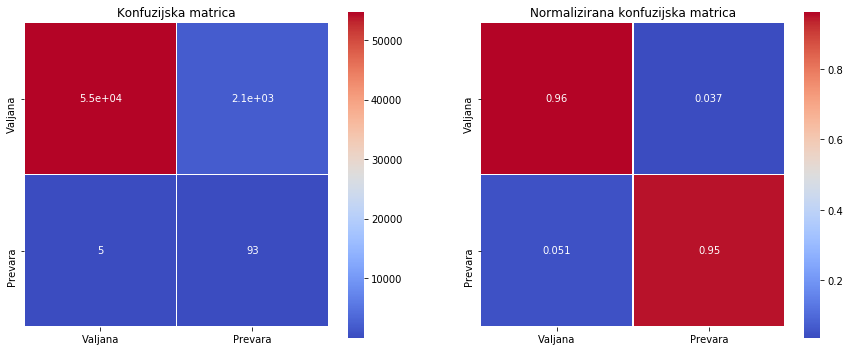

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
LGBM (Light Gradient Boosting Method)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 4.07%
	Recall score: 93.88%
	F1 score: 7.8%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.94      0.08        98

    accuracy                           0.96     56962
   macro avg       0.52      0.95      0.53     56962
weighted avg       1.00      0.96      0.98     56962


----------------------------------------------------------------------------------------------------


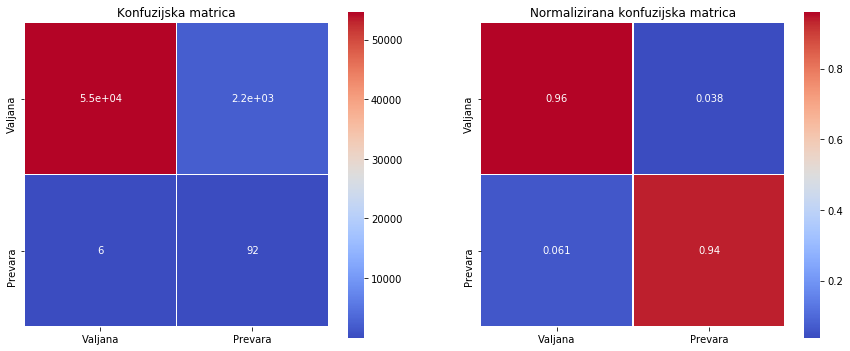

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
CatBoost (Categorical Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 6.01%
	Recall score: 92.86%
	F1 score: 11.3%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.93      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962


----------------------------------------------------------------------------------------------------


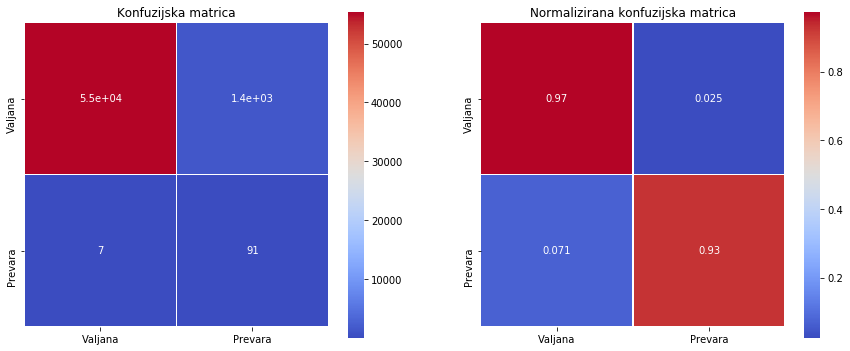

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
AdaBoost (Adaptive Boosting)
----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 3.4000000000000004%
	Recall score: 93.88%
	F1 score: 6.5600000000000005%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     56864
           1       0.03      0.94      0.07        98

    accuracy                           0.95     56962
   macro avg       0.52      0.95      0.52     56962
weighted avg       1.00      0.95      0.97     56962


----------------------------------------------------------------------------------------------------


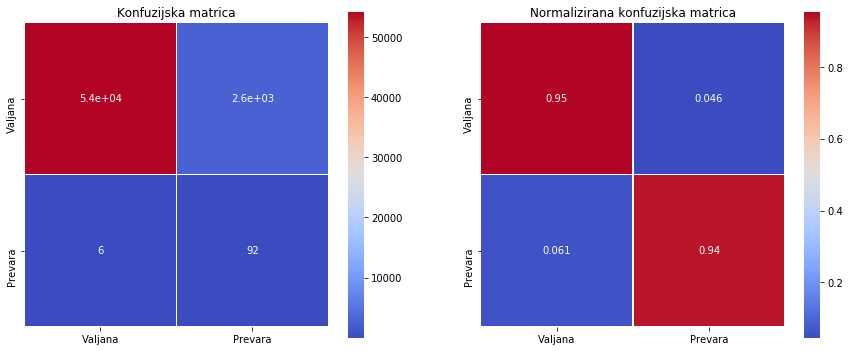

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [25]:
full_pred_xgb_params_cut = xgb_est_cut.predict(X_data_test)
full_pred_lgbm_params_cut = lgbm_est_cut.predict(X_data_test)
full_pred_cat_params_cut = cat_est_cut.predict(X_data_test)
full_pred_ada_params_cut = ada_est_cut.predict(X_data_test)

print('*'*100)
print("XGB (eXtreme Gradient Boosting)")
print_everything(y_data_test, full_pred_xgb_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("LGBM (Light Gradient Boosting Method)")
print_everything(y_data_test, full_pred_lgbm_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("CatBoost (Categorical Boosting)")
print_everything(y_data_test, full_pred_cat_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('-'*100)
print("AdaBoost (Adaptive Boosting)")
print_everything(y_data_test, full_pred_ada_params_cut, y_data_test_non_fraud_num, y_data_test_fraud_num, None, False)
print('*'*100)

Za sve boosting algoritme dobili smo slične rezultate. Osjetljivost je jako visoka (za XGB je 94.9%, za LGBM 93.88%, za CatBoost 92.86%, te za AdaBoost 93.88%). Preciznost i f1-mjera su nešto slabiji nego kod većine prijašnjih algoritama (ali nisu preniski). Kada za klasifikator koristimo XGB dobili smo oko 2100 pogrešno klasificiranih valjanih transakcija te čak 93 ispravno klasificirane prevare, za LGBM smo dobili oko 2200 pogrešno klasificiranih valjanih transakcija te 92 ispravno klasificirane prevare (oboje slabije nego kod XGB-a). Za CatBoost smo dobili nešto manje pogrešno klasificiranih valjanih transakcija (oko 1400), ali i manje ispravno klasificiranih prevara (91). AdaBoostom smo dobili nešto slabije rezultate nego LGBM-om (jednako ispravno klasificiranih prevara - 92, ali i oko 2600 pogrešno klasificiranih valjanih transakcija (otprilike 400 više nego LGBM)).

## Redukcija dimenzionalnosti

<p> Sada ćemo se nakratko posvetiti algoritmima za redukciju dimenzionalnosti. Konkretno govorimo o <em>t-SNE</em> i <em>PCA</em>. Opišimo sada malo svaki od njih te prikažimo dobivene rezultate. </p>
<ul>
    <li><em>t-SNE (t-distributed Stochastic Neighbor Embedding)</em> - noviji algoritam koji koristi nelinearnu redukciju dimenzija. Odnosno, dijeli klase tako da granica nije ravna linija (pravac). </li>
    <li><em>PCA (Principal Component Analysis)</em> - ortogonalna linearna projekcija, inače standardan algoritam za redukciju deimnezionalnosti. </li>
</ul>

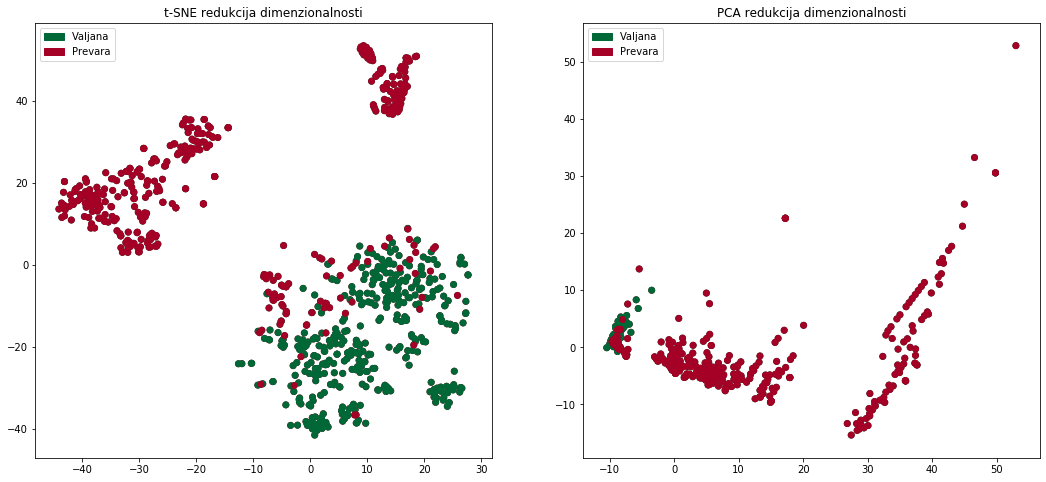

In [13]:
#t-SNE + PCA za skup podataka nakon undersamplinga
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import matplotlib

cm = matplotlib.cm.get_cmap('RdYlGn_r')
red = cm(256)
green = cm(0)

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_usample_train.values)
X_pca = PCA(n_components=2, random_state=42).fit_transform(X_usample_train.values)


fig_tsne_pca, ax_tsne_pca = plt.subplots(1,2,figsize=(18,8))


non_fraud_patch = mpatches.Patch(color=green, label='Valjana')
fraud_patch = mpatches.Patch(color=red, label='Prevara')

ax_tsne_pca[0].scatter(X_tsne[:,0], X_tsne[:,1], c=(y_usample_train == 0), cmap='RdYlGn_r', label='Valjana')
ax_tsne_pca[0].scatter(X_tsne[:,0], X_tsne[:,1], c=(y_usample_train == 1), cmap='RdYlGn_r', label='Prevara')

ax_tsne_pca[1].scatter(X_pca[:,0], X_pca[:,1], c=(y_usample_train == 0), cmap='RdYlGn_r', label='Valjana')
ax_tsne_pca[1].scatter(X_pca[:,0], X_pca[:,1], c=(y_usample_train == 1), cmap='RdYlGn_r', label='Prevara')

ax_tsne_pca[0].set_title('t-SNE redukcija dimenzionalnosti')
ax_tsne_pca[1].set_title('PCA redukcija dimenzionalnosti')

ax_tsne_pca[0].legend(handles=[non_fraud_patch, fraud_patch])
ax_tsne_pca[1].legend(handles=[non_fraud_patch, fraud_patch])

plt.show()

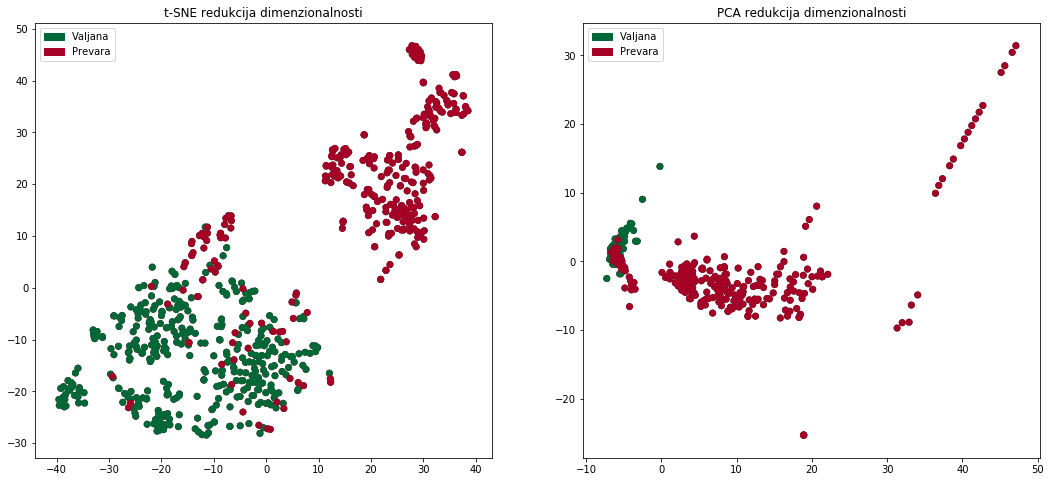

In [21]:
X_tsne_cut = TSNE(n_components=2, random_state=42).fit_transform(X_usample_train_cut.values)
X_pca_cut = PCA(n_components=2, random_state=42).fit_transform(X_usample_train_cut.values)


fig_tsne_pca_cut, ax_tsne_pca_cut = plt.subplots(1,2,figsize=(18,8))

non_fraud_patch = mpatches.Patch(color=green, label='Valjana')
fraud_patch = mpatches.Patch(color=red, label='Prevara')

ax_tsne_pca_cut[0].scatter(X_tsne_cut[:,0], X_tsne_cut[:,1], c=(y_usample_train_cut == 0), cmap='RdYlGn_r', label='Valjana')
ax_tsne_pca_cut[0].scatter(X_tsne_cut[:,0], X_tsne_cut[:,1], c=(y_usample_train_cut == 1), cmap='RdYlGn_r', label='Prevara')

ax_tsne_pca_cut[1].scatter(X_pca_cut[:,0], X_pca_cut[:,1], c=(y_usample_train_cut == 0), cmap='RdYlGn_r', label='Valjana')
ax_tsne_pca_cut[1].scatter(X_pca_cut[:,0], X_pca_cut[:,1], c=(y_usample_train_cut == 1), cmap='RdYlGn_r', label='Prevara')

ax_tsne_pca_cut[0].set_title('t-SNE redukcija dimenzionalnosti')
ax_tsne_pca_cut[1].set_title('PCA redukcija dimenzionalnosti')

ax_tsne_pca_cut[0].legend(handles=[non_fraud_patch, fraud_patch])
ax_tsne_pca_cut[1].legend(handles=[non_fraud_patch, fraud_patch])

plt.show()

Iz grafova vidimo da T-SNE transformacija puno bolje 'dijeli' klase nego PCA transformacija (to uključuje i prvi i drugi par grafova).